<a href="https://colab.research.google.com/github/DavidEmeryUofC/DavidEmeryUofC/blob/main/G701_StratiMbl_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stratigraphic modelling (Single Fault)
This python project is part of my GOPH701 project for creates a stratigraphic model that will be later used for creating a synthetic seismic profile.

Written by [David Emery](https://www.linkedin.com/in/david-emery-54659a3a/)

In [ ]:
# To supress warnings and deprecated messages
import warnings
warnings.filterwarnings("ignore")

# Core routines
import numpy as np
import pandas as pd
import math
import time

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

##Default Plot Parameters

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
density_colors = ['white', 'lightgrey', 'skyblue', 'green', 'yellow', 'gold', 'darkorange', 'red', 'DarkRed', 'violet']
plt.register_cmap(cmap=LinearSegmentedColormap.from_list('wbgr', density_colors))
plt.register_cmap(cmap=LinearSegmentedColormap.from_list('wbgr_trans', density_colors, gamma=np.linspace(1, 0, 256)))

# Reversed density
density_colorsR = ['violet', 'DarkRed', 'red', 'darkorange', 'gold', 'yellow', 'green', 'skyblue', 'lightgrey','white']
plt.register_cmap(cmap=LinearSegmentedColormap.from_list('wbgr_r', density_colorsR))

# Colour map for displaying GR from yellow to grey 
gammaray_colors = ['salmon','yellow', 'lightgreen','lightgrey', 'silver','gray','slategrey']
plt.register_cmap(cmap=LinearSegmentedColormap.from_list('gr_color', gammaray_colors))

# Colour map for displaying grain size from coastal(green 1) shoreline (yellow 0.7 ) offshore (grey 0)
lith_colors = ['slategrey','gray','silver','lightpink','yellow','lightgreen']
plt.register_cmap(cmap=LinearSegmentedColormap.from_list('lith_color', lith_colors))

# Colour map for displaying Deposition Enviroment from coastal(green) shoreline (yellow) to offshore (grey) 
env_colors = ['lightgreen','yellow','gold','orange','lightyellow','gray','silver','wheat']
plt.register_cmap(cmap=LinearSegmentedColormap.from_list('env_color', env_colors))

# Default figure size for use in Powerpoint
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['figure.dpi'] = 144

plt.tight_layout()

# Default font size
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

<Figure size 1440x1008 with 0 Axes>

#Model setup and size

The basic program runs through approximately 100-10000 time steps to produce an approximate 3-5 km thick sedimentary wedge. Siliciclastic input (SED) is approximately enough to fill 1/4 of the width of the model 1 m per time step with the source of the sediment from the left and the offshore to the right. Carbonate input (CAL) would be variable as a function of water depth and purity (absences of SED in the water column). The other mineral types would be event specific and are not expect to make up more 3% of the total volume. 

The model assume a subsidence rate that matches sedimentary input but subsidence rate is expected to vary over the time steps. Likewise eustatic & base line is expected to vary over a faster rate of 10-80 time steps (150-250 cycles)

2.5D Model size would be 200 km (2000 cells - 100m each) by 50 km (100 cells - 500m). 10000 x 2000 x 100 = 2 million cells. For GOPH701 three 2D models will be conducted instead of the broader 2.5D model.  The three models are for fluvial, coastal plain, and carbonate platform (200000). 

The initial slope is 1/2000 or 100 m across the 200 km model (25 to -74 m). For erosion the surface is assumed to be metamorphic with an erosion and compaction index of 0. 

Model parameters are:
- model present depth for cell
- model surface elevation for deposition
- deposition initial thickness
- deposition facies
- thickness after compaction & erosion
- deposition maximum burial depth


## Load modeling parameters
Input parameters are:
- age which represents the index of each model step (should index from 1 to X with 0 being used for the fixed initial condition)
- sediment supply
- subsidence of the earth: 1 is for the proximale left side, 2 is for the distal right side (normally the right side should be greater than the left)
- eustasy the change in local sea level



In [ ]:
CG_cutoff = 0.70   #Coarse Grain Cuttoff
OSfraction = 0.33   #When offshore sedimentation stops being to the bsl (default 0.33)
FluvialScaler = 0.25 # 0-1 with 1 applying 100% fluvial erosion
ErosionScaler = 1.0  #0-1 with 1 applying 100% full shoreface erosion
Tpercent = 0.66    # Percentage split between offshore/turbidite and onshore deposit of erode coastal sediment.

In [ ]:
# Bulk setting the model parameters
Steps = 501
Csize = 200
nCells = 3001
WaterDepth = 100
InitialHgt = 50
Subsidence = 200
Fault = 150
Fault3 = False
FaultDuration = 0.90   #Enter a percentage
SedPercent = 150
Eustacy2 = 2     #2
Sealevel2 = 10
Eustacy2shift = -0.66
Eustacy3 = Eustacy2 * 12     #12
Sealevel3 = Sealevel2 * 0.5   #0.2
Eustacy4 = Eustacy3 * 4       #4
Sealevel4 = Sealevel3 * 0.5   #0.1
TB = 1.25
FWB = 3
SWB = 5

Enter the number of steps

In [ ]:
#Steps = None # Number of layers or steps in the model
data = pd.DataFrame()  # dataframe for storing the variation by time step

while Steps is None:
  try:
    Steps = int(input('Enter the the number of time steps '))
  except ValueError:
    print('You need to enter a number')

Age = np.arange(0, Steps, 1)
Ones = np.ones(Steps)
data['Age'] = Age

Enter the number of size of each cell in meters

In [ ]:
#Csize = None # Cell size required for gradient estimation
while Csize is None:
  try:
    Csize = int(input('Enter the the size of each cell in the model '))
  except ValueError:
    print('You need to enter a number')

Enter the number of cells in the model

In [ ]:
#nCells = None # Number of horizontal cells
while nCells is None:
  try:
    nCells = int(input('Enter the the number cell in the model '))
  except ValueError:
    print('You need to enter a number')

In [ ]:
xlength = np.linspace(0,(nCells-1)*Csize/1000,nCells)
modelSize = xlength[-1]
print('The model length is',modelSize,'km')

The model length is 600.0 km


##Set up the dataframe for tracking output for each time step

In [ ]:
# Create model array
nAges = Steps # number of input parameters
nCols = nCells  # arbitary number

dfelev = pd.DataFrame(0.0,index=range(nCols),columns=range(nAges)) # elevation/baselevel at time of deposition (top)
dfbase= pd.DataFrame(0.0,index=range(nCols),columns=range(nAges)) # present interval base of sedimentation
dfbref= pd.DataFrame(0.0,index=range(nCols),columns=range(nAges)) # preserve the base reference before erosion
dfthick = pd.DataFrame(0.0,index=range(nCols),columns=range(nAges)) # thickness deposited
dfdepth = pd.DataFrame(0.0,index=range(nCols),columns=range(nAges)) # burial depth
dflith = pd.DataFrame(1.0,index=range(nCols),columns=range(nAges)) # lithology value (1 to 0)
dffacies = pd.DataFrame(0.0,index=range(nCols),columns=range(nAges)) # final lithology value (1 to 0)
dfenv = pd.DataFrame(0.0,index=range(nCols),columns=range(nAges)) # depositional enviroment (0 Basement, 1 Coastal Plain, 2 Foreshore, 3 Uppershore, 4 Lowershore, 5 Nearshore, 6 Offshore)
dferosion = pd.DataFrame(0.0, index=range(nCols),columns=range(nAges)) # meters erode prior to deposition (base = depth - erosion)
dfprofile = pd.DataFrame(0.0, index=range(nCols),columns=range(nAges)) # dataframe for storing initial profile

Enter the amount of model slope

In [ ]:
#WaterDepth = None # Water depth at the start of the model (right side of model)
while WaterDepth is None:
  try:
    WaterDepth = float(input('Enter the drop across the model (example 1000) '))
  except ValueError:
    print('You need to enter a number')

#InitialHgt = None # Inital Elevation model (left side of model)
while InitialHgt is None:
  try:
    InitialHgt = float(input('Enter the drop across the model (example 1000) '))
  except ValueError:
    print('You need to enter a number')

# Determine and display the change across the model
Change = InitialHgt + WaterDepth
print('The depth variation across a', modelSize,'km model is',round(Change,1),'m')
dfelev[0] = np.linspace(InitialHgt, -WaterDepth, nCells)
print('The change per cell', round(Change,1),'m at a slope of 1:',round(modelSize*1000/Change,0))

The depth variation across a 600.0 km model is 150 m
The change per cell 150 m at a slope of 1: 4000.0


Create the default starting model parameters for below the slope

In [ ]:
dfbase[0] = np.linspace(-WaterDepth, -WaterDepth, nCells)
dfbref[0] = dfbase[0]
dflith[0] = np.linspace(1,0,nCells)
dfenv[0] = 0
elev_min = int(dfelev[0].min()/25)*25-25
elev_max = int(dfelev[0].max()/25)*25+25
SFpt = modelSize*InitialHgt/(InitialHgt+WaterDepth)

##Single setp plot 

In [ ]:
def plotStep(step,x,elev,base,ref,lith,prof,sw=-8,sf=[0,0,10,10],elev_max=50,elev_min=-150):
  plt.figure(figsize = (14, 6))
  plt.plot(x,np.linspace(0,0,len(x)),c='blue',linestyle='--')
  plt.plot(x,np.linspace(sw,sw,len(x)),c='blue',linestyle='dotted')
  plt.plot(x,ref,c='k',linestyle='dotted',linewidth=0.5)
  plt.plot(x,base,c='grey',linewidth=1)
  plt.plot(x,prof,c='red',linewidth=0.5,linestyle='dashed')
  plt.scatter(x,elev,c=lith,cmap='lith_color',s=1,vmin=0, vmax=1)
  plt.arrow(sf[0],sf[1],sf[2],sf[3],head_width=3,head_length=2,head_starts_at_zero=False, length_includes_head=True)
  plt.ylim(elev_min,elev_max)
  plt.ylabel('Elevation (m')
  plt.xlabel('Horizonatl distance (km')
  plt.title(str(int(step)) + ' Model Profile')
  #plt.axvspan(df.Base,df.Elev)
  #plt.fill_betweenx(xlength,df.Base,df.Elev, c=(1-df.Sediment),cmap='lith_color')

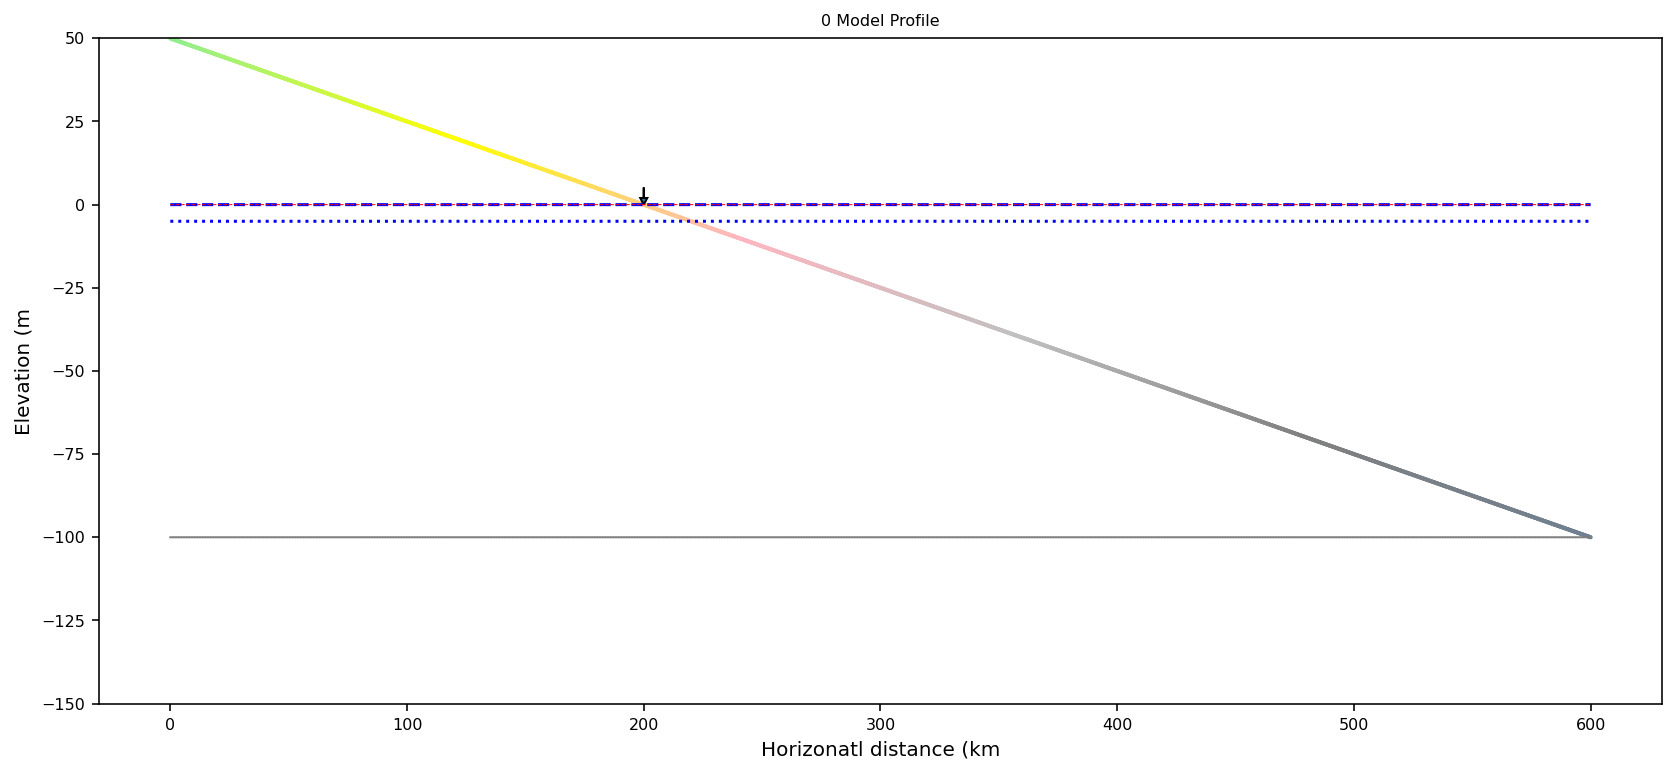

In [ ]:
DepthC = 5
plotStep(0,xlength,dfelev[0],dfbase[0],dfbref[0],dflith[0],dfprofile[0],-DepthC,[SFpt,DepthC,0,-DepthC])

Enter the total amount of subsidence

In [ ]:
#Subsidence = None # Total Subsidense
while Subsidence is None:
  try:
    Subsidence = float(input('Enter the total amount of subsidence '))
  except ValueError:
    print('You need to enter a number')

SubPstep = Subsidence/(Steps-1)
print('The amount of average subsidence per time step is',round(SubPstep,3),'m')

The amount of average subsidence per time step is 0.4 m


Subsidences

In [ ]:
#data['Subsidence1'] = InitialHgt/4/Steps*np.ones(Steps)*np.random.normal(1,0.05,Steps)
data['Subsidence1'] = -InitialHgt/Steps*np.ones(Steps)*np.random.normal(1,0.05,Steps)
data['Subsidence2'] = Subsidence/Steps*np.ones(Steps)*np.random.normal(1,0.05,Steps)
   
print('The amount of proximal subsidence',np.round(-InitialHgt/Steps,2),'m/step')
print('The amount of distal subsidence',np.round(Subsidence/Steps,2),'m/step')

The amount of proximal subsidence -0.1 m/step
The amount of distal subsidence 0.4 m/step


In [ ]:
xdatum = np.linspace(data.Subsidence1.sum(),data.Subsidence2.sum(),nCells)
print('The left side of the model subsidence',round(data.Subsidence1.sum(),1),'while the right side drop',round(data.Subsidence2.sum(),1),'for a difference of',round(data.Subsidence2.sum()-data.Subsidence1.sum(),1))
      

The left side of the model subsidence -50.0 while the right side drop 200.3 for a difference of 250.3


##Faulting

In [ ]:
#Fault = None # Total amount of fault throw
while Fault is None:
  try:
    Fault = float(input('Enter the amount of fault subsidence '))
  except ValueError:
    print('You need to enter a number')

In [ ]:
#Fault = None # Total amount of fault throw
while FaultDuration is None:
  try:
    FaultDuration = float(input('Enter the duration of fault subsidence '))
  except ValueError:
    print('You need to enter a number')
if FaultDuration > 2 : FaultDuration = FaultDuration/100

print('Faulting only applied for the first', np.round(FaultDuration*100,1),'% of the steps in the model')

# Apply the faulting only from the start of the steps
data['Fault'] = 0   # set default fault throw to 0 (none)
Fsteps = int(Steps*FaultDuration)
data.Fault[:Fsteps] = 1    # update the early fault (100%)
print('Fault motion is ',np.round(Fault/Fsteps,2),'m per step')
FaultPturn = Fault/Fsteps,2

Faulting only applied for the first 90.0 % of the steps in the model
Fault motion is  0.33 m per step


###Fault3

In [ ]:
if Fault3:
  #Fault = None # Total amount of fault throw
  while Fault is None:
    try:
      Fault = float(input('Enter the amount of fault subsidence '))
    except ValueError:
      print('You need to enter a number')
  print('Faulting only applied for the first 2/3 steps of the model')

  # Apply the faulting only over the early (2/3) of the steps
  data['Fault'] = 0   # set default fault throw to 0 (none)
  Fsteps = int(Steps*FaultDuration)
  data.Fault[:Fsteps] = 1    # update the early fault (100%)
  print('Fault motion is ',np.round(Fault/Fsteps,2),'m per step')
  FaultPturn = Fault/Fsteps,2

Determine and display the expect appears of the final model displacement.

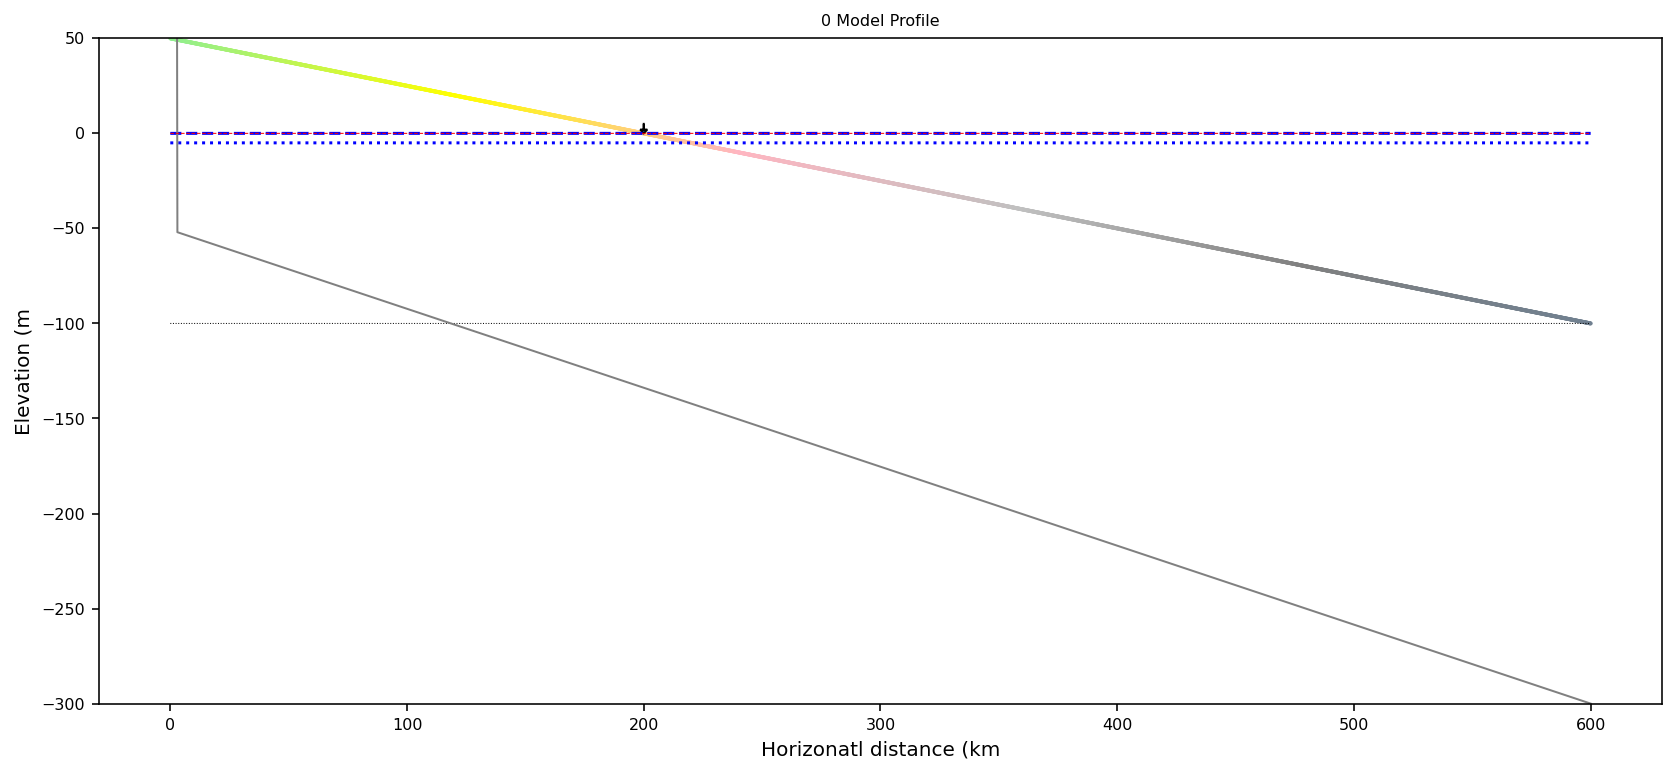

In [ ]:
# apply the lithospheric subsidence and fault offset
Tilt = np.linspace(-InitialHgt,Subsidence,nCells)
# apply fault movement 4 faults
Foffset = np.linspace(0,0,nCells)
fault1 = int(nCells/199)
fault2 = nCells
Fthrow1 = np.linspace(Fault    ,0,fault2-fault1)
Foffset[fault1:fault2] = Fthrow1

if Fault3:
  # apply fault movement 4 faults
  Foffset = np.linspace(0,0,nCells)
  fault1 = 50
  fault2 = int(nCells*1/4)
  fault3 = int(nCells*1/2)
  fault4 = int(nCells*3/4)
  Fthrow1 = np.linspace(Fault    ,Fault-Fault/2,fault2-fault1)
  Fthrow2 = np.linspace(Fault*7/8,Fault*7/8-Fault/2,fault3-fault2)
  Fthrow3 = np.linspace(Fault*6/8,Fault*6/8-Fault/2,fault4-fault3)
  Fthrow4 = np.linspace(Fault*5/8,Fault*5/8-Fault/2,nCells-fault4)
  Foffset[fault1:fault2] = Fthrow1
  Foffset[fault2:fault3] = Fthrow2
  Foffset[fault3:fault4] = Fthrow3
  Foffset[fault4:] = Fthrow4

FoffsetPturn = Foffset/Fsteps
OffsetBase = dfelev[0] - Tilt - Foffset

DepthC = 5
ModelDepth = np.min(OffsetBase)
plotStep(0,xlength,dfelev[0],OffsetBase,dfbref[0],dflith[0],dfprofile[0],-DepthC,[SFpt,DepthC,0,-DepthC],InitialHgt,ModelDepth)

Sediment %

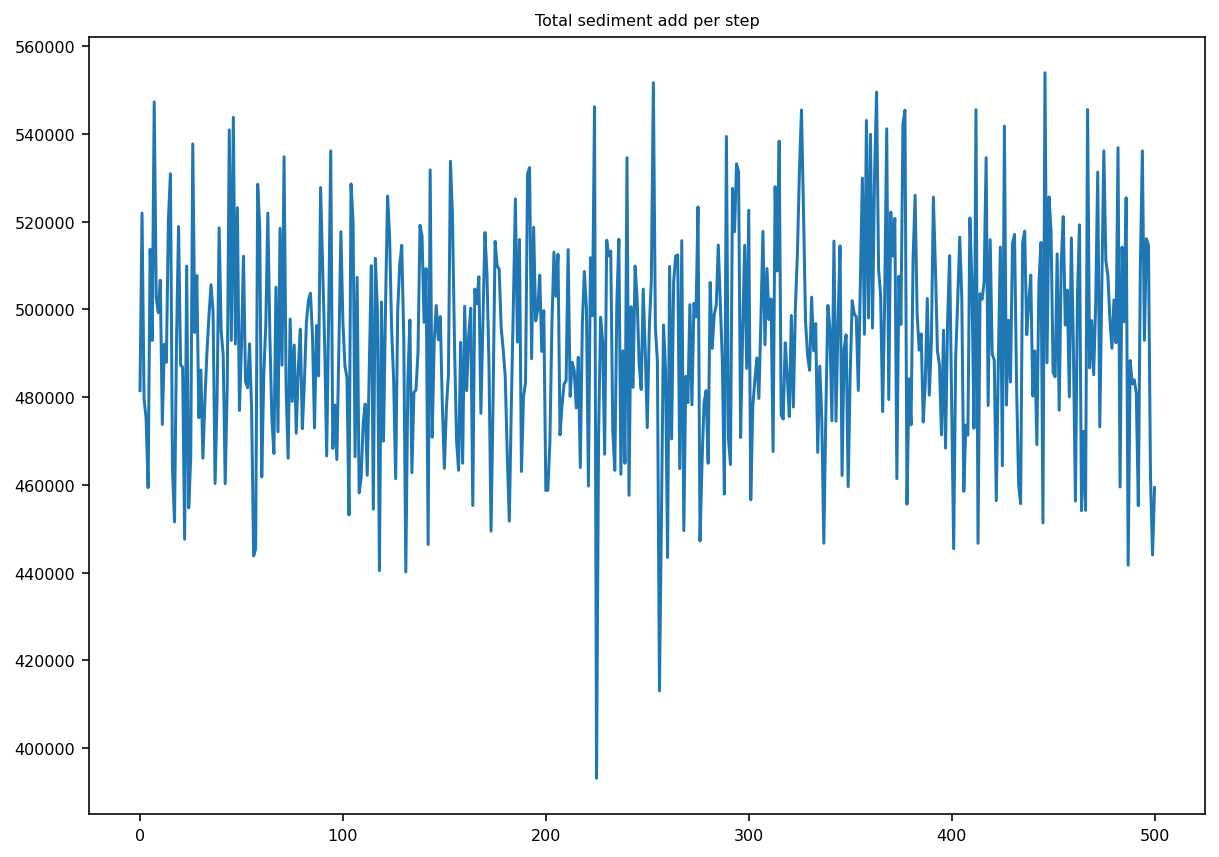

In [ ]:
#SedPercent = None # Percentage of subsidence covered by sediment
#Generally if compaction is applied will need to be greater than 100%
while SedPercent is None:
  try:
    SedPercent = float(input('Enter the amount of subsidence covered by sedimentation'))
  except ValueError:
    print('You need to enter a number')
if SedPercent > 10: SedPercent = SedPercent/100

data['Sediment'] = np.sum(np.max(OffsetBase)-OffsetBase) * Csize /Steps * SedPercent *np.random.normal(1,0.05,Steps) # volume per step subsidences
plt.plot(data.Sediment)
plt.title('Total sediment add per step');

Enter the number of Eustacy cycle to divide into the steps

In [ ]:
#Eustacy2 = None # Number of second Order Eustacy cycles
while Eustacy2 is None:
  try:
    Eustacy2 = int(input('Enter the number of 2nd order Eustacy Cycles '))
  except ValueError:
    print('You need to enter a number')
print('Number of steps per 2nd Order Eustacy Cycle',Steps/(Eustacy2))

#Eustacy2shift = None # Number of second Order Eustacy cycles
while Eustacy2shift is None:
  try:
    Eustacy2shift = int(input('Enter the 2nd order Eustacy Cycles shift (0 = lowstand)'))
  except ValueError:
    print('You need to enter a number')
#print('Number of steps per 2nd Order Eustacy Cycle',Steps/(Eustacy2))

#Eustacy3 = None # Number of third Order Eustacy cycles
while Eustacy3 is None:
  try:
    Eustacy3 = int(input('Enter the number of 3rd order Eustacy Cycles '))
  except ValueError:
    print('You need to enter a number')
print('Number of steps per 3rd Order Eustacy Cycle',Steps/(Eustacy3))

#Eustacy4 = None # Number of fourth Order Eustacy cycles
while Eustacy4 is None:
  try:
    Eustacy4 = int(input('Enter the number of 4th order Eustacy Cycles '))
  except ValueError:
    print('You need to enter a number')
print('Number of steps per 4th Order Eustacy Cycle',Steps/(Eustacy4))

Number of steps per 2nd Order Eustacy Cycle 250.5
Number of steps per 3rd Order Eustacy Cycle 20.875
Number of steps per 4th Order Eustacy Cycle 5.21875


##Enter the amount of sea level change per cycle 

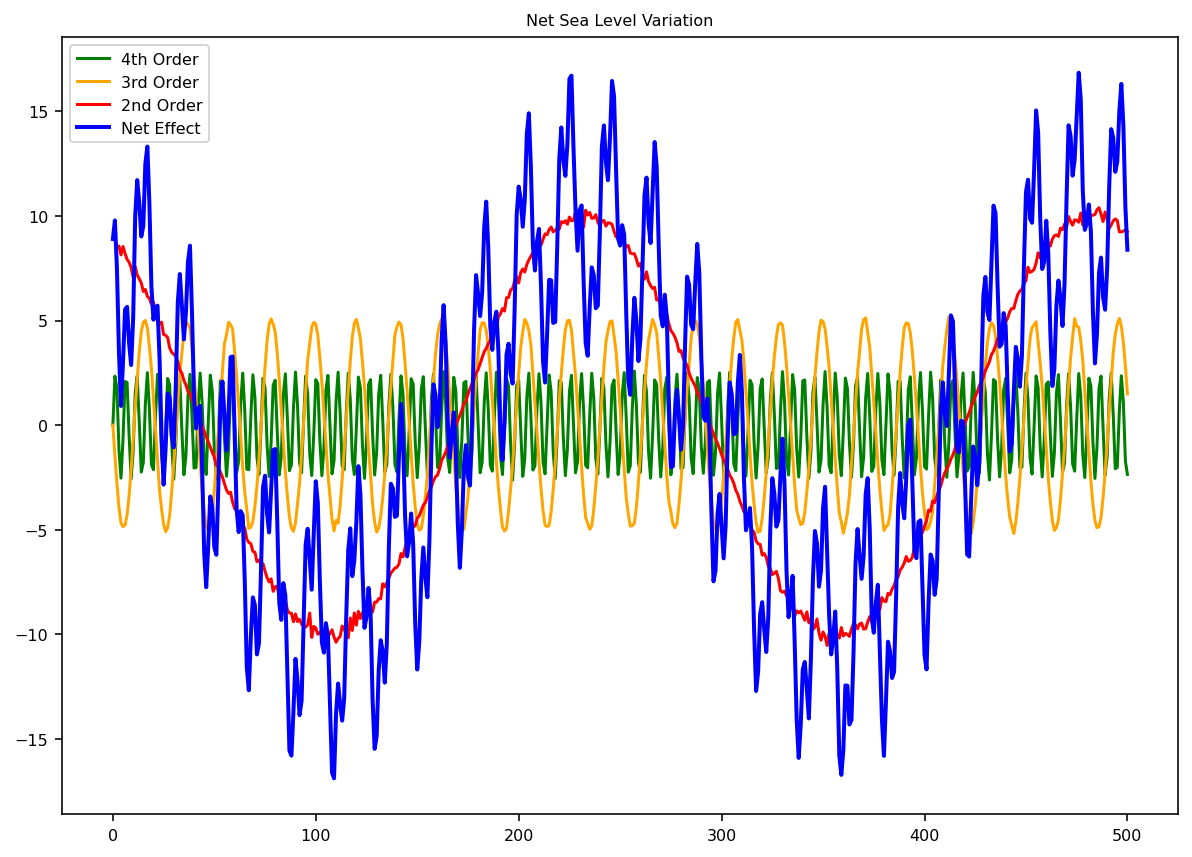

In [ ]:
#Sealevel2 = None # Sealevel variation across each Eustacy cycles
while Sealevel2 is None:
  try:
    Sealevel2 = float(input('Enter the sea level variation for 2nd order cycles'))
  except ValueError:
    print('You need to enter a number')

#Sealevel3 = None # Sealevel variation across 3rd Eustacy cycles (50% second)
while Sealevel3 is None:
  try:
    Sealevel3 = float(input('Enter the sea level variation for 3rd order cycles'))
  except ValueError:
    print('You need to enter a number')

#Sealevel4 = None # Sealevel variation across 4th Eustacy cycles (50% of third)
while Sealevel4 is None:
  try:
    Sealevel4 = float(input('Enter the sea level variation for 4th order cycles'))
  except ValueError:
    print('You need to enter a number')

Eustacy2shift = -0.65
Order2 = Sealevel2*np.sin(math.pi*(data.Age/(Steps/(Eustacy2*2))-Eustacy2shift))*np.ones(Steps)*np.random.normal(1,0.025,Steps);
Order3 = -Sealevel3*np.sin(math.pi*data.Age/(Steps/(Eustacy3*2)))*np.ones(Steps)*np.random.normal(1,0.025,Steps);
Order4 = Sealevel4*np.sin(math.pi*data.Age/(Steps/(Eustacy4*2)))*np.ones(Steps)*np.random.normal(1,0.025,Steps);
data['Sealevel'] = Order2 + Order3 + Order4

plt.plot(Order4,c='green',label='4th Order')
plt.plot(Order3,c='orange',label='3rd Order')
plt.plot(Order2,c='red',label='2nd Order')
plt.plot(data.Sealevel,c='blue',linewidth=2,label='Net Effect')
plt.legend()
plt.title('Net Sea Level Variation');

Storm Wave depth

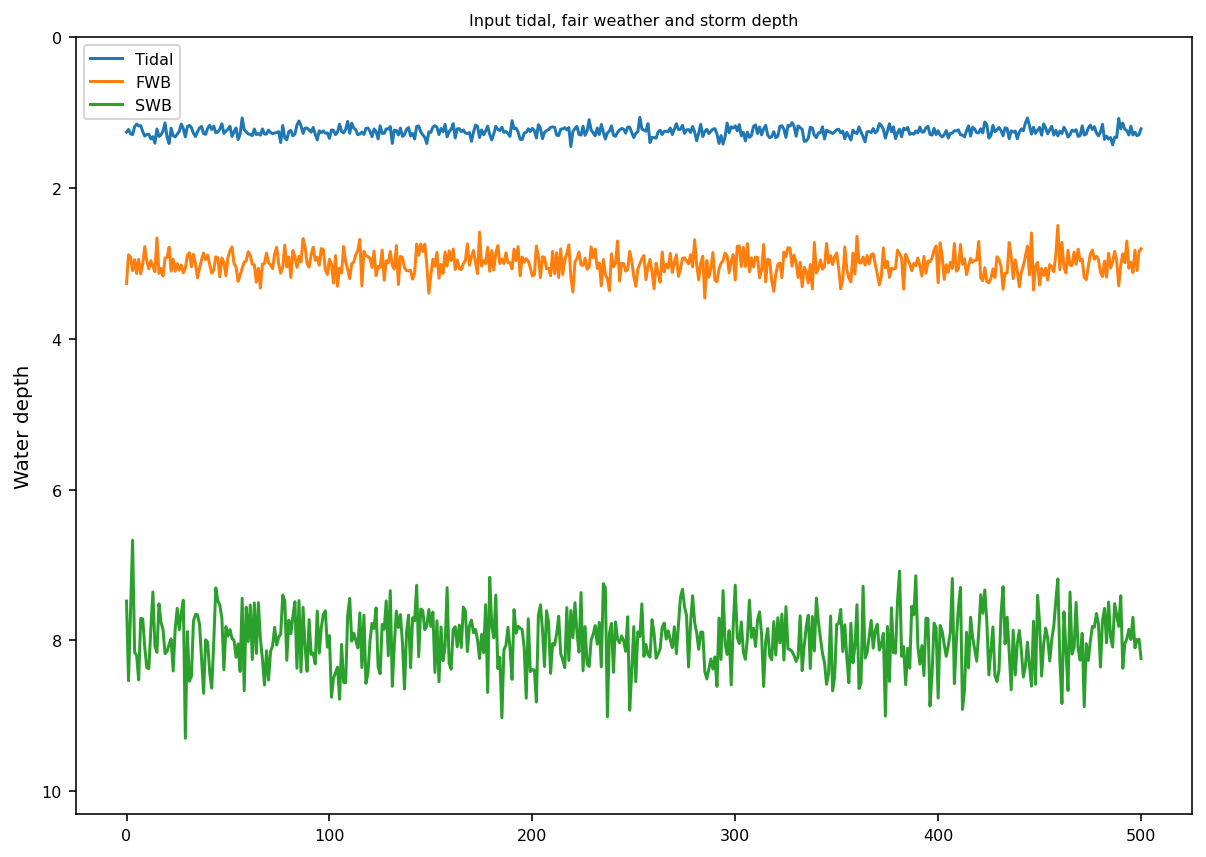

In [ ]:
#TB = None # Tidal depth
while TB is None:
  try:
    TB = float(input('Enter the Tide height '))
  except ValueError:
    print('You need to enter a number')
data['TB'] = TB*np.ones(Steps)*np.random.normal(1,0.05,Steps);

#FWB = None # Fair Weather Base
while FWB is None:
  try:
    FWB = float(input('Enter the Fair weather wave depth '))
  except ValueError:
    print('You need to enter a number')
data['FWB'] = FWB*np.ones(Steps)*np.random.normal(1,0.05,Steps);

#SWB = None # Additional depth to Storm Wave Base
while SWB is None:
  try:
    SWB = float(input('Enter the additional depth to SWB  '))
  except ValueError:
    print('You need to enter a number')
data['SWB'] = (FWB + SWB)*np.ones(Steps)*np.random.normal(1,0.05,Steps)
SWBmax = data.SWB.max();

plt.title('Input tidal, fair weather and storm depth')
plt.plot(data.TB,label='Tidal')
plt.plot(data.FWB,label='FWB')
plt.plot(data.SWB,label='SWB')
plt.legend()
plt.ylabel('Water depth')

plt.ylim(data.SWB.max()+1,0);

In [ ]:
data.describe()

Age  Subsidence1  Subsidence2       Fault       Sediment  \
count  501.000000   501.000000   501.000000  501.000000     501.000000   
mean   250.000000    -0.099707     0.399863    0.898204  492994.218378   
std    144.770508     0.004931     0.020125    0.302683   23932.188161   
min      0.000000    -0.113167     0.345645    0.000000  393110.988926   
25%    125.000000    -0.102982     0.386513    1.000000  477760.077667   
50%    250.000000    -0.099946     0.399829    1.000000  492944.020032   
75%    375.000000    -0.096479     0.413882    1.000000  509334.133208   
max    500.000000    -0.085586     0.458165    1.000000  553980.788827   

         Sealevel          TB         FWB         SWB  
count  501.000000  501.000000  501.000000  501.000000  
mean     0.001060    1.249162    3.002183    7.998680  
std      8.120793    0.062161    0.152198    0.377728  
min    -16.883664    1.060628    2.495275    6.672240  
25%     -6.270052    1.205840    2.903787    7.740811  
50%      0.022625    1.250298    3.001870    7.990799  
75%      6.234079    1.289628    3.097033    8.247988  
max     16.845173    1.447829    3.460482    9.300601

##Display the input parameters

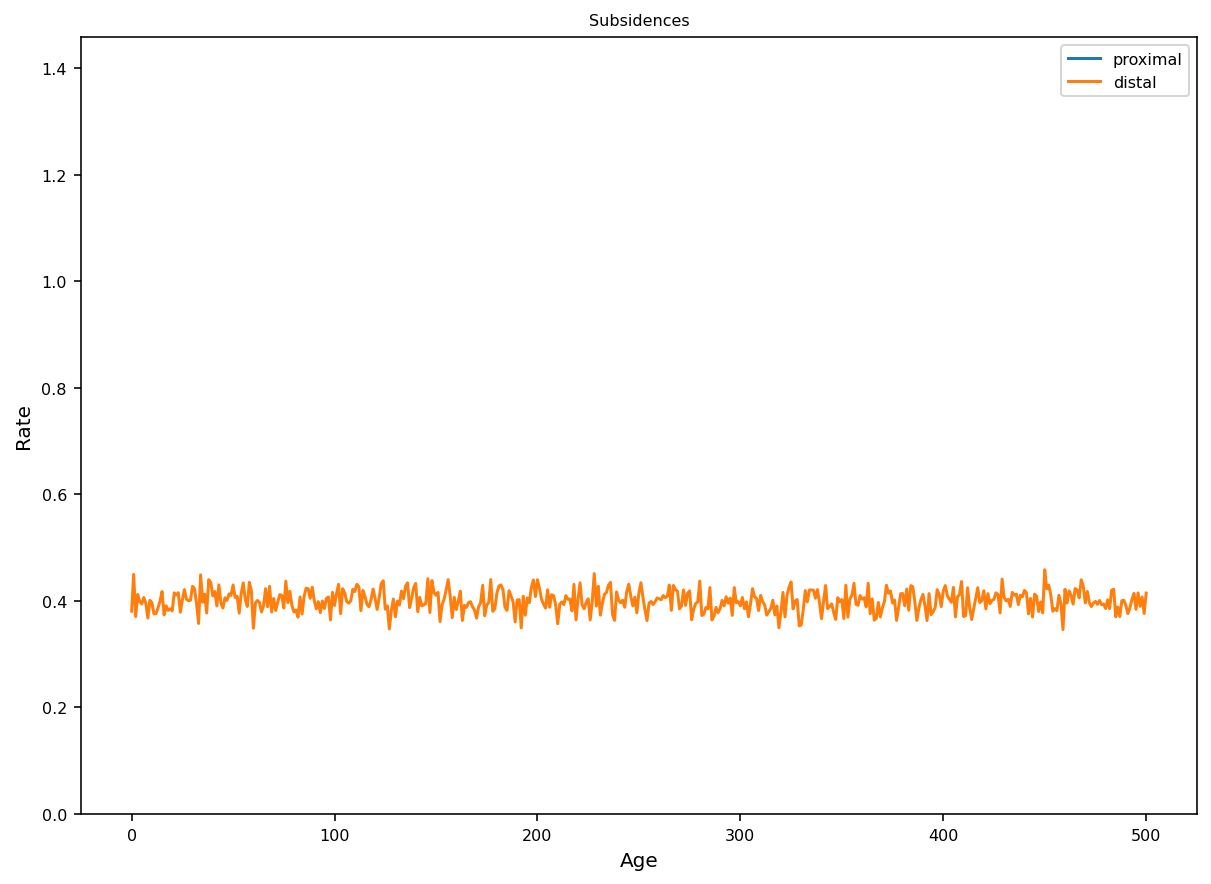

In [ ]:
plt.plot(data.Age,data.Subsidence1,label='proximal')
plt.plot(data.Age,data.Subsidence2,label='distal')
plt.ylim(0,data.Subsidence2.max()+1)
plt.xlabel('Age')
plt.ylabel('Rate')
plt.legend()
plt.title("Subsidences") ;  

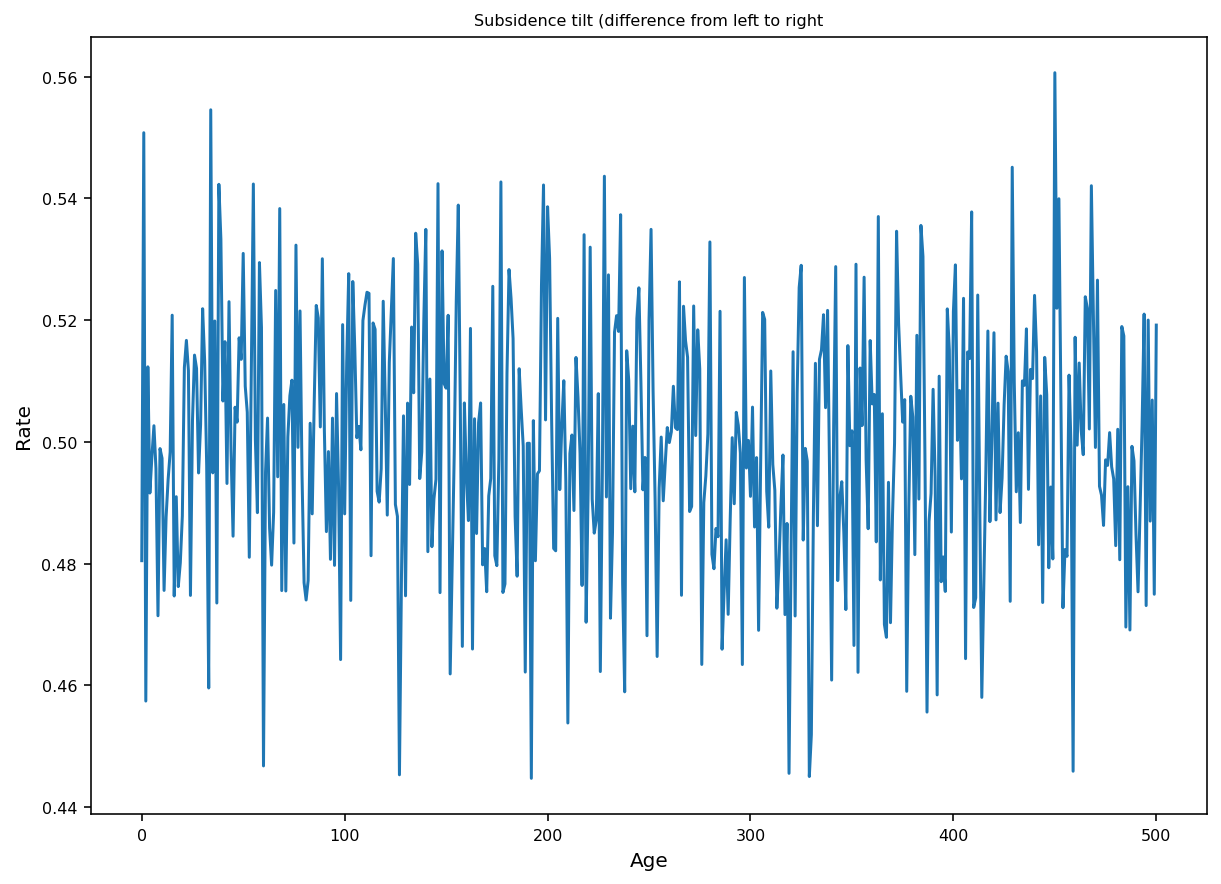

In [ ]:
plt.plot(data.Age,data.Subsidence2-data.Subsidence1)
plt.xlabel('Age')
plt.ylabel('Rate')
plt.title("Subsidence tilt (difference from left to right");   

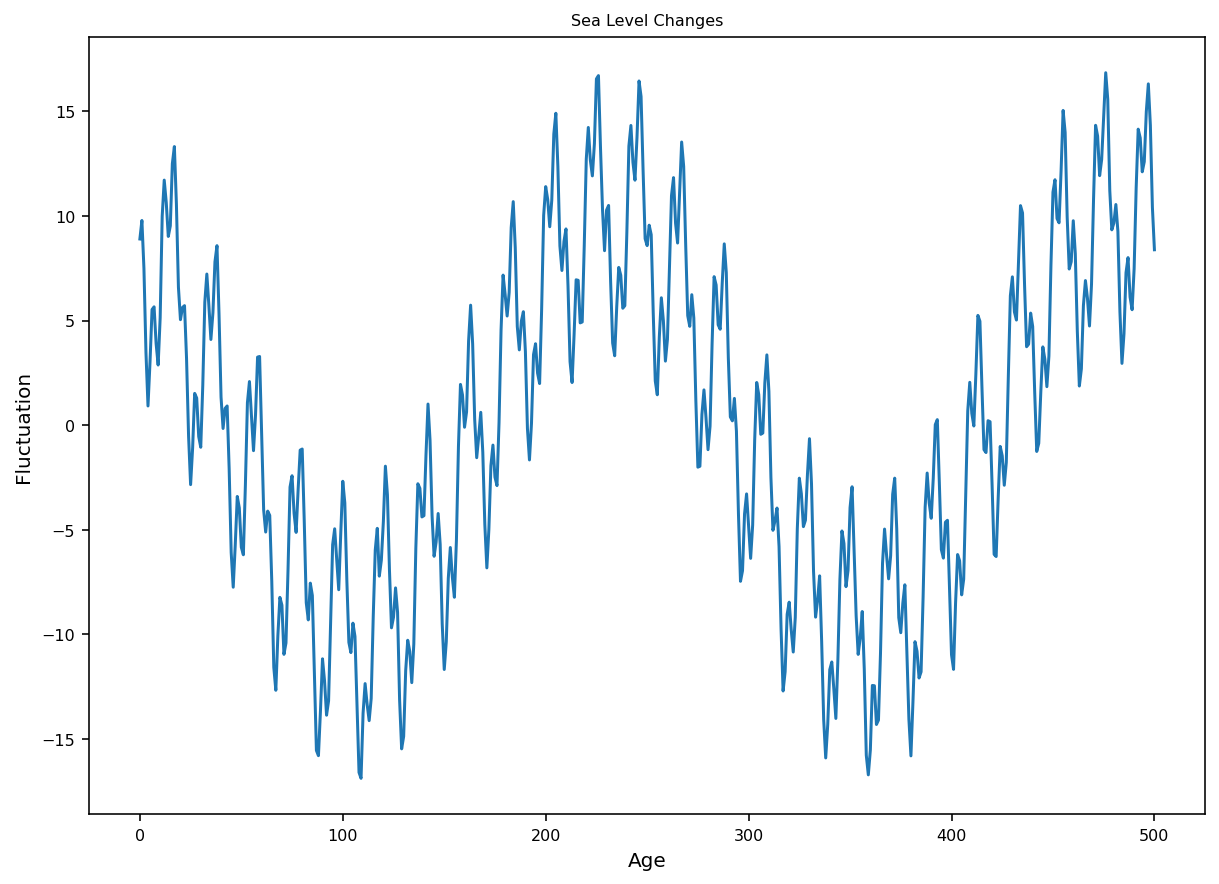

In [ ]:
plt.plot(data.Age,data.Sealevel)
plt.xlabel('Age')
plt.ylabel('Fluctuation')
plt.title("Sea Level Changes");

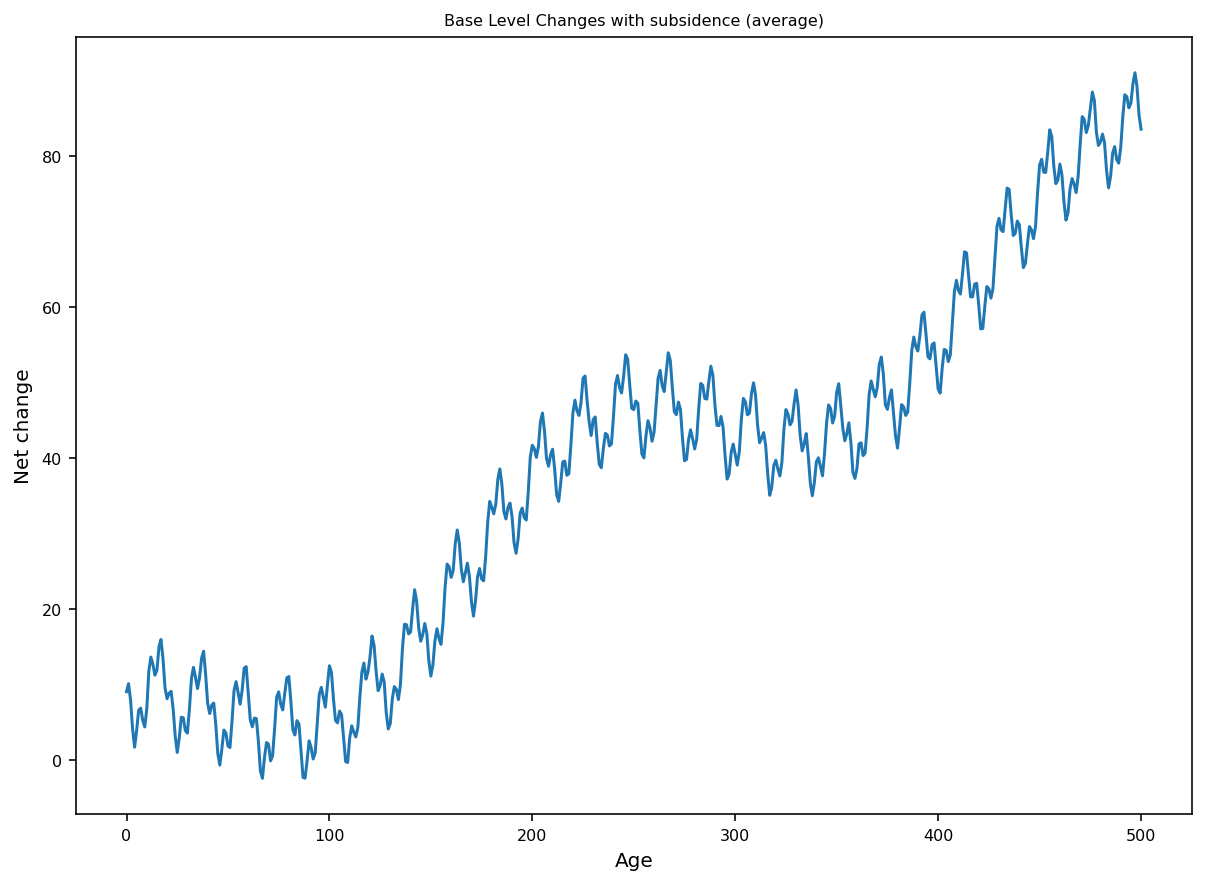

In [ ]:
plt.plot(data.Age,data.Sealevel + np.cumsum(data.Subsidence1 + data.Subsidence2)/2)
plt.xlabel('Age')
plt.ylabel('Net change')
plt.title("Base Level Changes with subsidence (average)");

# Routines

### Subsidense
Routine for applying a shift in a series both a vertical shift and a slanted shift (rotation) can be applied.  Slant is assumed to be from left to right with positive numbers indicating an upward slant to the right.

In [ ]:
def Subsidence (input,left_shift,right_shift):
  import numpy as np
  import pandas as pd
  # apply the degree of subsidense
  cells = len(input)
  shift = np.linspace(left_shift,right_shift,cells)
  output = input + shift
  return output

## Base level change


 1:5000 for coastal plain 

 ### Up to the left


In [ ]:
def Baselevel_up_left(bottom,datum=0,grade=5000,size=200):
  import numpy as np
  import pandas as pd
  cells = len(bottom)
  output = np.linspace(size/grade*cells+datum, datum, cells)
  return output

Base Leve up expected on the coastal plain out to the shoreface.  Base level down expected offshore and input length would be a factor of transition (TB, FWB, SWB) depth.
- 1:400 from shoreface to TB 
- 1:200 from TB to FWB
- 1:600 from FWB to SWB
- then curved to the offshore
- 1:10000 but amount of sediment available limited by grain size and amount of model remaining

### Down to the right

In [ ]:
def Baselevel_down_right (bottom,datum,grade,size=200):
  import numpy as np
  import pandas as pd
  cells = len(bottom)
  output = np.linspace(datum, datum-size/grade*cells, cells)
  return output

###Profile
Create a default profile across the model after determining the correct shoreface (SF).

In [ ]:
def Profile(surface,SFlt,i,size=200):
  import numpy as np
  import pandas as pd

  # Display the coastal plain (up to left) and establish the first shoreface slope
  output = surface.copy()
  output[0:SFlt] = Baselevel_up_left(output[0:SFlt],0,5000,size)
  output[SFlt:] = Baselevel_down_right(output[SFlt:],0,400,size)

  # Change the shoreface slope below the tidal base
  TBlt = output[output <= -data.TB[i]].index.values[0]  
  output[TBlt:] = Baselevel_down_right(output[TBlt:],output[TBlt-1],200,size)

  # Change again to a more gentle slope below FWB
  FWBlt = output[output <= -data.FWB[i]].index.values[0]  
  output[FWBlt:] = Baselevel_down_right(output[FWBlt:],output[FWBlt-1],600,size)

  # Start curving the slop below the SWB
  SWBlt = output[output <= -data.SWB[i]].index.values[0]  
  output[SWBlt:] = Baselevel_down_right(output[SWBlt:],output[SWBlt-1],2000,size)

  SWB2lt = output[output <= -data.SWB[i]*1.2].index.values[0]  
  output[SWB2lt:] = Baselevel_down_right(output[SWB2lt:],output[SWB2lt-1],5000,size)

  # After 50% below SWB flatten the offshore to 1:10000
  OS1lt = output[output <= -data.SWB[i]*1.5].index.values[0]  
  output[OS1lt:] = Baselevel_down_right(output[OS1lt:],output[OS1lt-1],10000,size)

  return output,TBlt,FWBlt,SWBlt,SWB2lt,OS1lt

## Deposition

Deposit sediments between existing elevation (Base) and the baselevel (Top). Initial baselevel is determine by where the existing sealevel change would first intercept the base.  

###Coastal Plain Deposition

In [ ]:
def Deposition (top,bottom,SedInput,SedVol,size=200):
  # Deposit sediment between top and base but don't change the top profile
  import numpy as np
  import pandas as pd
  cells = len(top)

  outVolume = top - bottom
  outVolume[outVolume <= 0] = 0

  Volume = np.sum(outVolume) * size
  sed = SedInput - Volume
  if sed <= 0 : sed = 0
  outLith = np.linspace(1,sed/SedVol,cells)
  if sed <= SedInput*0.4: sed = SedInput*0.4

  return outLith, sed


Repeat Depositional2 as long as the input contain sufficent coarse sediment to prograde the shoreline and aggrade the coastal plain (increase base level). The cutoff for course sediment used for the model is consider to be 30% of the input sediment (sedRemain/SedVol = CG_cutoff)    

Should the CP fill with SedRatio = sedRemain/SedVol > CG_cutoff repeat DepositionAggrade raising baselevel while stepping forward on cell.  Continue until <= CG_cutoff

When SedRatio reaches CG_cutoff extrapolate to the right: ForeShore, UpperShore, LowerShore, Nearshore (providing SedRatio > .33) and fill the volume between top & Base (gravity flow consider to be dominate)

###Shoreface

In [ ]:
def DepositionSF(top,bottom,SedInput,SedVol,size=200):
  import numpy as np
  import pandas as pd

  inLith = SedInput/SedVol
  cells = len(top)
  
  if SedInput > 0:  
    topout = top
    outVolume = top - bottom
    outVolume[outVolume <= 0] = 0

    Volume = np.sum(outVolume) * size
    if Volume > 0:
      sed = SedInput - Volume
      if sed <= 0:

        sedUnder = Volume/SedInput - 1
        Vcorrection = np.linspace(1,(1-2*sedUnder),cells)
        outVolume = outVolume*Vcorrection
        outVolume[outVolume <= 0] = 0
        topout = bottom + outVolume
        sed = 0
      outLith = np.linspace(inLith,sed/SedVol,cells)
    else:
      sed = SedInput
      topout = bottom
      outLith = np.linspace(inLith,inLith,cells)
  else:
    sed = SedInput
    topout = bottom
    outLith = np.linspace(inLith,inLith,cells)
  return topout, outLith, sed

###Offshore 
Deposition of fine grain sediment using a mixture of gravity & suspension 

In [ ]:
def DepositionOS(top, bottom, SedInput, SedVol, FstPt, SuspP=0.33, size=200):
  import numpy as np
  import pandas as pd

  inLith = SedInput/SedVol    # determine the input grain size for the FstPt
  SedInput = SedInput/size
  cells = len(top)            # number of model cells representing the offshore
  length = cells              # offshore length
  VolExcess = 0

  if cells <= 0: print('Offshore has zero lenght')
  if SedInput > 0:
    # Setup
    Vol = top - bottom              # space available for sediment (BL to starting topography)
    Vol[Vol < 0] = 0                # if BL below the topography set to zero
    FptThickness = Vol[FstPt]       # thickness at first offshore point  
    FptTop = top[FstPt]             # bsl depth of the first point
    FptDepth = bottom[FstPt]        # seafloor depth of the first point
    EdgeThickness = Vol.iloc[-1]    # thickness at the edge of the model (generally always the thicks point)
    EdgeDepth = bottom.iloc[-1]          # seafloor depth of the end of model
    if EdgeThickness <=0 : print("No thickness at the edge of the model")

    # determine the space available to receive sediment
    VolAvailable = np.sum(Vol)      
    if VolAvailable >0: 
      # Check for potential model errors
      if SedInput <=1:
        print('Zero sediment passed to the offshore')
        SedInput = 1
      if length <=100:
        print('Near the edge of the model')
        if length <=0: print('Error zero length encountered')
      if VolAvailable <= SedInput:
        print('Not enought space for all the sediment')
        print('OS Sediment lost outside of model',100*np.round((1-VolAvailable/SedInput),1),'%')
        VolExcess = SedInput - VolAvailable
        SedInput = VolAvailable
        if SedInput <=0 : SedInput = 0

      # Divide out the suspension input 
      SedSuspension = SedInput*SuspP
      # Determine the fraction of the volume required for the sediment
      OSfactor = SedInput/VolAvailable  #Fraction of space available to be filled
      SuspFraction = OSfactor*SuspP            #Suspension is filled from the model edge into the FstPt
      # Deposit the suspension flow from model edge thinning at the first point for the offshore (FstPt)
      VolSusp = Vol * SuspFraction
      NewBottom = bottom + VolSusp
      VolSusp = NewBottom - bottom
      VolUsed = np.sum(VolSusp)
 
      # Determine the volume left to deposited as bed load (wedge outward from first point)
      SedBedload = SedInput - VolUsed
      if SedBedload <= SedInput*(1-SuspP)/2:
        print('Sediment bed load need to be supplemented') 
        SedBedload = SedInput*(1-SuspP)

      Vol = top - NewBottom           # space available for sediment (BL to starting topography)
      Vol[Vol < 0] = 0                # if BL below the topography set to zero  
      VolAvailable = np.sum(Vol)      # determine the space available for the wedge  
      VolOut = np.linspace(0,0,cells) # volume of the bed load wedge

      # Deposit the remain bedload as a wedge.
      if (SedBedload*2 < (VolAvailable - 1)) & (VolAvailable > 0):   #
        #print('Create a wedge outward but not to the model edge')
        VolSum = np.cumsum(Vol)
        # Determine the point that the bedload triangle should end
        BLpt = VolSum[VolSum >= SedBedload*2].index.values[0]

        BLpt = BLpt - FstPt

        # Create bed load wedge
        WedgePerC = np.linspace(10,0,len(VolOut[:BLpt]))  # Create bed load wedge
        WedgePerC = np.sqrt(WedgePerC)/np.sqrt(10)
        WedgeVol = np.sum(Vol[:BLpt]*WedgePerC)

        WedgePerc = WedgeVol/SedBedload
        WedgeCorr = np.linspace(1,WedgePerc/2,len(VolOut[:BLpt]))
        VolOut[:BLpt] = Vol[:BLpt]*WedgePerC*WedgeCorr
        NewBottom[:BLpt] = NewBottom[:BLpt] + VolOut[:BLpt] # add the wedge to VolOut
        offset = FptTop - NewBottom.iloc[0]
        if offset > 0:print('Disjoint at transition to wedge',offset)
      else:   # 
        print('Offshore wedge need to go to end of the model')
        SedSurplus =   VolAvailable - 2*SedBedload
        SurplusFraction = SedSurplus/VolAvailable
        if SurplusFraction <=0 : 
          print('Needs to fill 100% of the offshore with sediment')
          NewBottom = top
        else:
          EdgeNdepth = NewBottom.iloc[-1]
          EdgeTop = top.iloc[-1]
          EdgeThickness = EdgeTop - EdgeNdepth
          EdgeWdepth = EdgeThickness*SurplusFraction
          NewBottom = np.linspace(FptTop,EdgeTop - EdgeWdepth,cells)
      top = NewBottom 
      outLith = np.linspace(inLith,0,cells)
    else:
      print('Zero space to deposit offshore sediment')
      top = bottom
      outLith = np.linspace(inLith,inLith,cells)
  else:
    top = bottom
    outLith = np.linspace(inLith,inLith,cells)
  return  top, outLith

###Coastal Dunes deposits

In [ ]:
def DuneDeposition (top, lith, env, SedInput, height=3, size=200, GS=CG_cutoff):
  import numpy as np
  import pandas as pd 

  #Create Profile for the dune
  bsl = Baselevel_up_left(top,0,200,size)
  DUNElist = np.where(np.isclose(bsl, height,0.25))
  #DUNEpt = bsl[bsl >= height].index.values[0]
  DUNEpt = DUNElist[-1][-1]
  bsl[:DUNEpt] = Baselevel_up_left(bsl[:DUNEpt],height,-5000,size)

  #Determine available volume for the dune
  vol = bsl - top
  vol[vol <0] = 0

  #Deposit material onto the coastal plain and return surplus 
  volAvailable = np.sum(vol)
  if volAvailable > SedInput:
    vol = vol * SedInput/volAvailable
    sedOver = 0
  else:
    sedOver = SedInput - volAvailable

  lith[vol > 0] = GS
  env[vol > 0] = 2
  output = top + vol
  return output, lith, env, sedOver

###Turbidite Deposition

In [ ]:
def TurbiditeDeposition (bottom, lith, env, SedInput, Fpt, size=200, GS=CG_cutoff):
  import numpy as np
  import pandas as pd 

  output = bottom.to_numpy()
  cells = len(output) # number of model cells available for a turbidite
  TBlen = cells           
  SedInput = SedInput/size
  # Create base level for deposition above offshore sediments
  datum = bottom.iloc[0]
  bsl = bottom
  bsl = Baselevel_down_right(output,datum,30000,size)

  #print('Determine available volume for the Turbidite')
  Vol = bsl - output
  Vol[Vol <0] = 0
  Vol[np.isnan(Vol)] = 0
  VolSum = np.cumsum(Vol)
  Wedge = np.linspace(0,0,cells)

  #print('Find volume available')
  VolMax = VolSum[-1]
  #print('Create a turbidite wedge to deposit')
  if VolMax > SedInput*2: 
    #print('Create from filling 100 to 0% (trianglar)')
    VolOver = np.where(VolSum >= SedInput*2) # floating-point
    TBlen = VolOver[0][0]
    WedgePerc = np.linspace(1,0,TBlen)  
    Wedge[:TBlen] = Vol[:TBlen]*WedgePerc

  elif VolMax > SedInput:  
    print('enough space but needs to go to edge of model')
    WedgePerc = np.linspace(1,SedInput/VolMax/2,len(Vol))  
    Wedge = Vol*WedgePerc

  else:
    print('Not enough space for depositing the Turbidite')
    Wedge = Vol
    print('The amount that sediment used was', np.round(VolMax/SedInput*100),'%')

  lpt = Fpt + TBlen
  lith[Fpt:lpt] = GS
  env[Fpt:lpt] = 8
  output = output + Wedge
  return output, lith, env

Gravity Deposition

In [ ]:
def GravityDeposition (bottom, lith, env, SedInput, SLpt, size=200):
  import numpy as np
  import pandas as pd 

  output = bottom.to_numpy()
  cells = len(output) # number of model cells available for a turbidite
  TBlen = cells           
  SedInput = SedInput/size
  # Create base level for deposition above offshore sediments
  datum = bottom.iloc[0]
  bsl = bottom
  bsl = Baselevel_down_right(output,datum,20000,size)

  #print('Determine available volume for the Turbidite')
  Vol = bsl - output
  Vol[Vol <0] = 0
  VolSum = np.cumsum(Vol)
  Wedge = np.linspace(0,0,cells)

  #print('Find volume available')
  VolMax = VolSum[-1]

  #print('Create a turbidite wedge to deposit')
  if VolMax > SedInput*2: 
    #print('Create from filling for slump 100 to 0% (trianglar)')
    VolOver = np.where(VolSum >= SedInput*2) # floating-point
    TBlen = VolOver[0][0]
    WedgePerc = np.linspace(1,0,TBlen)  
    Wedge[:TBlen] = Vol[:TBlen]*WedgePerc

  elif VolMax > SedInput:  
    #print('GE enough space but needs to go to edge of model')
    WedgePerc = np.linspace(1,SedInput/VolMax/2,len(Vol))  
    Wedge = Vol*WedgePerc

  else:
    print('Not enough space for depositing the Gravity Slump')
    Wedge = Vol
    print('The amount that sediment used was', np.round(VolMax/SedInput*100),'%')

  lpt = SLpt + TBlen
  lith[SLpt:lpt] = 0.5
  env[SLpt:lpt] = 7
  output = output + Wedge
  return output, lith, env

##Erosion 

###Fluvial Channel 

In [ ]:
def FLerosion (top, bottom, lith, Rdepth):  
  import numpy as np
  import pandas as pd 

  cells = len(top)
  erosion = bottom.copy()
  vol = bottom - top
  vol[vol<0] = 0
  vol[vol> Rdepth] = Rdepth
  hardness = (1.0-lith/4)  #erode 100% of soft sediment and only 75% of coarse

  #erosion on the profile varies in and out of the plain of the model
  vol_cut = np.random.randint(0,100,cells)

  #Smooth the erosion across 3 cells down to the depth of Rdepth  
  vol_cut = (np.roll(vol_cut,-1)+vol_cut+np.roll(vol_cut,1))/300.0*vol*hardness*FluvialScaler 

  # add the eroded vol_cut when the top/bsl is below the bottom
  erosion = erosion - vol_cut

  # estimate the volume removed (1D)
  addVol = np.sum(bottom-erosion)

  return erosion, addVol

###Shoreface erosion

In [ ]:
def SFerosion (top, bottom, lith, rFWB, rSWB2):  
  import numpy as np
  import pandas as pd 

  cells = len(top)
  erosion = bottom.copy()   # Bottom should be the BSL profile (deposition below erosion above)
  vol = bottom - top
  vol[vol<0] = 0
  softness = (1.0-lith**3)  # erode 100% of soft sediment (lith = 0) 50% of SF sands (Lith = 0.70) and preserve the coast plain (lith = 0)

  StormErosion = rFWB + bottom                 # determien where above FWB 
  StormErosion[StormErosion>0] = 0             # positive number indicates above rdepth FWB - 100% erosion 0 perserved
  StormErosion = StormErosion/rSWB2            # rdepth2=SWB create a gradient to SWB after below this errors will be limited to 10%
  StormErosion[StormErosion <-1] =-1           # values less than -1 would indicate below SWB where we want to minimize erosion
  StormErosion = 1 + StormErosion              # StormErosion is a negative number adding 1 mean 0 becomes 100% erosion
  StormErosion[StormErosion < 0.1] = 0.1       # set erosion to a minimum of 10% even below SWB
  StormErosion = np.sqrt(StormErosion)         # Create a curved gradient

  # add the eroded vol_cut when the top is below the bottom (bsl)
  erosion = erosion - vol*StormErosion*softness*ErosionScaler

  # estimate the volume removed (1D)
  addVol = np.sum(bottom-erosion)

  return erosion, addVol

###Gravity Erosion 
Predominately offshore occurring after critical slope happens

In [ ]:
def GRerosion (top, bottom, env, trigger = 4, failure = 3, size=200):
  import numpy as np
  import pandas as pd 

  cells = len(top)
  fault = top.copy()
  failure = size/failure
  Vol_cut = 0
  FLpt = 0
  #Grade of 6 in approximately a 10 degree slope, 2 approximately 26
  slope = top.shift(1) - top  # Calculate slope 
  slope[0] = slope[1] # populate the first cell with the second
  slope_max = np.max(slope[env > 4]) # determine the maximum slope seaward of the shoreline
  if slope_max >= trigger: 
    #print('Slope failure triggered')
    # Point of failure needs to be beyond the shoreline
    FLpt = slope[env > 4][slope[env > 4] == slope_max].index.values[0]
    #print('Create the failure surface (up to the left)')
    fault[0:FLpt] = Baselevel_up_left(top[:FLpt],top[FLpt],failure,size)    
    cut = top - fault
    cut[cut <= 0] = 0
    #print('Determine the amount of material removed')
    Vol_cut = np.sum(cut)

    UPPERpt = cut[cut > 0].index.values[0]
    scarpLength = FLpt - UPPERpt

    # Remove the slumped materal from above the failure
    top[UPPERpt:FLpt] = fault[UPPERpt:FLpt]
    # Update the bottom when its now below the top
    bottom[top <= bottom] = top[top <= bottom]

    # Move the failure point toward the top point
    FLpt = FLpt - int(scarpLength/3)
    Vol_cut = Vol_cut*size

  return top, bottom, FLpt, Vol_cut

##Sediment Compaction

In [ ]:
def Compaction (top,bottom,lith):
  import numpy as np
  import pandas as pd 

  vol = top-bottom
  vol[vol<0] = 0

  #Use lith to determine the degree of compaction
  compact = (0.5+(lith**2)/2)  #compact shales (50%) and less for sandstone (25%)
  output = bottom + vol*compact
  return output  

In [ ]:
data['BaseLChange'] = 0
data['CPerosion'] = 0
data['SFposition'] = SFpt
data['SFerosion'] = 0

In [ ]:
data.describe()

Age  Subsidence1  Subsidence2       Fault       Sediment  \
count  501.000000   501.000000   501.000000  501.000000     501.000000   
mean   250.000000    -0.099707     0.399863    0.898204  492994.218378   
std    144.770508     0.004931     0.020125    0.302683   23932.188161   
min      0.000000    -0.113167     0.345645    0.000000  393110.988926   
25%    125.000000    -0.102982     0.386513    1.000000  477760.077667   
50%    250.000000    -0.099946     0.399829    1.000000  492944.020032   
75%    375.000000    -0.096479     0.413882    1.000000  509334.133208   
max    500.000000    -0.085586     0.458165    1.000000  553980.788827   

         Sealevel          TB         FWB         SWB  BaseLChange  CPerosion  \
count  501.000000  501.000000  501.000000  501.000000        501.0      501.0   
mean     0.001060    1.249162    3.002183    7.998680          0.0        0.0   
std      8.120793    0.062161    0.152198    0.377728          0.0        0.0   
min    -16.883664    1.060628    2.495275    6.672240          0.0        0.0   
25%     -6.270052    1.205840    2.903787    7.740811          0.0        0.0   
50%      0.022625    1.250298    3.001870    7.990799          0.0        0.0   
75%      6.234079    1.289628    3.097033    8.247988          0.0        0.0   
max     16.845173    1.447829    3.460482    9.300601          0.0        0.0   

       SFposition  SFerosion  
count       501.0      501.0  
mean        200.0        0.0  
std           0.0        0.0  
min         200.0        0.0  
25%         200.0        0.0  
50%         200.0        0.0  
75%         200.0        0.0  
max         200.0        0.0

# Run thru the input paramaters

In [ ]:
istep = 1
dfprofile[0]=dfelev[0]
while istep < Steps:
  print(istep)
  if np.any(np.isnan(dfelev[istep - 1])): print(istep,'nan found in dfelev')
  if np.any(np.isnan(dfbase[istep - 1])): print(istep,'nan found in dfbase')
  if np.any(np.isnan(dflith[istep - 1])): print(istep,'nan found in dflith')

   # apply the lithospheric subsidence and eustacy changes
  Shift = np.linspace(data.Subsidence1[istep],data.Subsidence2[istep],nCells)
  # apply fault movement
  Foffset = FoffsetPturn*data.Fault[istep]

  dfbase[istep] = dfelev[istep-1] - Shift - Foffset - data.Sealevel[istep] + data.Sealevel[istep-1]
  data['BaseLChange'][istep] = -np.mean(Shift)- data.Sealevel[istep] + data.Sealevel[istep-1]

  dfbref[istep] = dfbase[istep]
  dfelev[istep] = dfbase[istep]
  SedRemain = data.Sediment[istep]  # Change code but again set initial sed to input
  SedInput = data.Sediment[istep]   # Change code but again set initial sed to input
  VolumeAdd = 0                     # Start with no additional volume

  # determine the first pt at or below sea level
  SFpt = dfelev[istep][dfbase[istep] <= 0].index.values[0]
  SFpt = SFpt - 1

  # Make sure that the shoreface doesn't move outside the model to the left
  if SFpt <= 10: SFpt = 10

  # establish the coastal plain initial baselevel
  dfelev[istep][0:SFpt] = Baselevel_up_left(dfbase[istep][0:SFpt],0,5000,Csize)
  dfelev[istep][SFpt:] = 0

  # apply fluvial erosion if the new base level is below the shifted base
  dfbase[istep][0:SFpt], VolumeAdd = FLerosion(dfelev[istep][0:SFpt], 
                                               dfbase[istep][0:SFpt],
                                               dflith[istep][0:SFpt], 
                                               data.FWB[istep]/2)

  # add any additional volume created by erosion to model
  if VolumeAdd > 0:
    #print('CP erosion',np.round(VolumeAdd*Csize/SedInput*100,2),'%')
    data['CPerosion'][istep] = VolumeAdd*Csize/SedInput*100
  else:
    VolumeAdd = 0
  SedRemain = SedRemain + VolumeAdd*Csize #scale up the additonal volume 
  if SedRemain <= 0: print('Out of sediment in initial coastal plain')

  # correct the elevation if below the base after erosion
  dfelev[istep][dfelev[istep] <= dfbase[istep]] = dfbase[istep][dfelev[istep] <= dfbase[istep]]
  
  # fill Coastal plain to the initial shoreface
  dflith[istep][0:SFpt], SedRemain = Deposition(dfelev[istep][0:SFpt],
                                              dfbase[istep][0:SFpt],
                                              SedRemain,
                                              SedInput,Csize)
  dflith[istep][SFpt:] = np.linspace(SedRemain/data.Sediment[istep],0,nCells-SFpt)

  # integrate/prograte until the coast plain has deposited all coarse CP sediment
  while SedRemain/SedInput >= CG_cutoff:
    #print('establish new baselevel after prograding',SFpt)
    SFpt +=  1
    dfelev[istep][0:SFpt] = Baselevel_up_left(dfelev[istep][0:SFpt],0,5000,Csize)
    dfelev[istep][0:SFpt][dfelev[istep][0:SFpt] <=dfbase[istep][0:SFpt]] = dfbase[istep][0:SFpt][dfelev[istep][0:SFpt] <=dfbase[istep][0:SFpt]]
    dfelev[istep][SFpt:] = 0

    dfelev[istep][0:SFpt], dflith[istep][0:SFpt], SedRemain = DepositionSF(dfelev[istep][0:SFpt],
                                         dfbase[istep][0:SFpt],
                                         SedRemain,
                                         SedInput,Csize)
    if SedRemain <= 0: print('Out of sediment well prograding SF')  
    dflith[istep][0:SFpt] = np.linspace(1,CG_cutoff,SFpt)
    dflith[istep][SFpt:] = np.linspace(SedRemain/data.Sediment[istep],0,nCells-SFpt)

  #dflith[istep][SFpt:] = np.linspace(CG_cutoff,0,nCells-SFpt)
  data['SFposition'][istep] = SFpt*Csize/1000
  dfenv[istep][:SFpt]=1
  if SedRemain <= 0:
    #print(SedRemain,SedInput) 
    print('Out of sediment during coastal plain')

  #print('Establish baselevel for offshore')
  dfprofile[istep],TBpt,FWBpt,SWBpt,SWB2pt,OS1pt = Profile(dfelev[istep],SFpt,istep,Csize)
  dfelev[istep][SFpt:] = dfprofile[istep][SFpt:]
  
  #print('Shoreface Erosion')
  dfbase[istep][SFpt:], VolumeAdd = SFerosion(dfelev[istep][SFpt:], 
                                              dfbase[istep][SFpt:], 
                                              dflith[istep][SFpt:],
                                              data.FWB[istep],data.SWB[istep])
  dfelev[istep][SFpt:][dfelev[istep][SFpt:] < dfbase[istep][SFpt:]] = dfbase[istep][SFpt:][dfelev[istep][SFpt:] < dfbase[istep][SFpt:]]
  
  # deposit 1/3 of additional volume as a dune 2/3 as turbidite
  # deposit on CP now but delay for the turbidite
  if VolumeAdd > 0: 
    #print('SF Erosion',np.round(VolumeAdd*Csize/SedInput*100,2),'%')
    data['SFerosion'][istep] = VolumeAdd*Csize/SedInput*100
    #print('Depositing Foreshore dunes')
    dfelev[istep][:SFpt], dflith[istep][:SFpt], dfenv[istep][:SFpt], sedOver = DuneDeposition(
                                          dfelev[istep][:SFpt], 
                                          dflith[istep][:SFpt],
                                          dfenv[istep][:SFpt], 
                                          VolumeAdd*(1-Tpercent), 4, Csize)
    dflith[istep][:SFpt] = np.linspace(1,CG_cutoff,SFpt)
    # add any additional volume created by erosion to model
    SedRemain = SedRemain + sedOver*Csize #scale up the additonal volume 
    SedInput = SedRemain/CG_cutoff
  #print('SF Erosion',SedRemain)

  #print('Foreshore beach deposition')
  dfelev[istep][SFpt:TBpt], dflith[istep][SFpt:TBpt], SedRemain = DepositionSF(dfelev[istep][SFpt:TBpt],
                                         dfbase[istep][SFpt:TBpt],
                                         SedRemain,
                                         SedInput,Csize)  
  if SedRemain <= 0: print('Out of sediment in tidal flat')
  dfenv[istep][SFpt:TBpt]=2
  #print('FS deposit',SedRemain)

  #print('UpperShoreFace deposition')
  dfelev[istep][TBpt:FWBpt], dflith[istep][TBpt:FWBpt], SedRemain = DepositionSF(dfelev[istep][TBpt:FWBpt],
                                         dfbase[istep][TBpt:FWBpt],
                                         SedRemain,
                                         SedInput,Csize)
  if SedRemain <= 0: print('Out of sediment in upper shoreface')
  dfenv[istep][TBpt:FWBpt]=3
  #print('US deposit',SedRemain)

  #print('LowerShoreFace deposition')
  dfelev[istep][FWBpt:SWBpt], dflith[istep][FWBpt:SWBpt], SedRemain = DepositionSF(
                                        dfelev[istep][FWBpt:SWBpt],
                                        dfbase[istep][FWBpt:SWBpt],
                                        SedRemain,
                                        SedInput,Csize)
  if SedRemain <= 0:
    SedRemain = 0 
    print('Out of sediment in lower shoreface')
  dfenv[istep][FWBpt:SWBpt]=4
  #print('LS deposit',SedRemain)

  #
  if SedRemain >= SedInput*OSfraction:
    #print('NearOffshoreFace deposition')          
    dfelev[istep][SWBpt:SWB2pt], dflith[istep][SWBpt:SWB2pt], SedRemain = DepositionSF(
                                        dfelev[istep][SWBpt:SWB2pt],
                                        dfbase[istep][SWBpt:SWB2pt],
                                        SedRemain,
                                        SedInput,Csize)
  else:
    SWB2pt = SWBpt
  if SedRemain <= 0: print('Out of sediment in near shore')
  dfenv[istep][SWBpt:SWB2pt]=5
  #print('Near Offshore',SedRemain)

  #print('Offshore1ShoreFace deposition')
  dfenv[istep][SWB2pt:]=6

  Gfraction = SedRemain/SedInput
  Goffshore = Gfraction - OSfraction 
  if Goffshore <= 0 :
    OS1pt = SWB2pt 
  else:
    SedVol2 = SedRemain*Goffshore/Gfraction

    DepVol = dfelev[istep][SWB2pt:] - dfbase[istep][SWB2pt:]
    DepVol[DepVol <= 0] = 0

    DepSumm = np.cumsum(DepVol)
    if ((SedVol2)/Csize < np.max(DepSumm) ) & (len(DepSumm) > 5):
      #print(SedVol2/Csize,DepSumm)
      OS1pt = DepSumm[DepSumm >= SedVol2/Csize].index.values[0]

      dfelev[istep][SWB2pt:OS1pt], dflith[istep][SWB2pt:OS1pt], SedRemain = DepositionSF(
                                        dfelev[istep][SWB2pt:OS1pt],
                                        dfbase[istep][SWB2pt:OS1pt],
                                        SedRemain,
                                        SedInput,Csize)
    else:
      dfelev[istep][SWB2pt:OS1pt], dflith[istep][SWB2pt:OS1pt], SedRemain = DepositionSF(
                                        dfelev[istep][SWB2pt:OS1pt],
                                        dfbase[istep][SWB2pt:OS1pt],
                                        SedRemain,
                                        SedInput,Csize)
  if SedRemain <= 0: 
    SedRemain = 0
    print('Out of sediment in offshore')
  else:
    #print('Offshore2ShoreFace wedge deposition')
    dfelev[istep][OS1pt:], dflith[istep][OS1pt:] = DepositionOS(
                                        dfelev[istep][OS1pt:],
                                        dfbase[istep][OS1pt:],
                                        SedRemain,
                                        SedInput,
                                        OS1pt)
  if np.any(np.isnan(dfelev[istep])): print(istep,'nan found in offshore')

  if VolumeAdd > 0:
    #print('Deposit turbidite') 
    TRpt = OS1pt + int((nCells-OS1pt)/2*np.random.rand())
    dfelev[istep][TRpt:], dflith[istep][TRpt:], dfenv[istep][TRpt:] = TurbiditeDeposition(
      dfelev[istep][TRpt:], 
      dflith[istep][TRpt:], 
      dfenv[istep][TRpt:], 
      VolumeAdd*Tpercent, TRpt, Csize)
  if np.any(np.isnan(dfelev[istep])): print(istep,'nan found in turbidite')

  #print('Gravity Erosion')
  dfelev[istep], dfbase[istep], GEpt, SedRemain = GRerosion(dfelev[istep], 
            dfbase[istep], dfenv[istep], 4, 1, Csize)
  if SedRemain > 0:
    dfelev[istep][GEpt:], dflith[istep][GEpt:], dfenv[istep][GEpt:] = GravityDeposition(
                dfelev[istep][GEpt:], 
                dflith[istep][GEpt:], 
                dfenv[istep][GEpt:], 
                SedRemain, GEpt, Csize)
    
  #print('Compact the sediment)
  dfelev[istep] = Compaction(dfelev[istep],dfbase[istep],dflith[istep])
  istep += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
Near the edge of the model
108
Near the edge of the model
Not enought space for all the sediment
OS Sediment lost outside of model 80.0 %
Offshore wedge need to go to end of the model
Needs to fill 100% of the offshore with sediment
Not enough space for depositing the Turbidite
The amount that sediment used was 3.0 %
109
Near the edge of the model
Not enought space for all the sediment
OS Sediment lost outside of model 100.0 %
Offshore wedge need to go to end of the model
Needs to fill 100% of the offshore with sediment
Not enough space for depositing the Turbidite
The amount that sediment used was 2.0 %
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126


##Post step deposition 

In [ ]:
data.describe().T

count           mean           std            min            25%  \
Age          501.0     250.000000    144.770508       0.000000     125.000000   
Subsidence1  501.0      -0.099707      0.004931      -0.113167      -0.102982   
Subsidence2  501.0       0.399863      0.020125       0.345645       0.386513   
Fault        501.0       0.898204      0.302683       0.000000       1.000000   
Sediment     501.0  492994.218378  23932.188161  393110.988926  477760.077667   
Sealevel     501.0       0.001060      8.120793     -16.883664      -6.270052   
TB           501.0       1.249162      0.062161       1.060628       1.205840   
FWB          501.0       3.002183      0.152198       2.495275       2.903787   
SWB          501.0       7.998680      0.377728       6.672240       7.740811   
BaseLChange  501.0      -0.148770      2.293490      -4.995376      -2.003474   
CPerosion    501.0       1.689729      1.791830       0.000000       0.296700   
SFposition   501.0      94.655090     66.660989       9.000000      43.800000   
SFerosion    501.0      14.944900     20.378380       0.000000       1.072741   

                       50%            75%            max  
Age             250.000000     375.000000     500.000000  
Subsidence1      -0.099946      -0.096479      -0.085586  
Subsidence2       0.399829       0.413882       0.458165  
Fault             1.000000       1.000000       1.000000  
Sediment     492944.020032  509334.133208  553980.788827  
Sealevel          0.022625       6.234079      16.845173  
TB                1.250298       1.289628       1.447829  
FWB               3.001870       3.097033       3.460482  
SWB               7.990799       8.247988       9.300601  
BaseLChange      -0.101287       1.580481       4.217106  
CPerosion         1.042866       2.212085       7.142627  
SFposition       65.200000     165.000000     227.800000  
SFerosion         6.619740      20.069786     127.163965

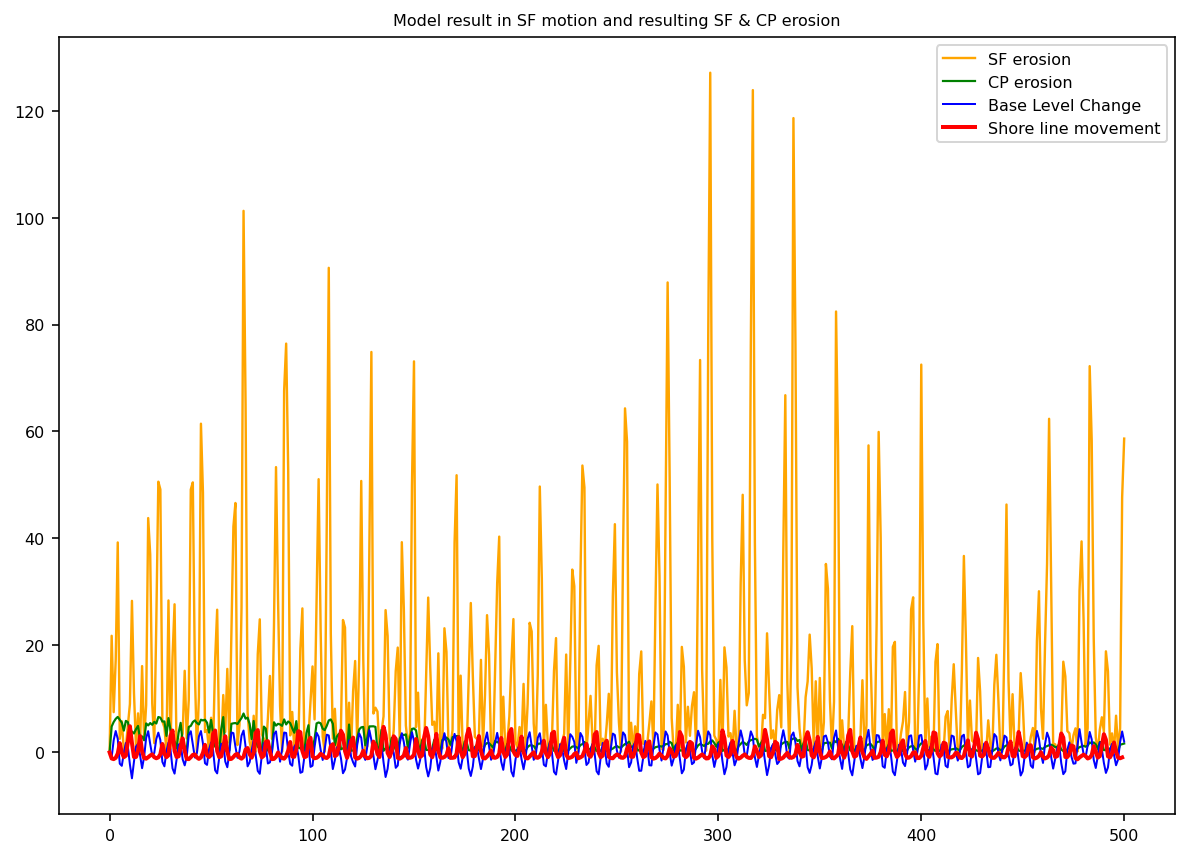

In [ ]:
#plt.fill_between(())
plt.plot(data.SFerosion,label='SF erosion',linewidth = 1.2,c='orange')
plt.plot(data.CPerosion,label='CP erosion',linewidth = 1.1,c='green')
plt.plot((data.BaseLChange),label='Base Level Change',c='blue',linewidth=1)
plt.plot((data.SFposition-data.SFposition.shift(-1))/5,label='Shore line movement',c='red',linewidth=2)
plt.legend()
plt.title('Model result in SF motion and resulting SF & CP erosion');

Calculate the bed thickness for each step

In [ ]:
dfthick = dfelev - dfbase
dfthick[:][0] = 0
dferosion = dfbref - dfbase
dferosion[:][dferosion<=0] = 0


#Finish model and output results

Create the final preserved display. Both depth below the surface along with grainsize.
dfdepth[0] = dfthick[0] - dferosion[0]
dfdepth[istep-1] - dferosion[istep] + dfthick[istep]

In [ ]:
istep = nAges - 1
dfdepth[istep] = dfelev[istep] 
erodeRemain = np.linspace(0,0,nCells)
dffacies[istep] = dflith[istep]

while istep >= 1:
  istep -= 1
  # only increment the depth if the amount of residual erosion is greater than the amount of depositional thickness
  depthChange = dfthick[istep + 1] + erodeRemain   # add the amount of sediment deposited during the step. 
  depthAdd = depthChange.copy()
  erodeRemain = depthChange.copy()
  depthAdd[depthAdd < 0] = 0    # depth to add
  erodeRemain[erodeRemain > 0] = 0  # residual erosion still to be applied to underlying layers
  dfdepth[istep] = dfdepth[istep + 1] - depthAdd
  dffacies[istep] = dffacies[istep + 1]
  dffacies[istep][depthAdd > 0] = dflith[istep][depthAdd > 0]
  erodeRemain = erodeRemain - dferosion[istep +  1]  # add the previous erosion to any residual from earlier ages
  

##Display Result

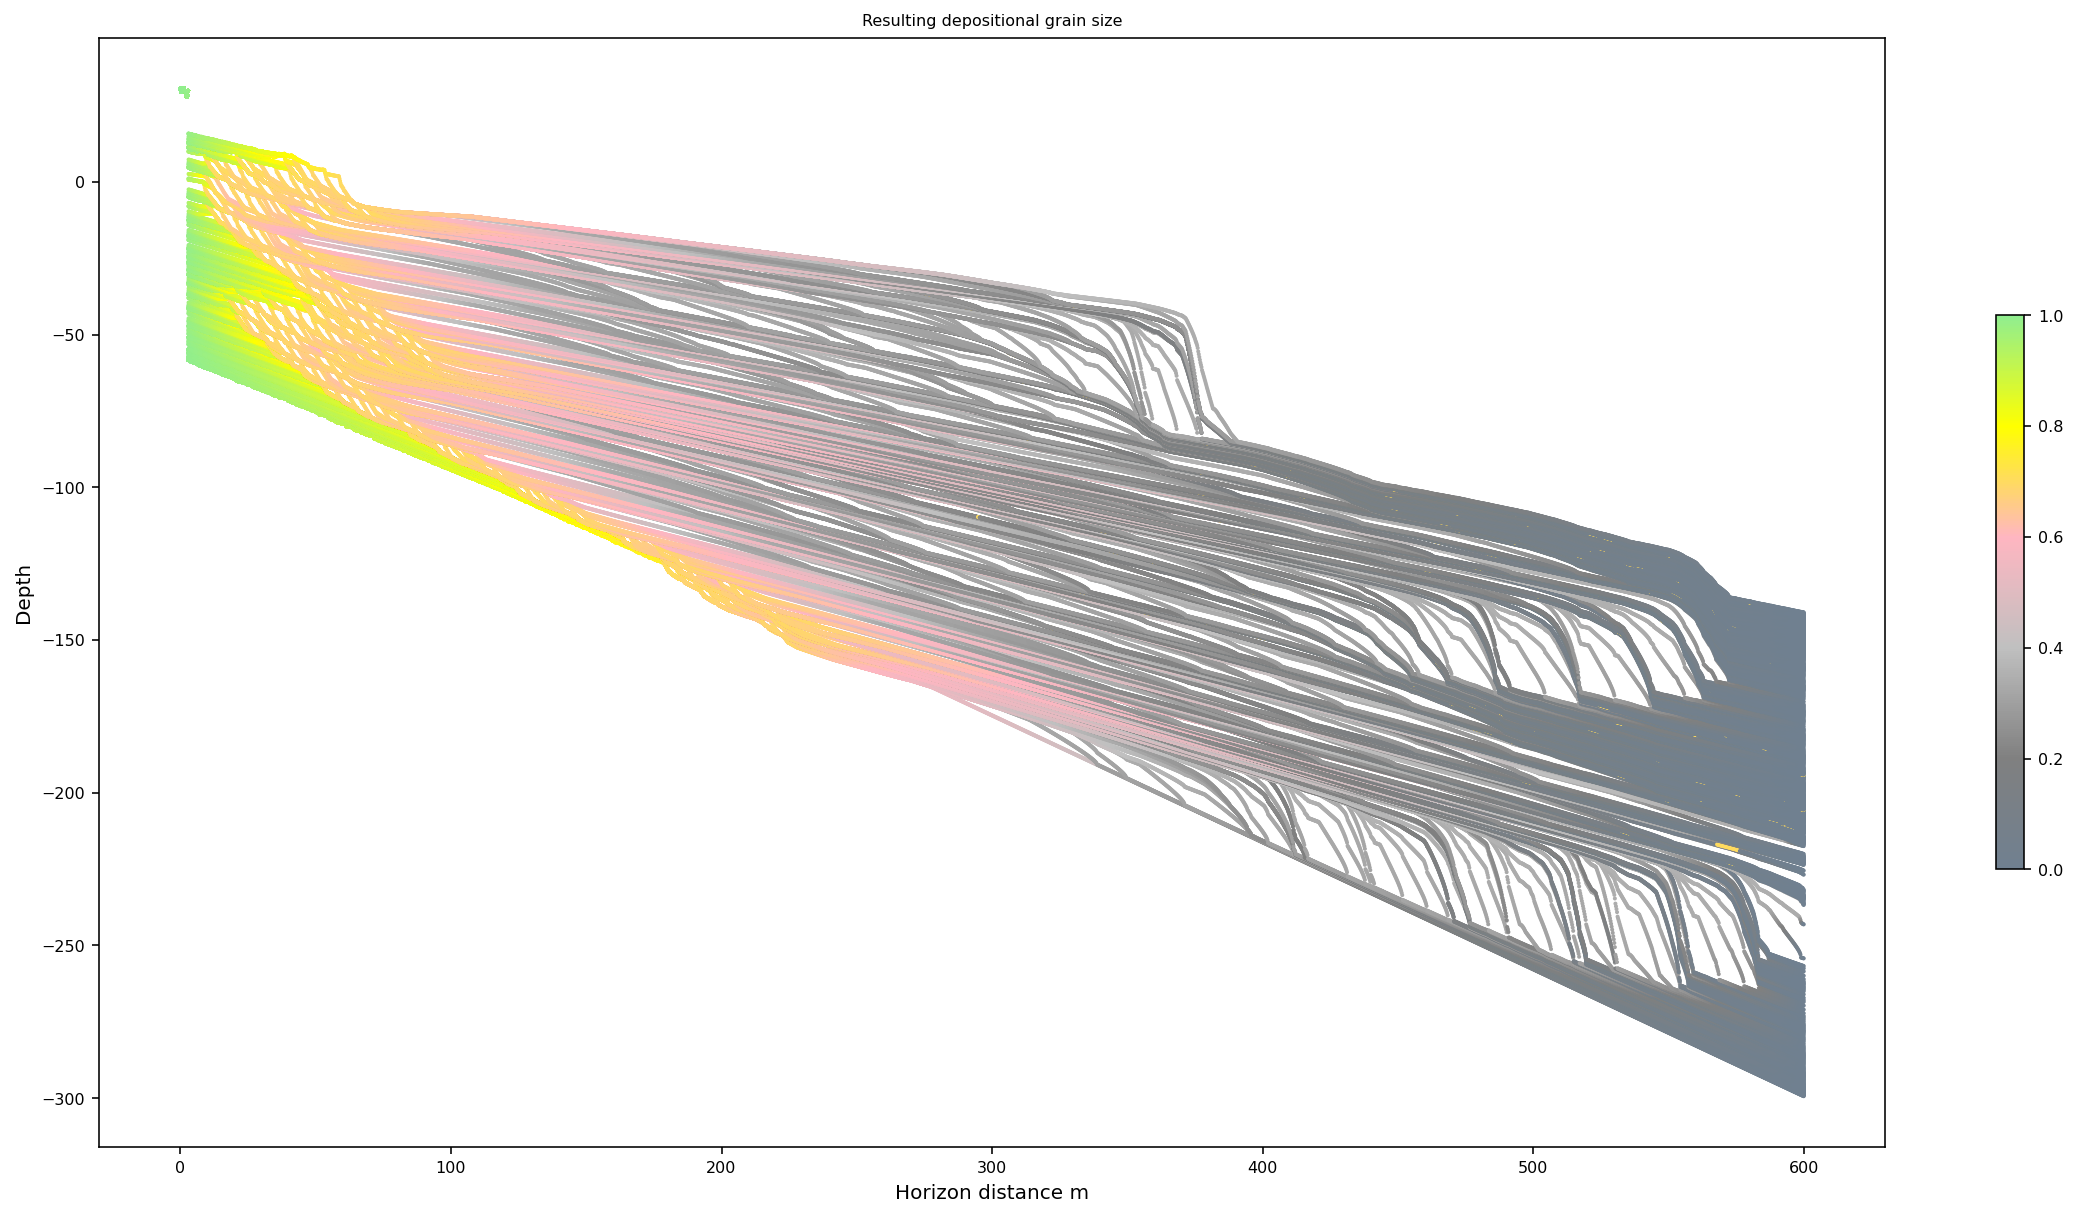

In [ ]:
istep = 0 
plt.figure(figsize=(20,10))
while istep < Steps:
  plt.scatter(xlength,dfdepth[istep],c=dflith[istep],cmap='lith_color',s=1,vmin=0, vmax=1)
  istep += 1
plt.colorbar(shrink=0.50)
plt.ylabel('Depth')
plt.xlabel('Horizon distance m')
plt.title('Resulting depositional grain size');

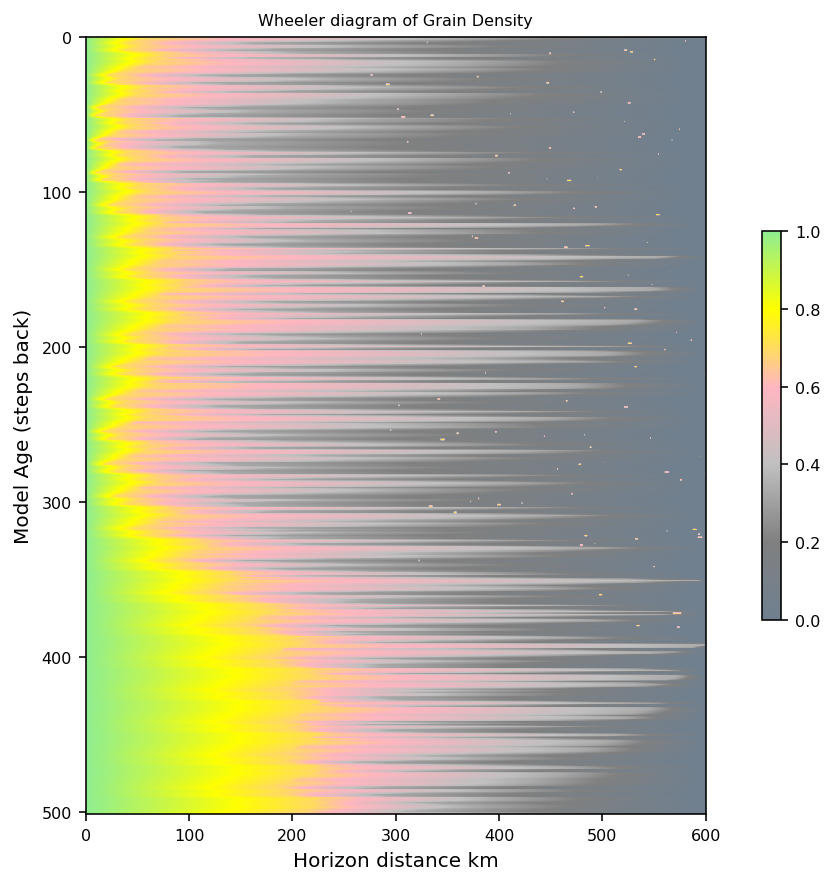

In [ ]:
plt.imshow(dflith.T,cmap='lith_color',vmin=0, vmax=1,aspect=1.5,extent=(0, nCells*Csize/1000, 0, nAges))
plt.colorbar(shrink=0.50)
plt.gca().invert_yaxis()
plt.ylabel('Model Age (steps back)')
plt.xlabel('Horizon distance km')
plt.title('Wheeler diagram of Grain Density');

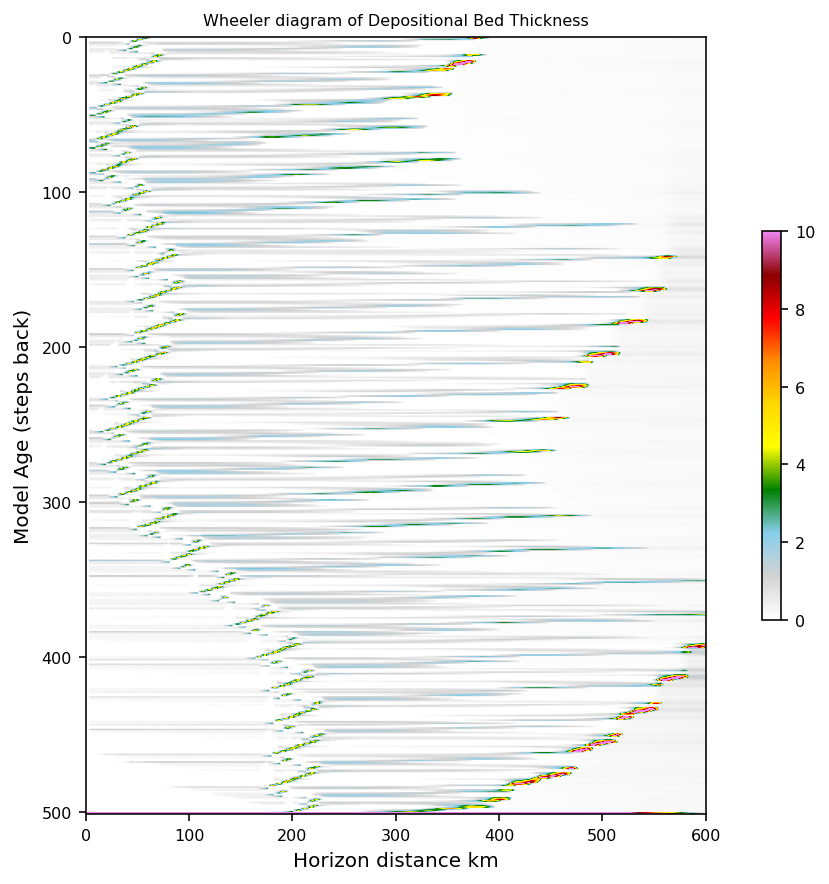

In [ ]:
plt.imshow(dfthick.T,cmap='wbgr',vmax=10,aspect=1.5,extent=(0, nCells*Csize/1000, 0, nAges))
plt.colorbar(shrink=0.50)
plt.gca().invert_yaxis()
plt.ylabel('Model Age (steps back)')
plt.xlabel('Horizon distance km')
plt.title('Wheeler diagram of Depositional Bed Thickness');

In [ ]:
print(np.min(np.min(dfthick)),np.max(np.max(dfthick)))

0.0 150.0


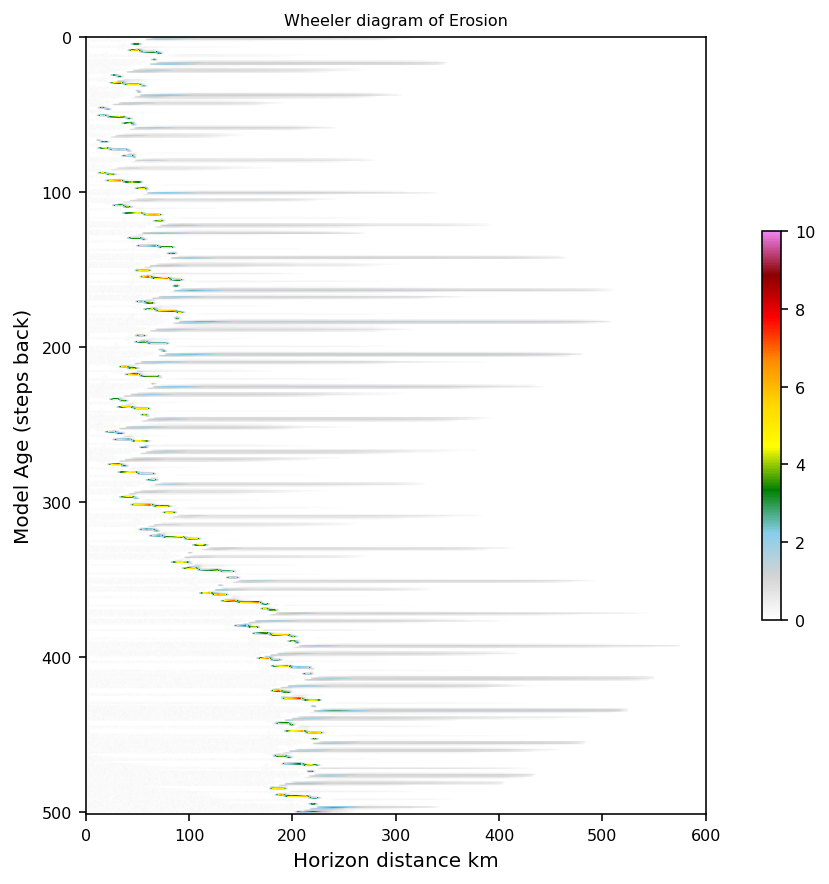

In [ ]:
plt.imshow(dferosion.T,cmap='wbgr',vmin=0, vmax=10, aspect=1.5,extent=(0, nCells*Csize/1000, 0, nAges))
plt.colorbar(shrink=0.50)
plt.gca().invert_yaxis()
plt.ylabel('Model Age (steps back)')
plt.xlabel('Horizon distance km')
plt.title('Wheeler diagram of Erosion');

In [ ]:
print(np.min(np.min(dferosion)),np.max(np.max(dferosion)))

0.0 8.567850629278373


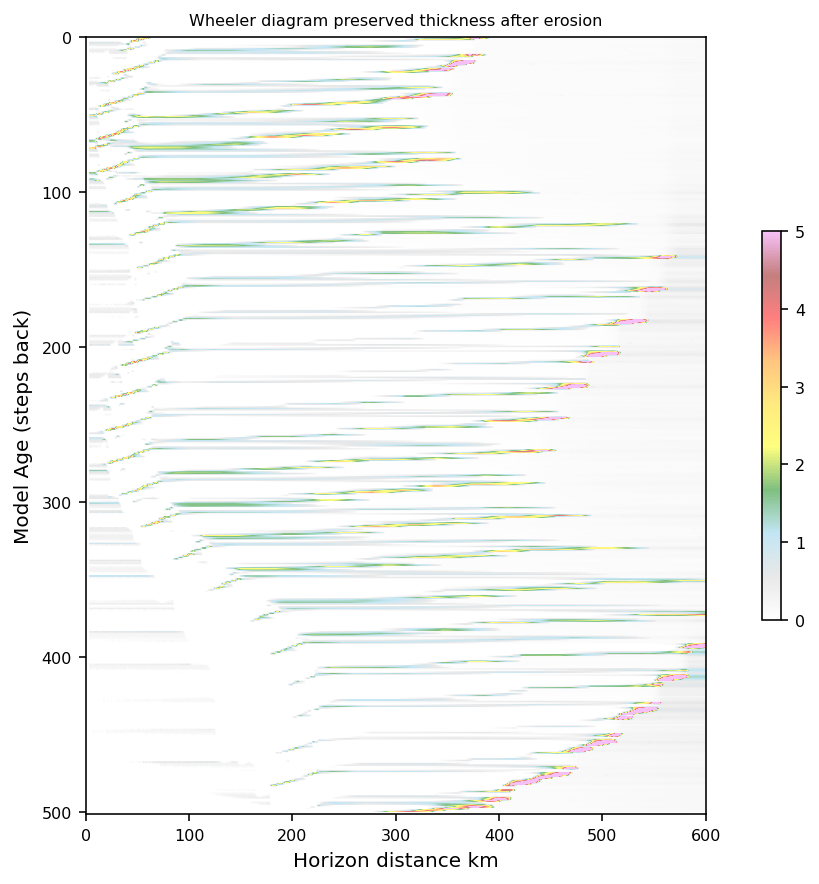

In [ ]:
plt.imshow((dfdepth - dfdepth.shift(+1,axis=1)).T,cmap='wbgr',alpha=0.5,vmax=5,aspect=1.5,extent=(0, nCells*Csize/1000, 0, nAges))
plt.colorbar(shrink=0.50)
plt.gca().invert_yaxis()
plt.ylabel('Model Age (steps back)')
plt.xlabel('Horizon distance km')
plt.title('Wheeler diagram preserved thickness after erosion');

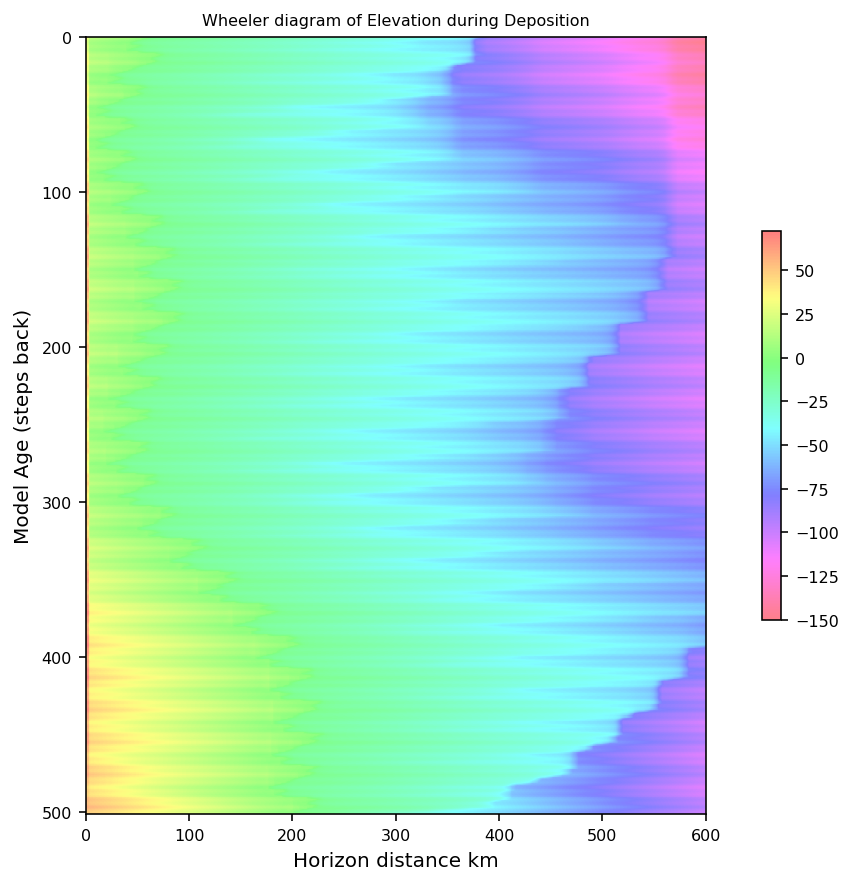

In [ ]:
plt.imshow((dfelev).T,cmap='hsv_r',alpha=0.5,vmin=-150,aspect=1.5,extent=(0, nCells*Csize/1000, 0, nAges))
plt.colorbar(shrink=0.50)
plt.gca().invert_yaxis()
plt.ylabel('Model Age (steps back)')
plt.xlabel('Horizon distance km')
plt.title('Wheeler diagram of Elevation during Deposition');

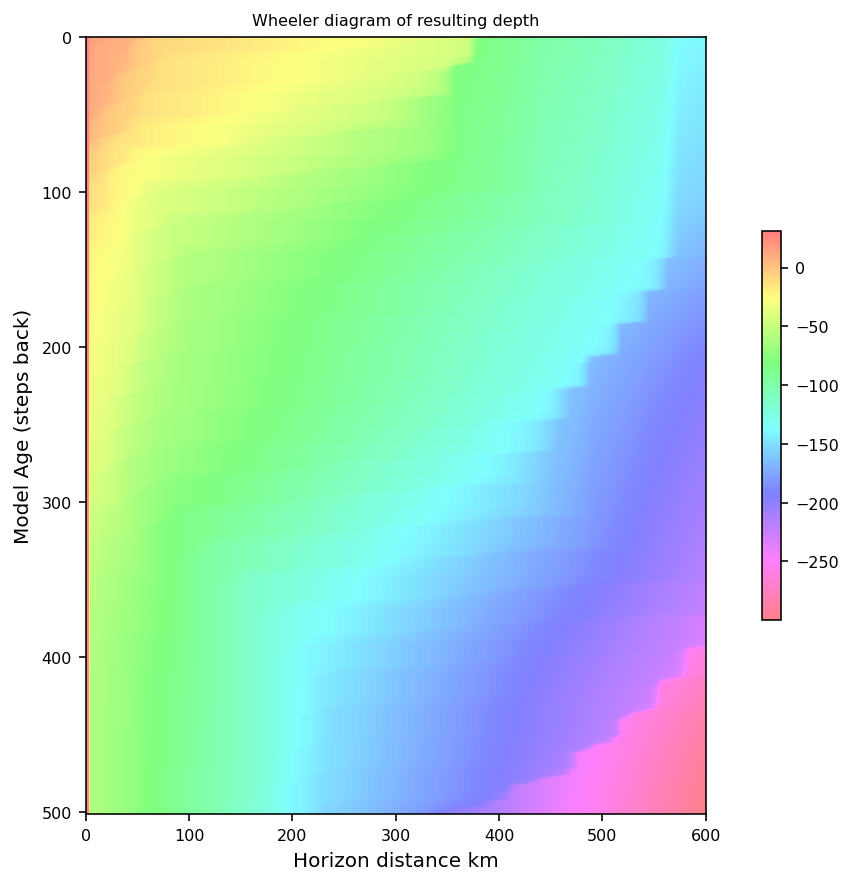

In [ ]:
plt.imshow((dfdepth).T,cmap='hsv_r',alpha=0.5,aspect=1.5,extent=(0, nCells*Csize/1000, 0, nAges))
plt.colorbar(shrink=0.50)
plt.gca().invert_yaxis()
plt.ylabel('Model Age (steps back)')
plt.xlabel('Horizon distance km')
plt.title('Wheeler diagram of resulting depth');

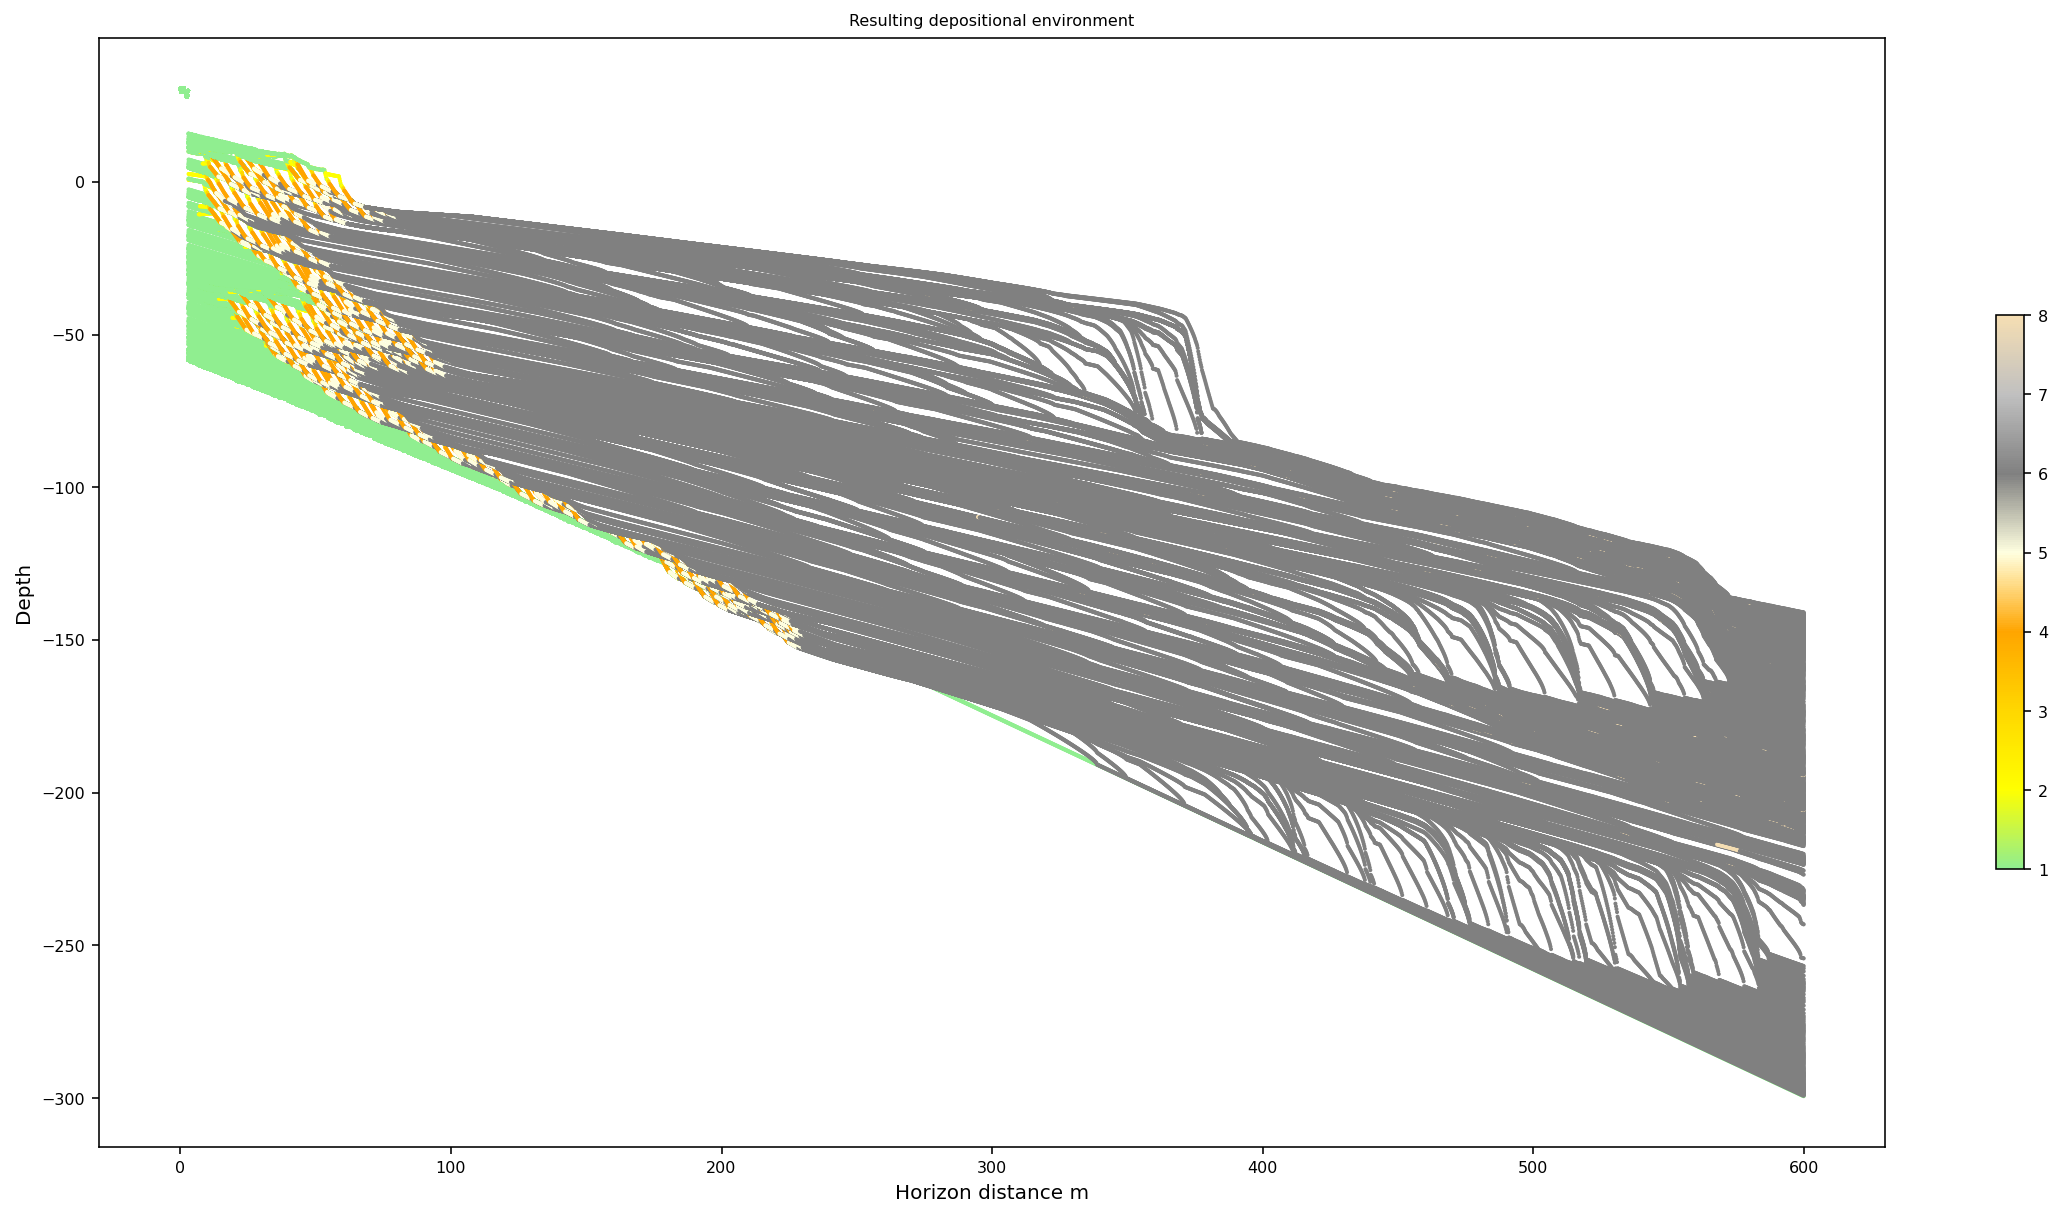

In [ ]:
istep = 0 
plt.figure(figsize=(20,10))
while istep < Steps:
  plt.scatter(xlength,dfdepth[istep],c=dfenv[istep],cmap='env_color',s=1,vmin=1,vmax=8)
  istep += 1
plt.colorbar(shrink=0.50)
plt.ylabel('Depth')
plt.xlabel('Horizon distance m')
plt.title('Resulting depositional environment');

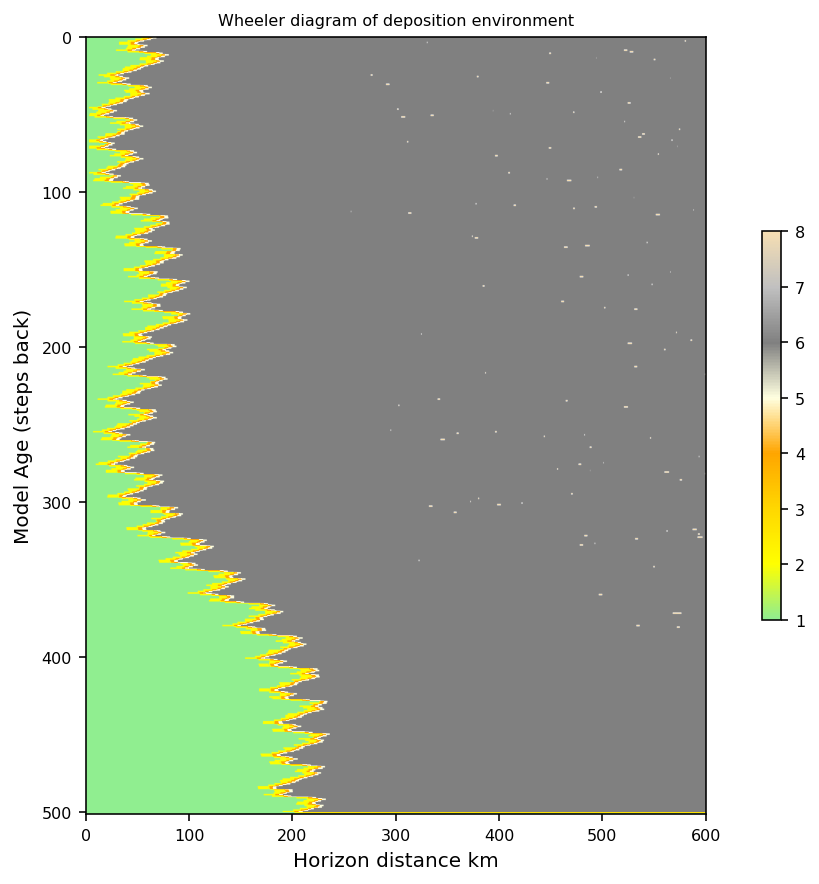

In [ ]:
plt.imshow((dfenv).T,cmap='env_color',vmin=1,alpha=1,aspect=1.5,extent=(0, nCells*Csize/1000, 0, nAges))
plt.colorbar(shrink=0.50)
plt.gca().invert_yaxis()
plt.ylabel('Model Age (steps back)')
plt.xlabel('Horizon distance km')
plt.title('Wheeler diagram of deposition environment');

Calculate the slope between cells (left to right)

In [ ]:
slope = dfelev.shift(1) - dfelev
slope[:1] = slope[1:2]

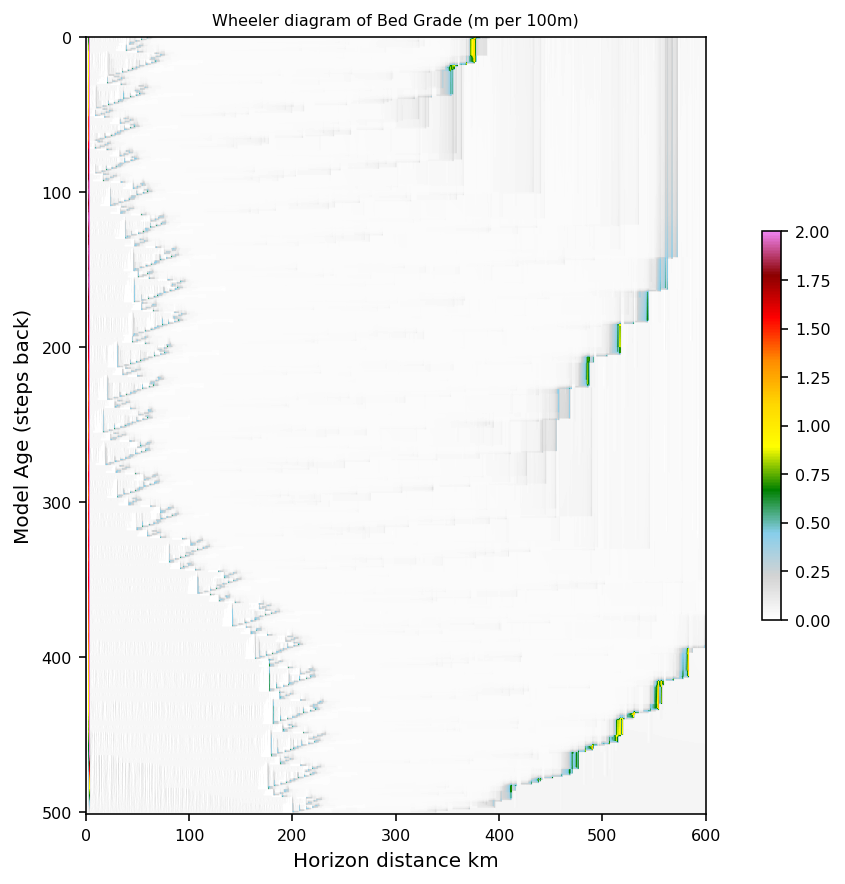

In [ ]:
plt.imshow(slope.T,cmap='wbgr',vmin=0, vmax=2, aspect=1.5,extent=(0, nCells*Csize/1000, 0, nAges))
plt.colorbar(shrink=0.50)
plt.gca().invert_yaxis()
plt.ylabel('Model Age (steps back)')
plt.xlabel('Horizon distance km')
plt.title('Wheeler diagram of Bed Grade (m per 100m)');

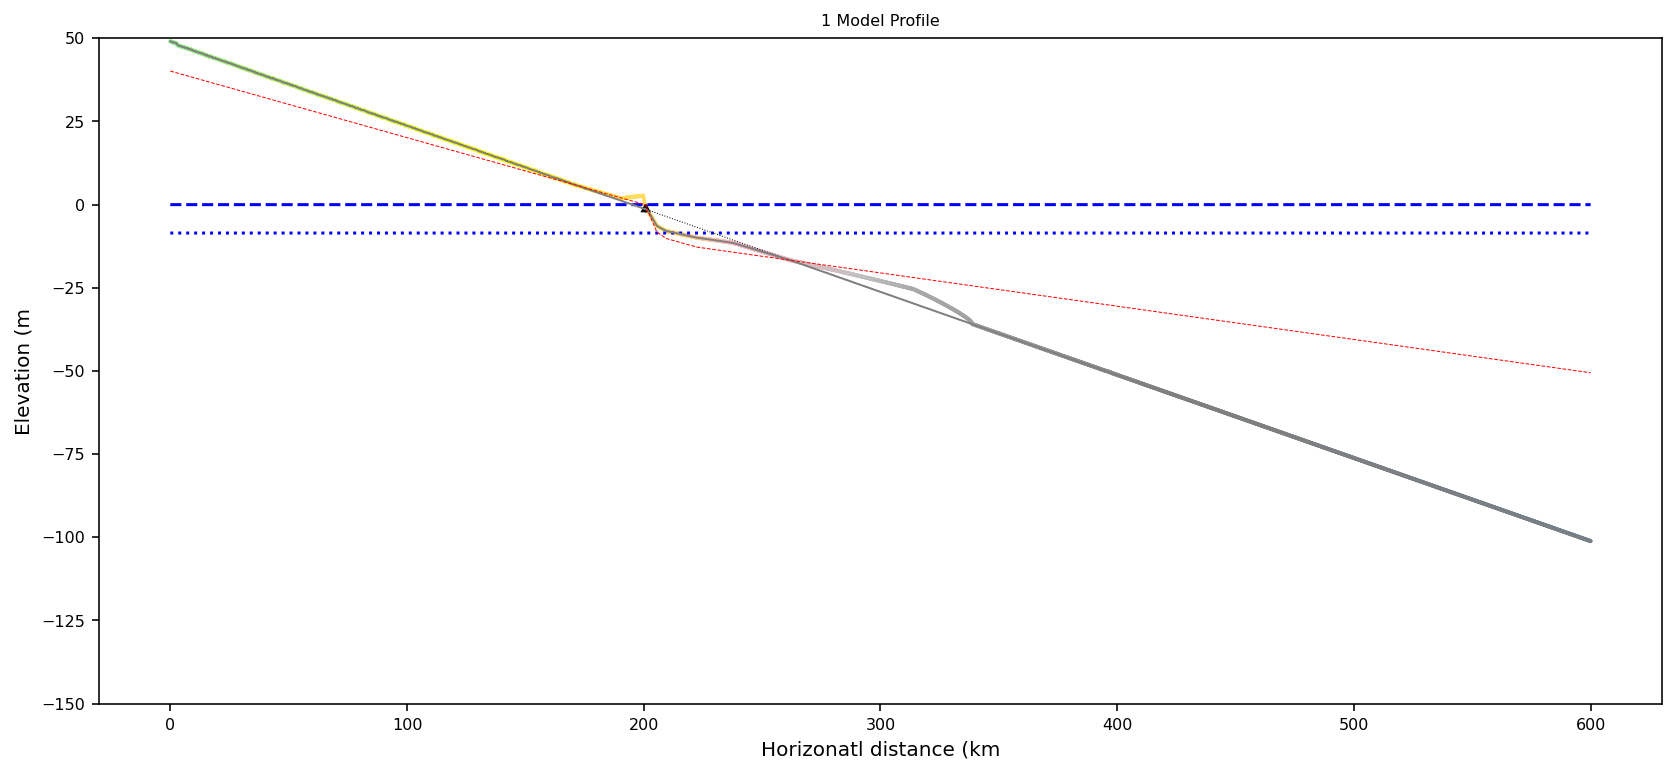

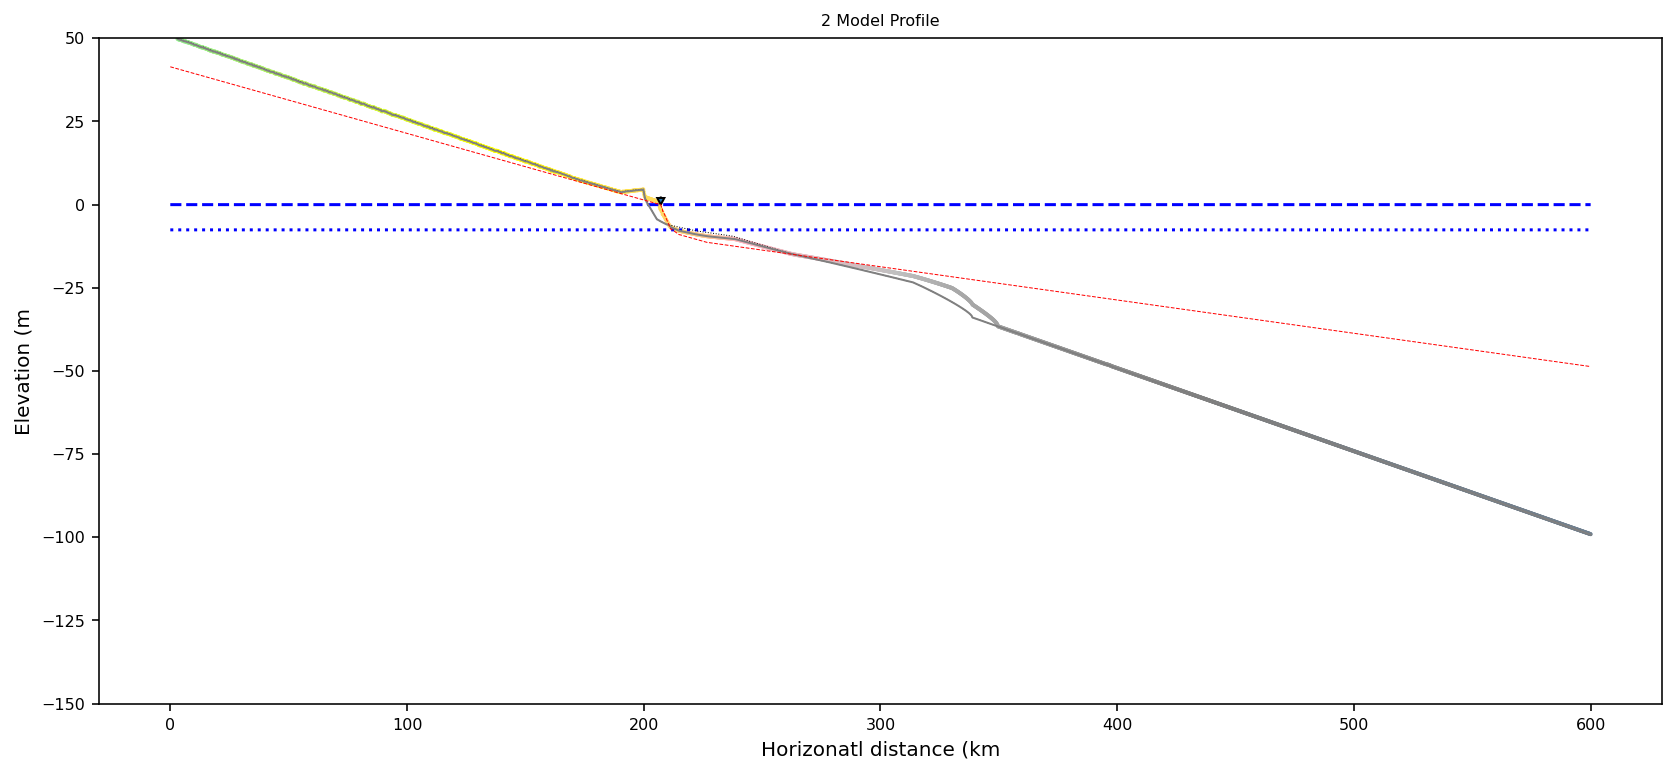

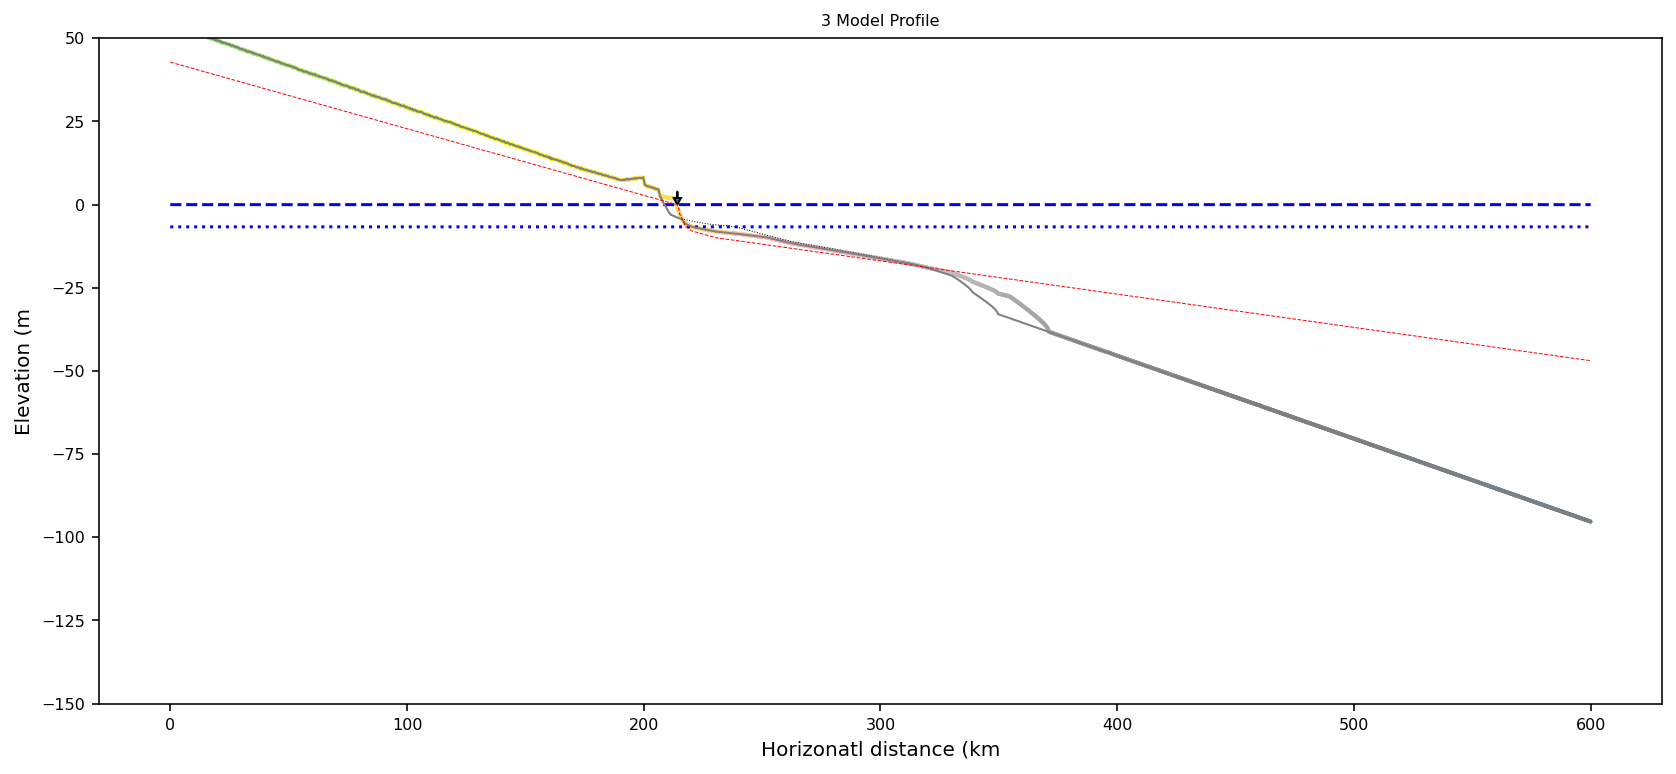

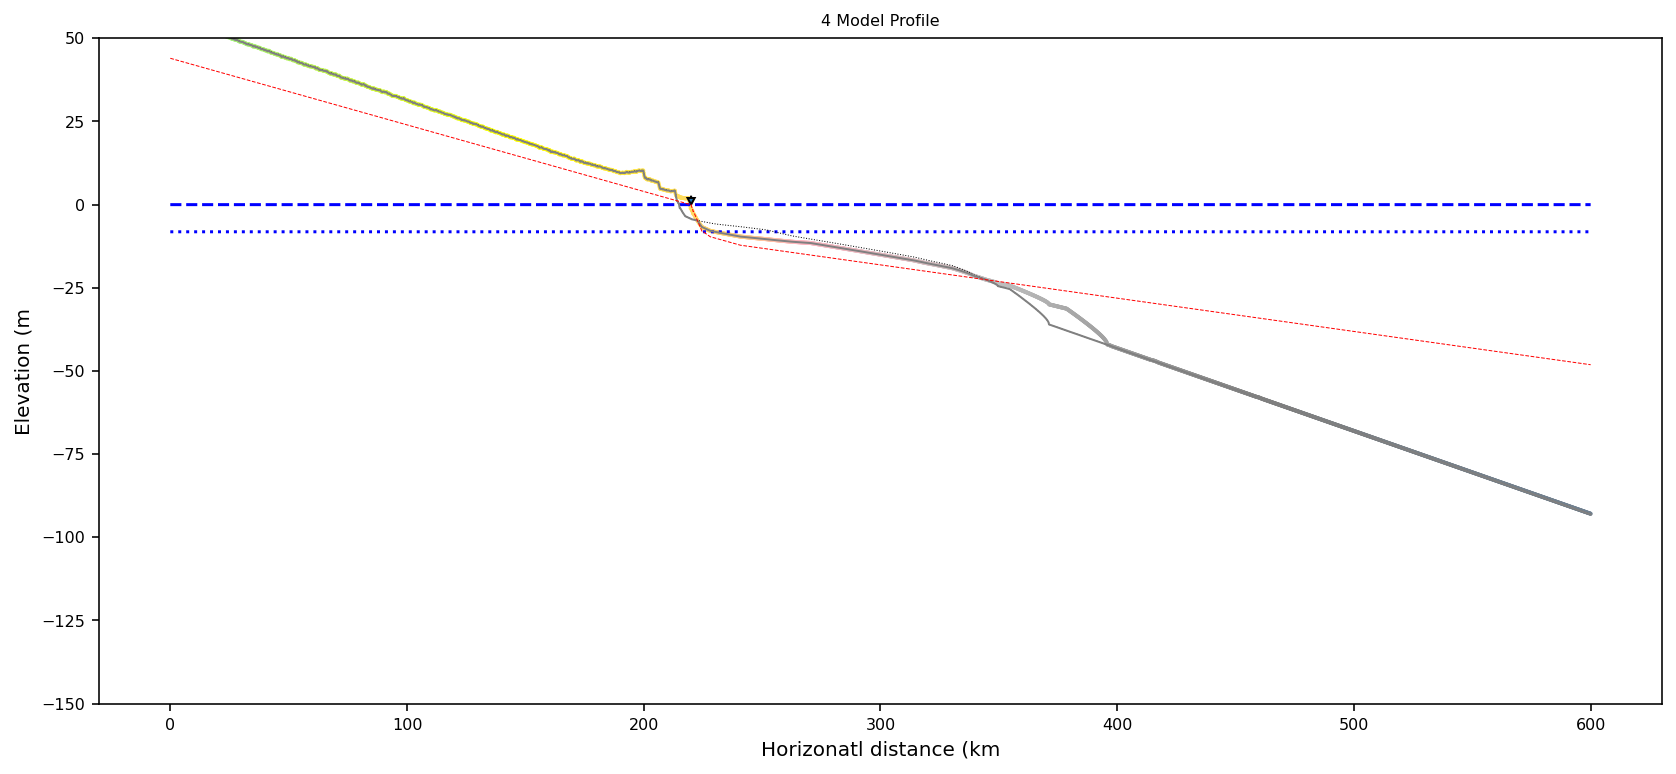

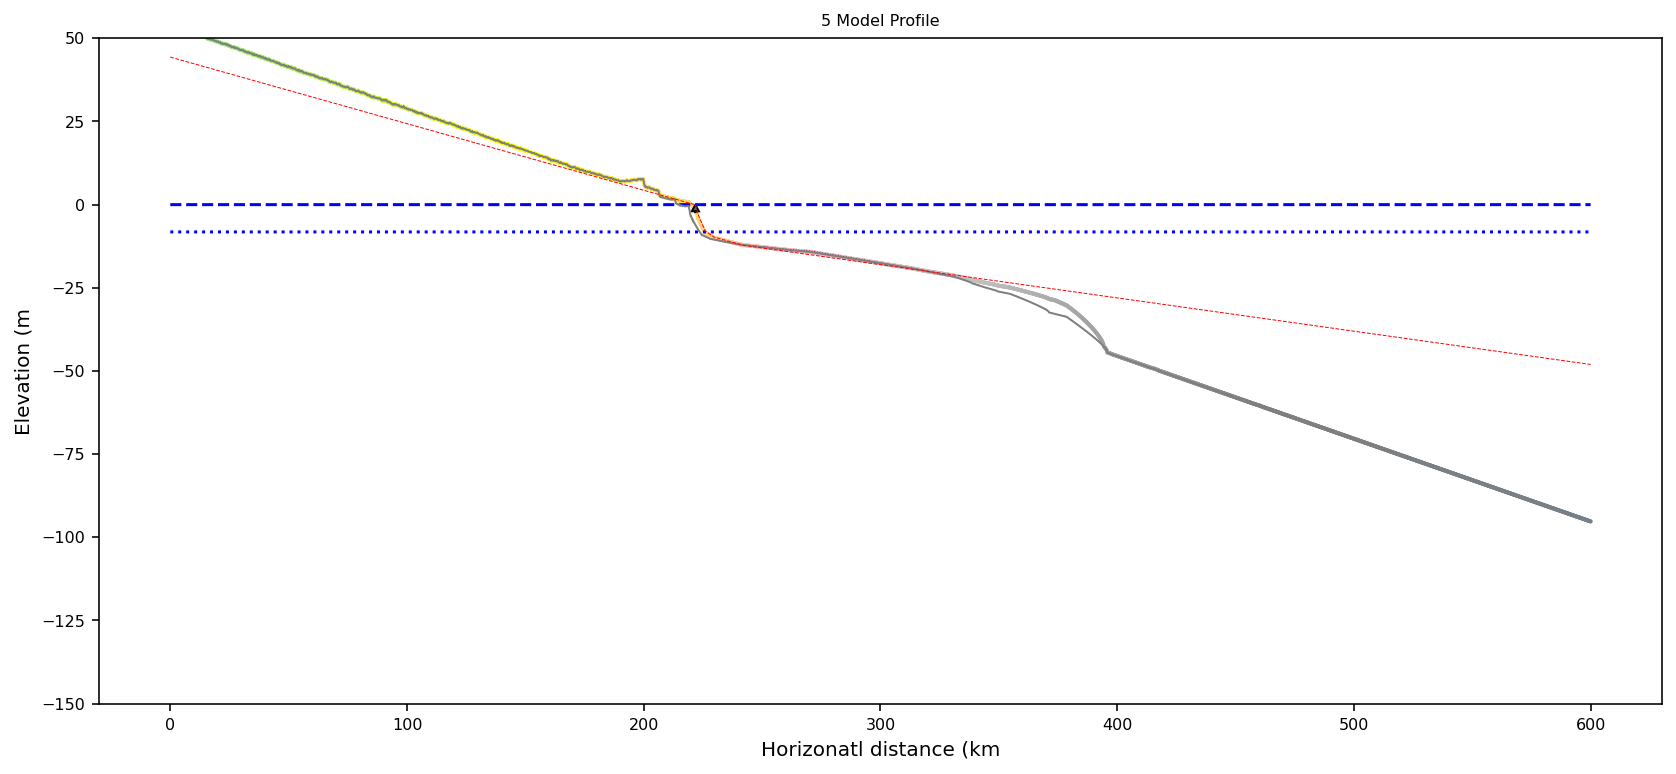

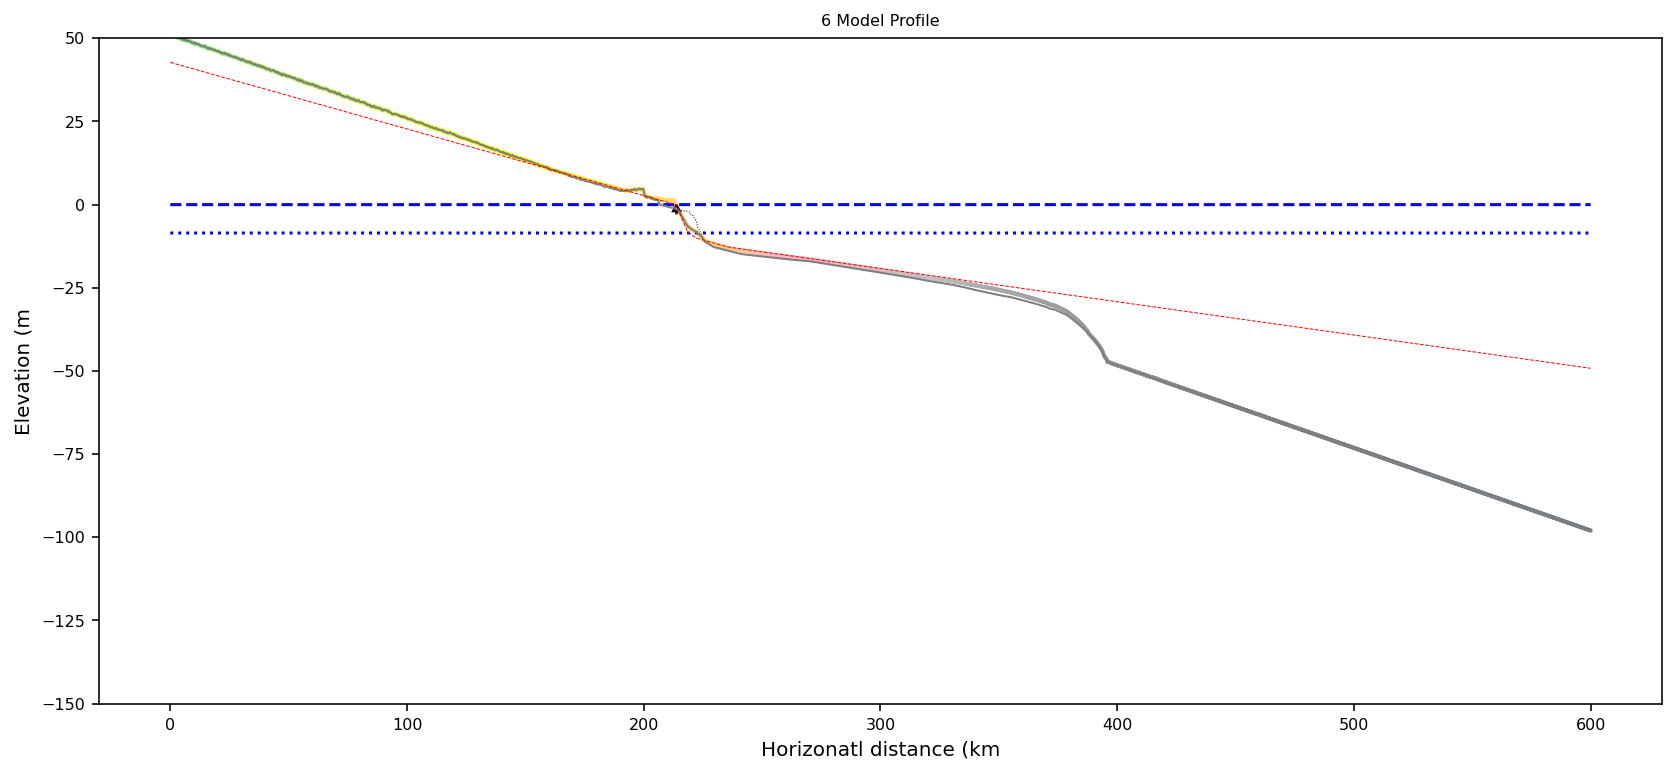

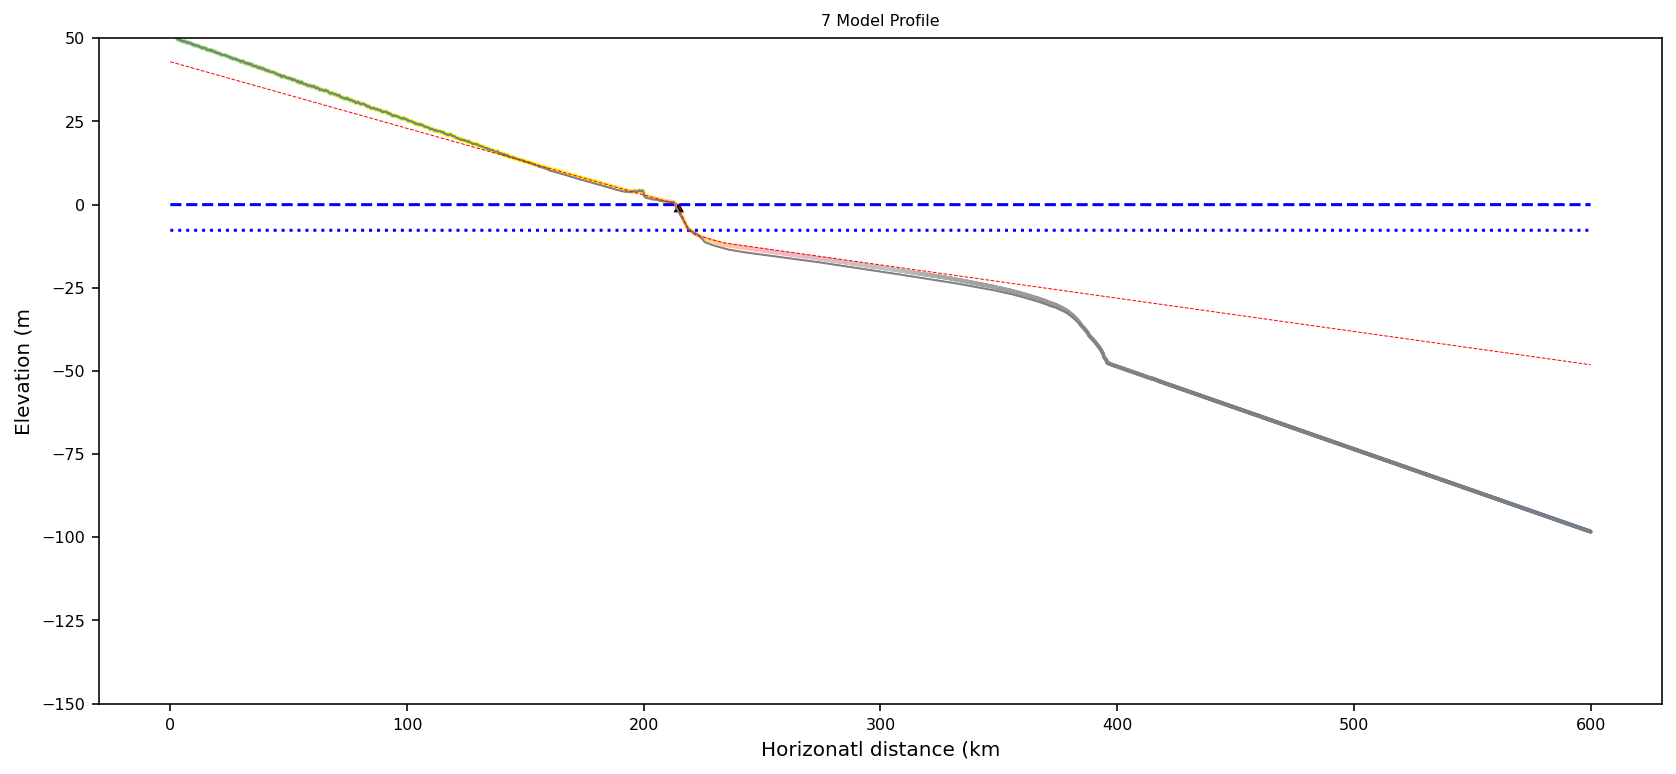

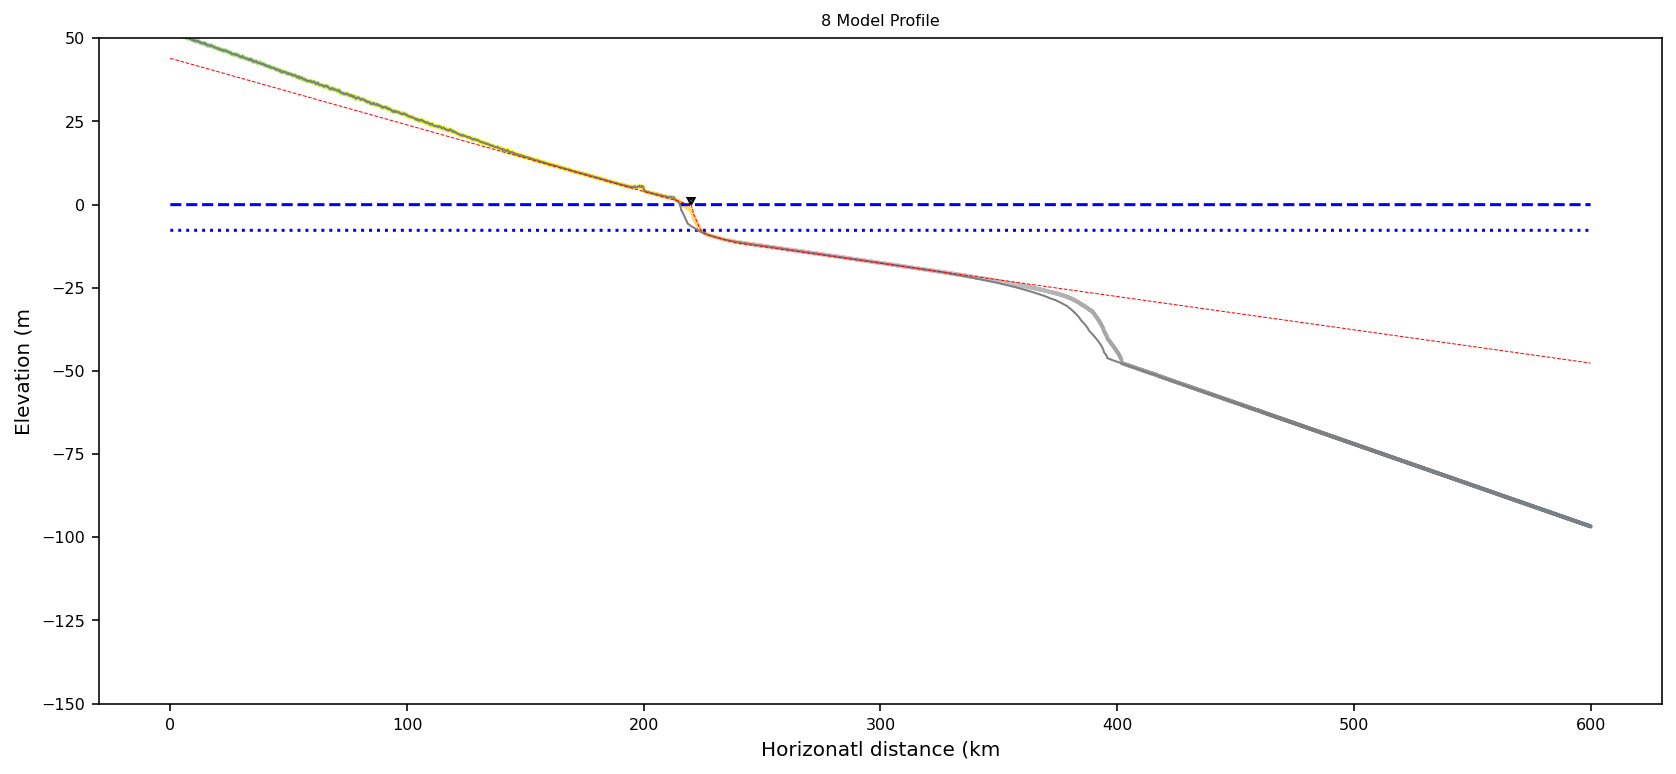

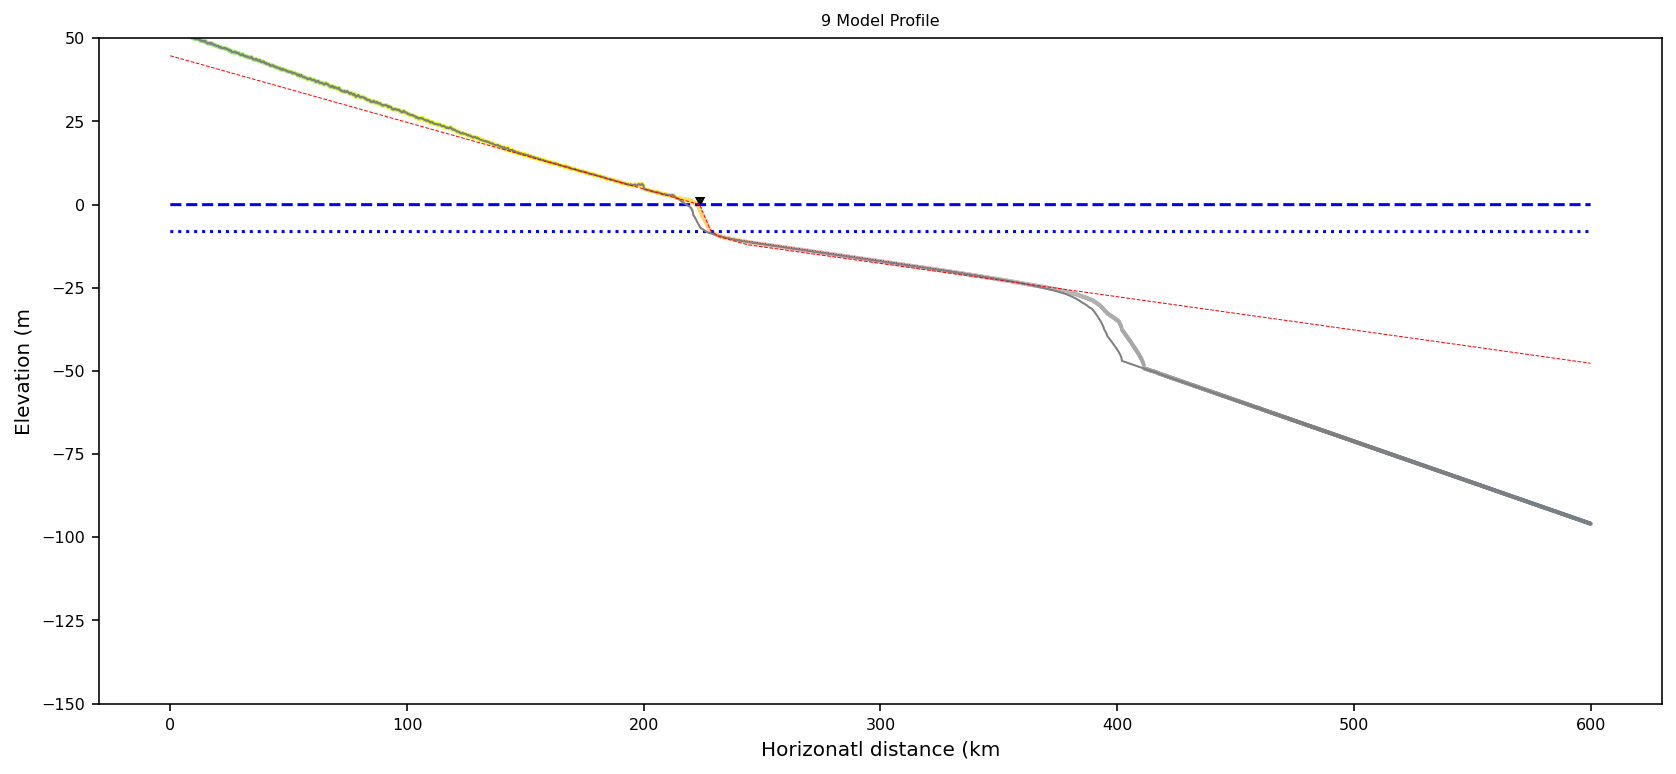

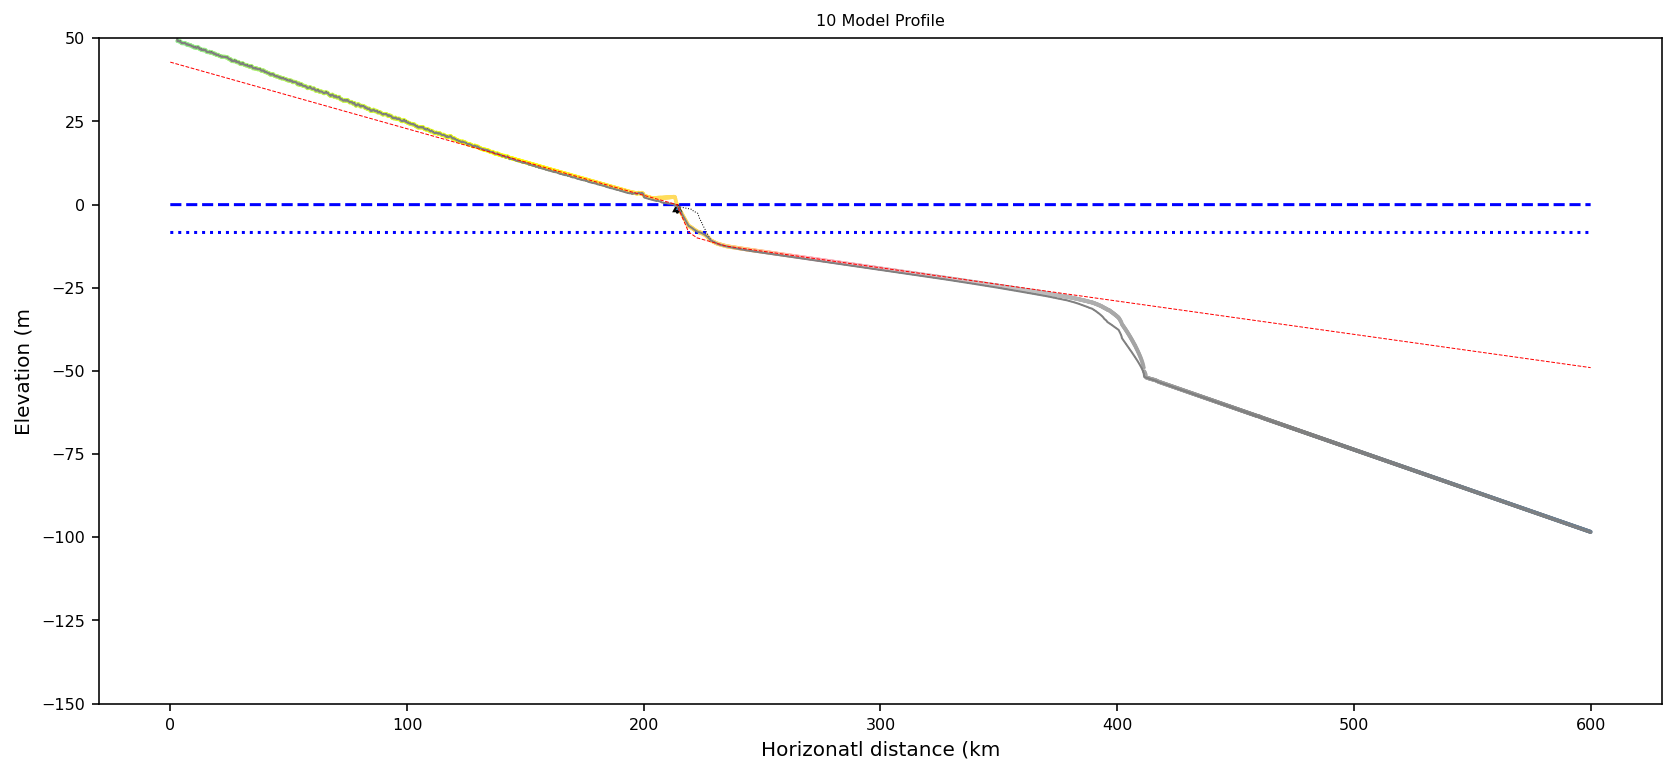

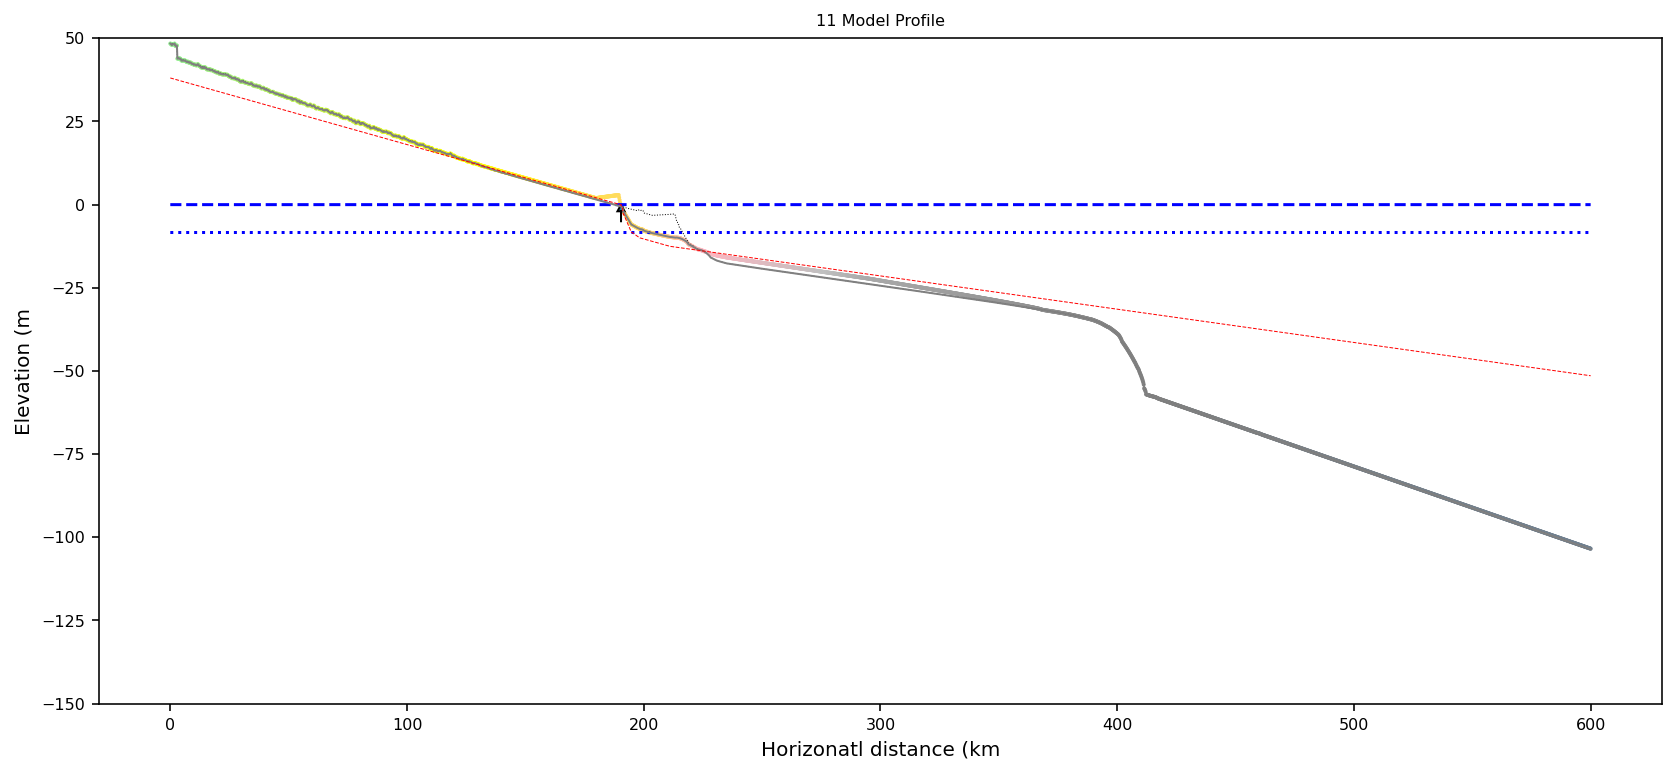

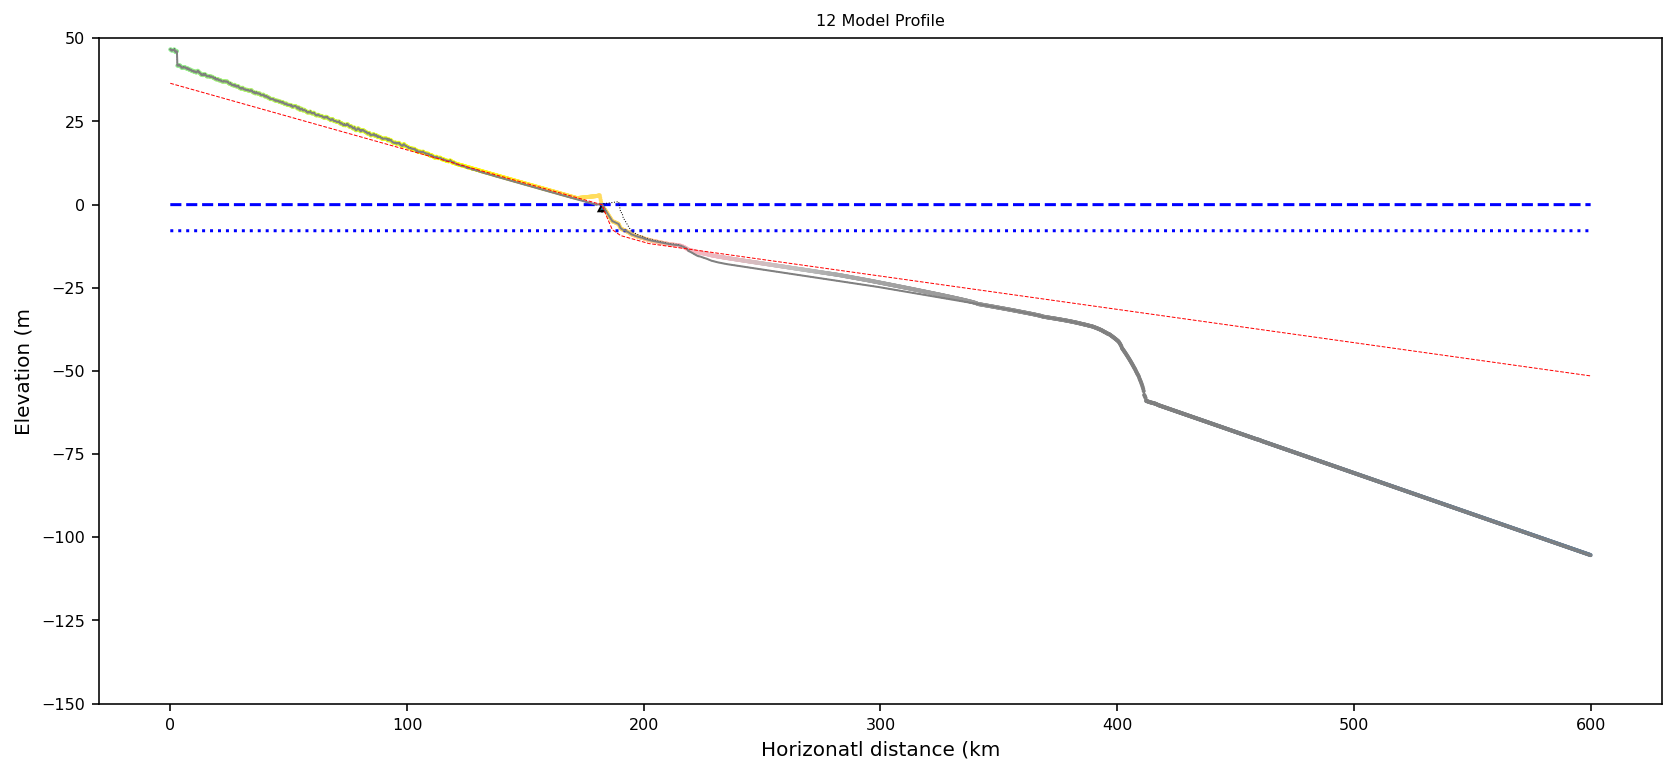

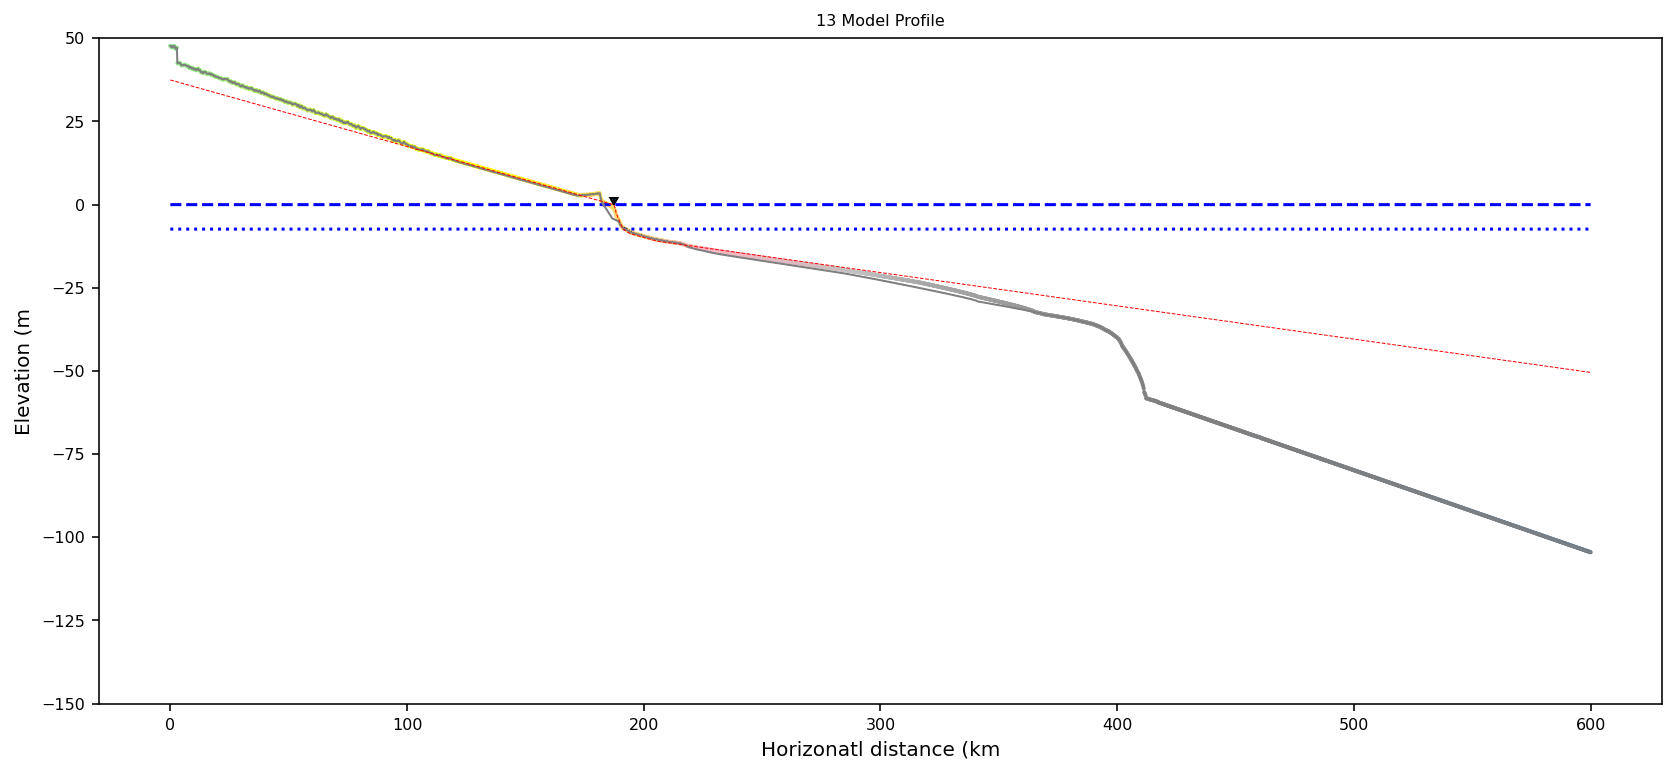

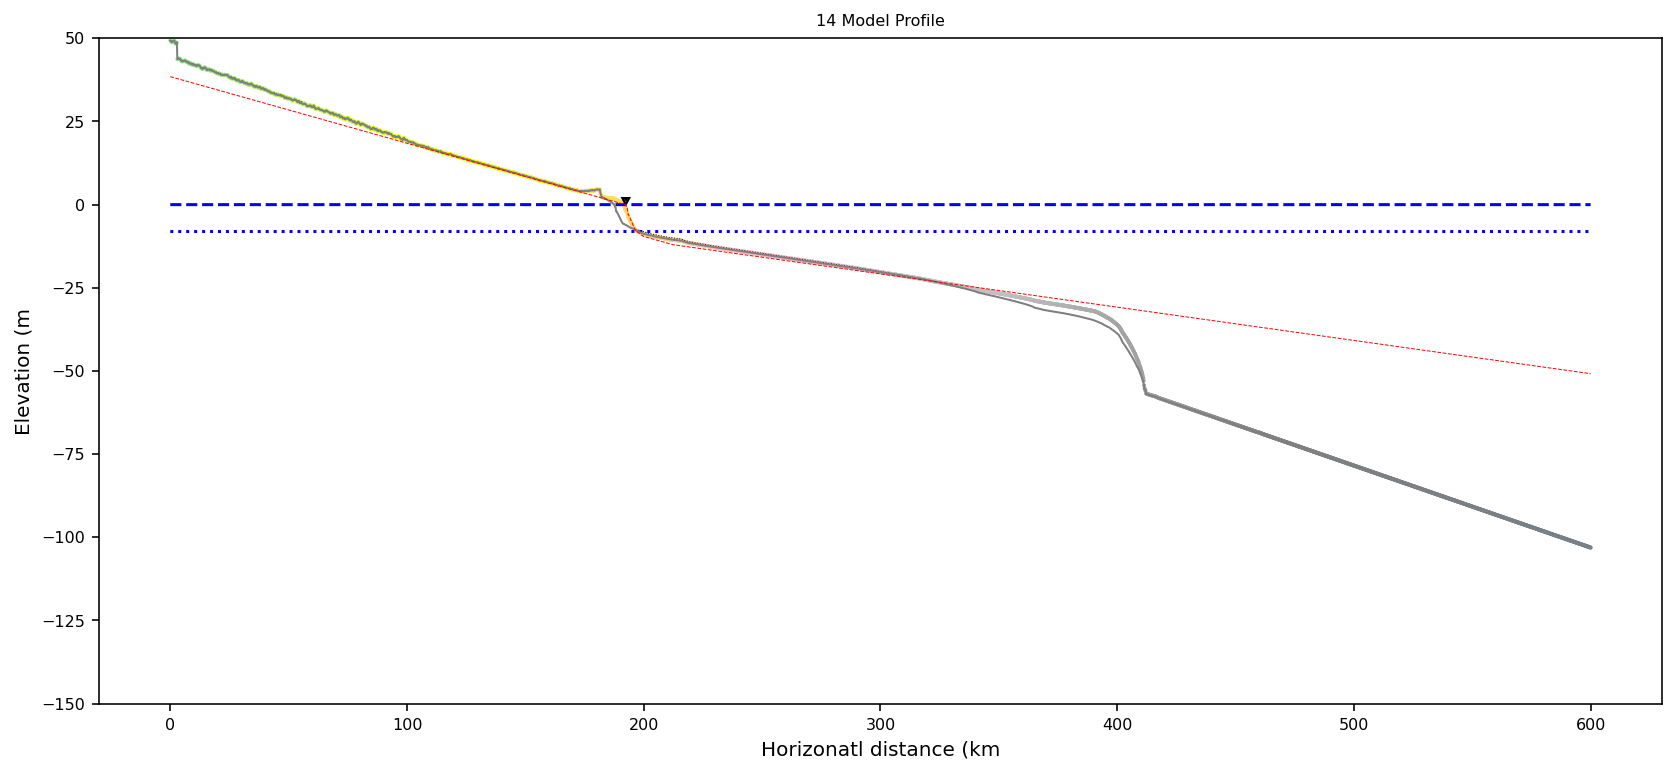

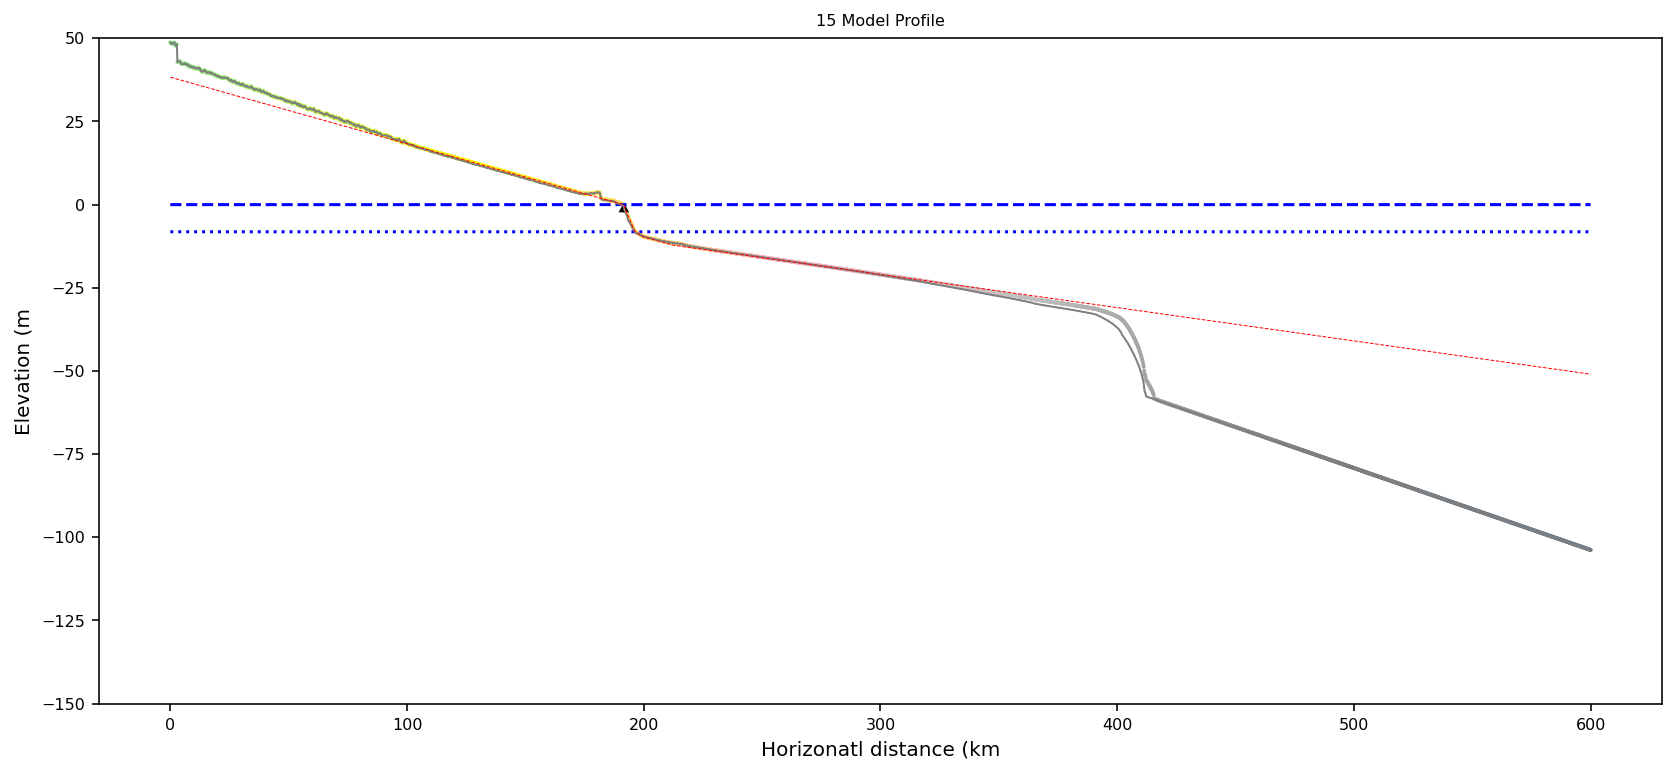

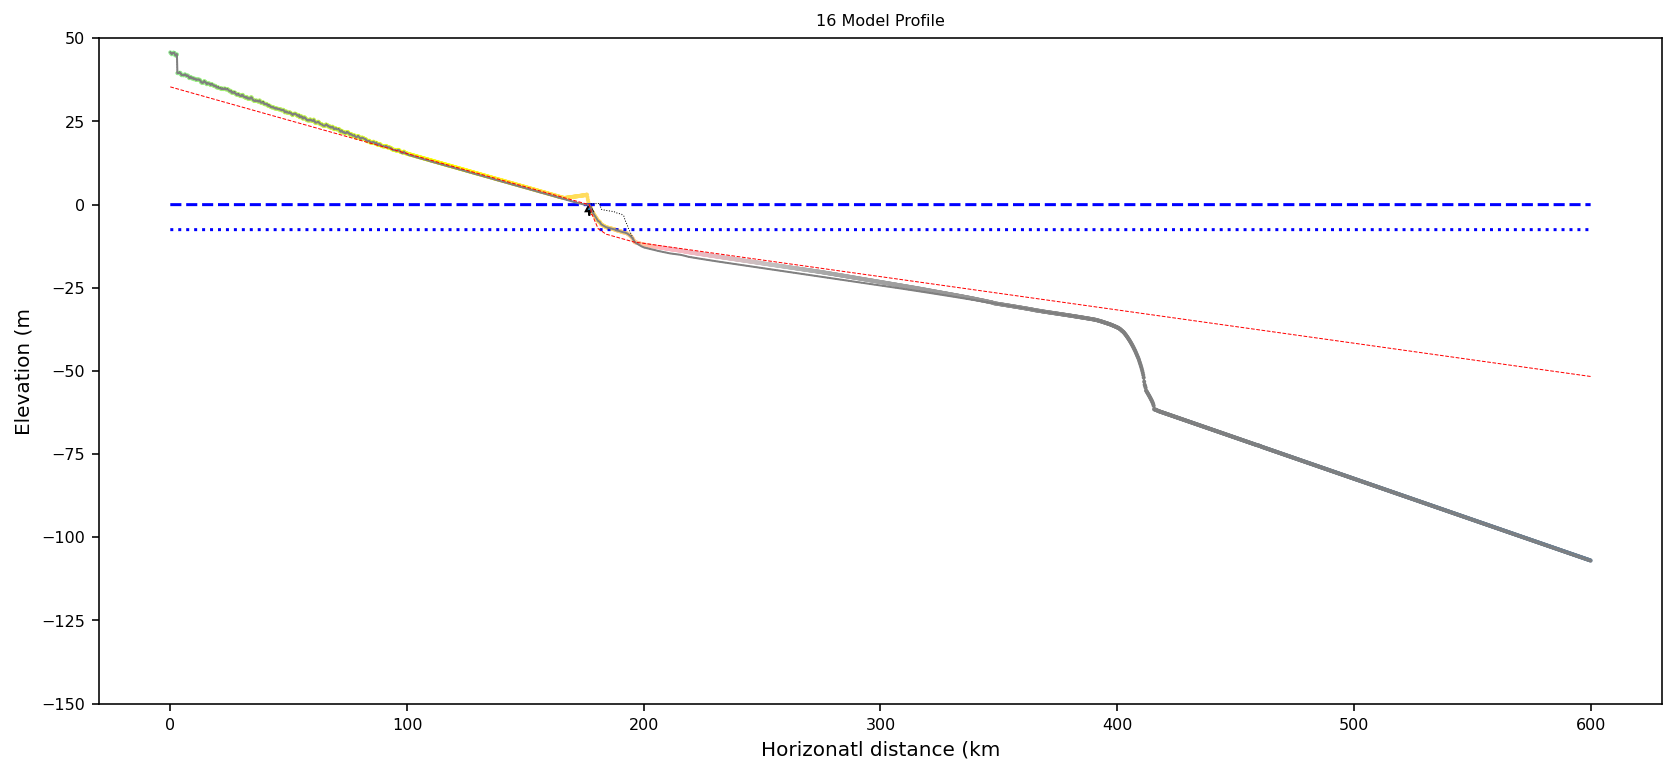

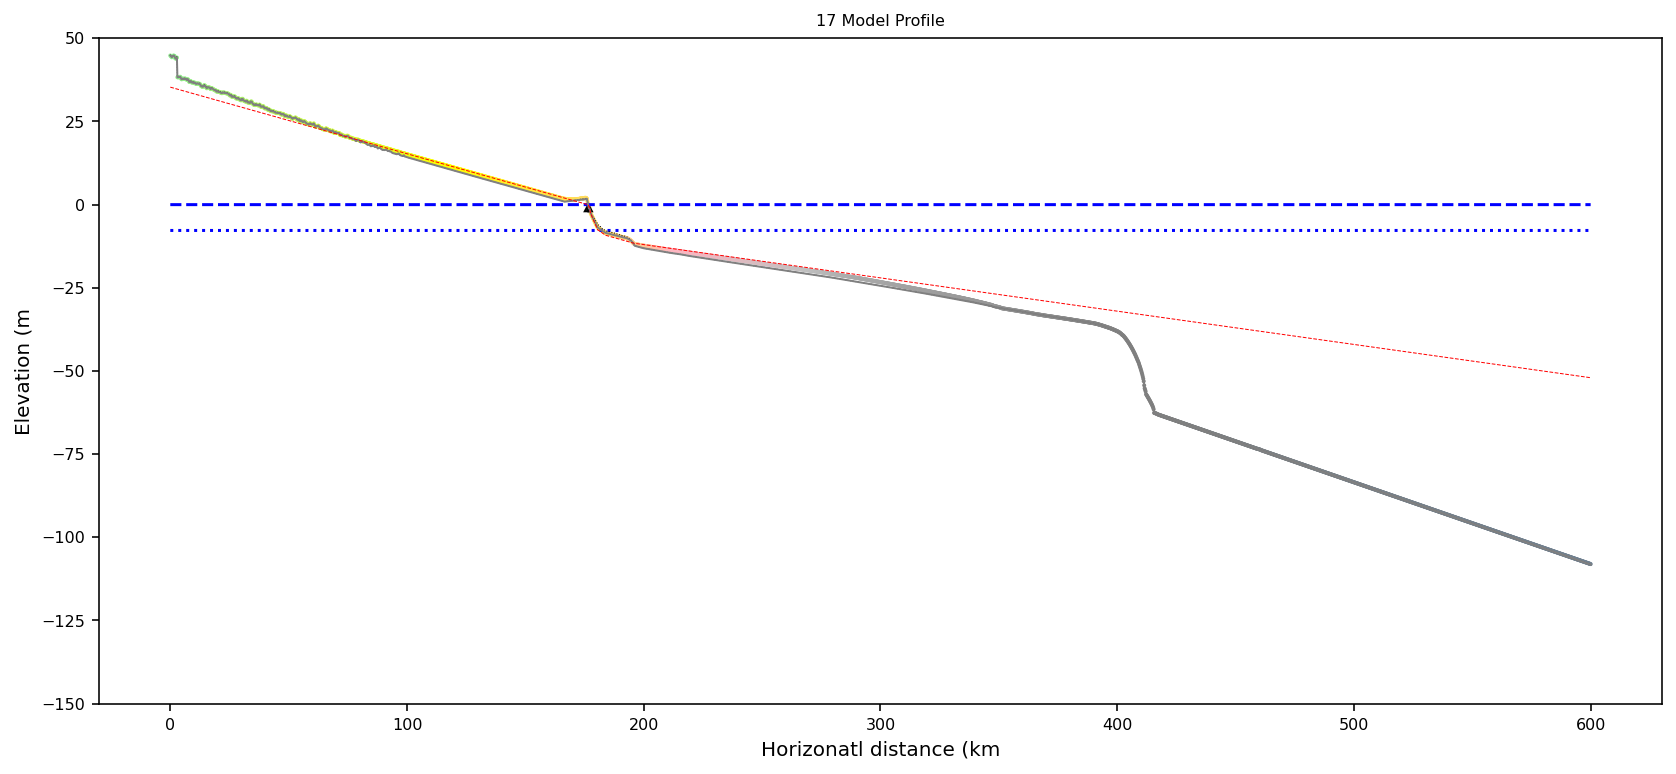

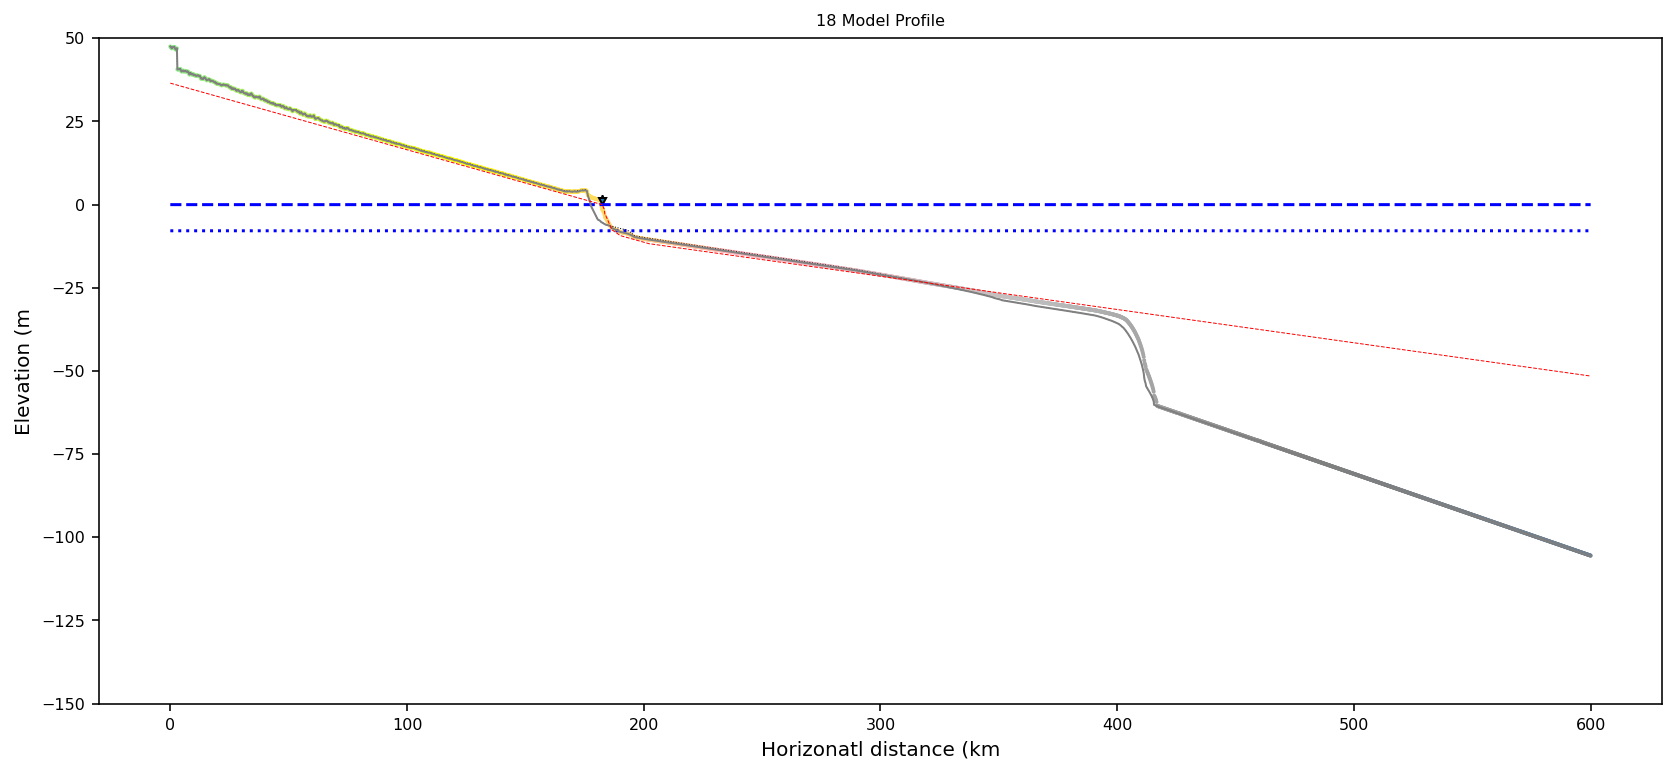

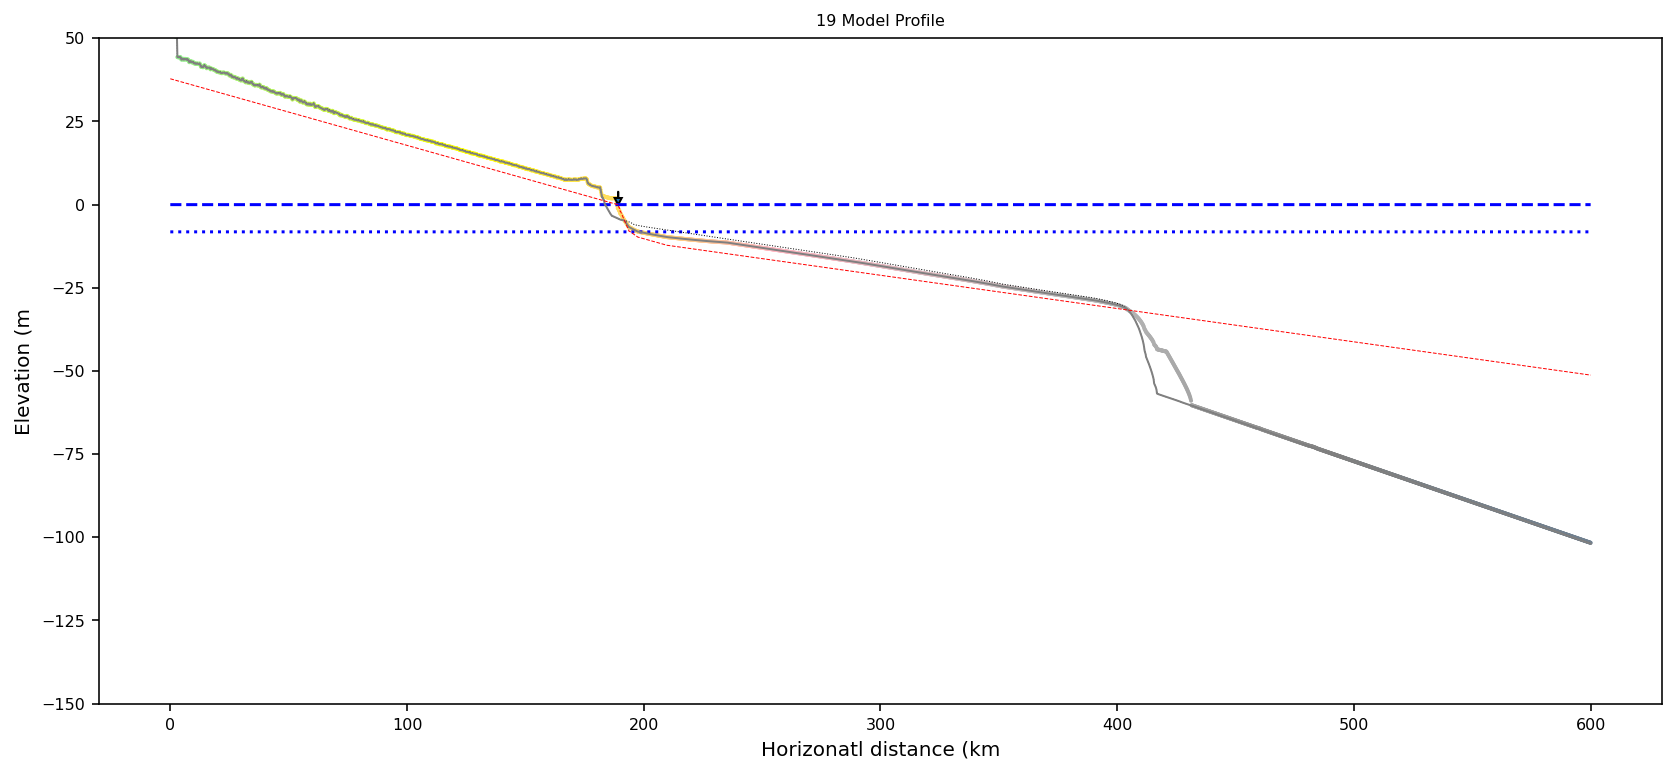

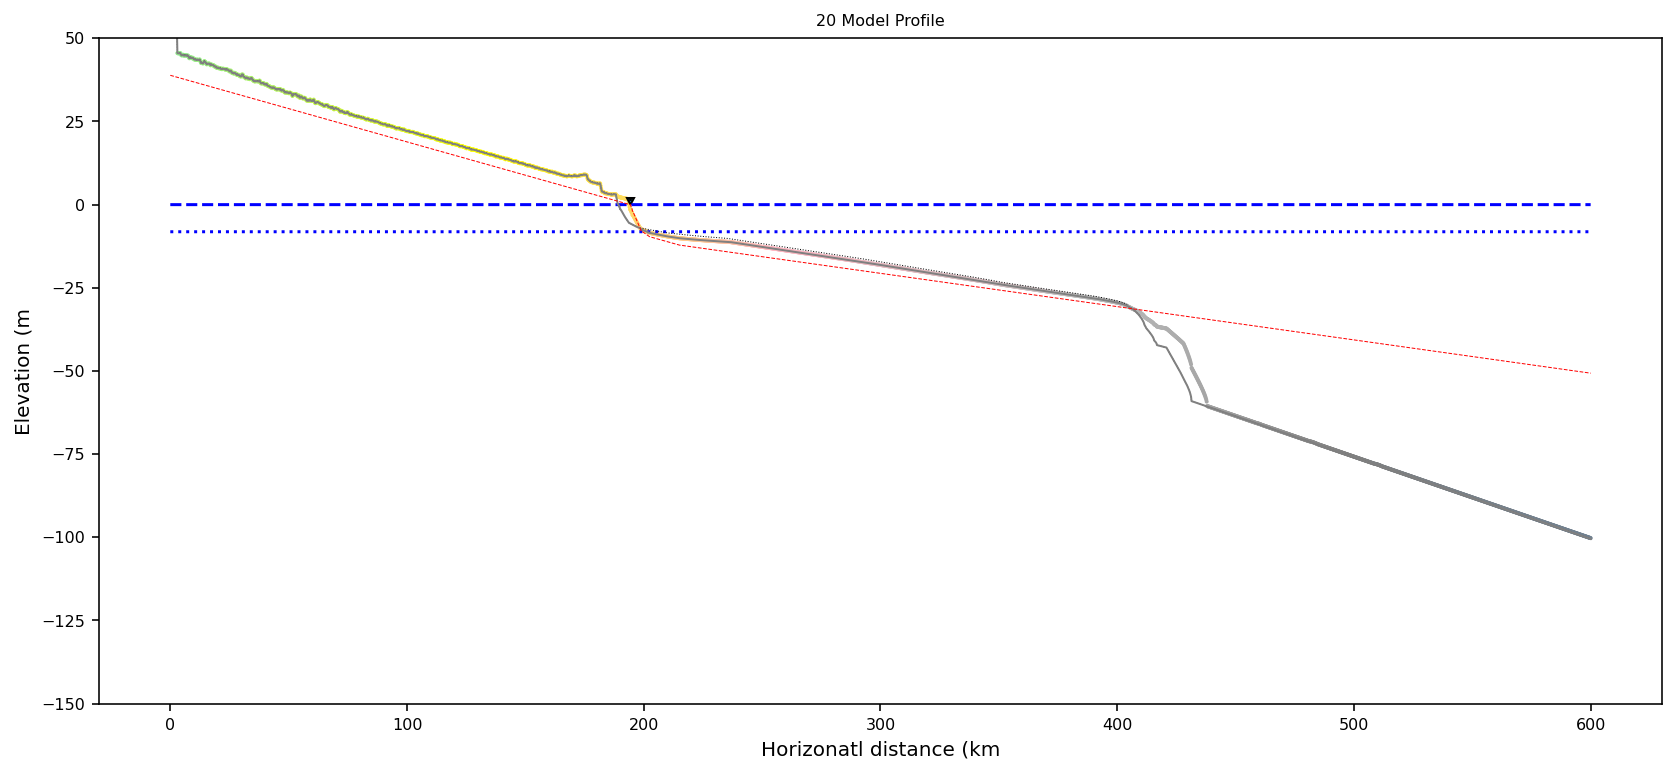

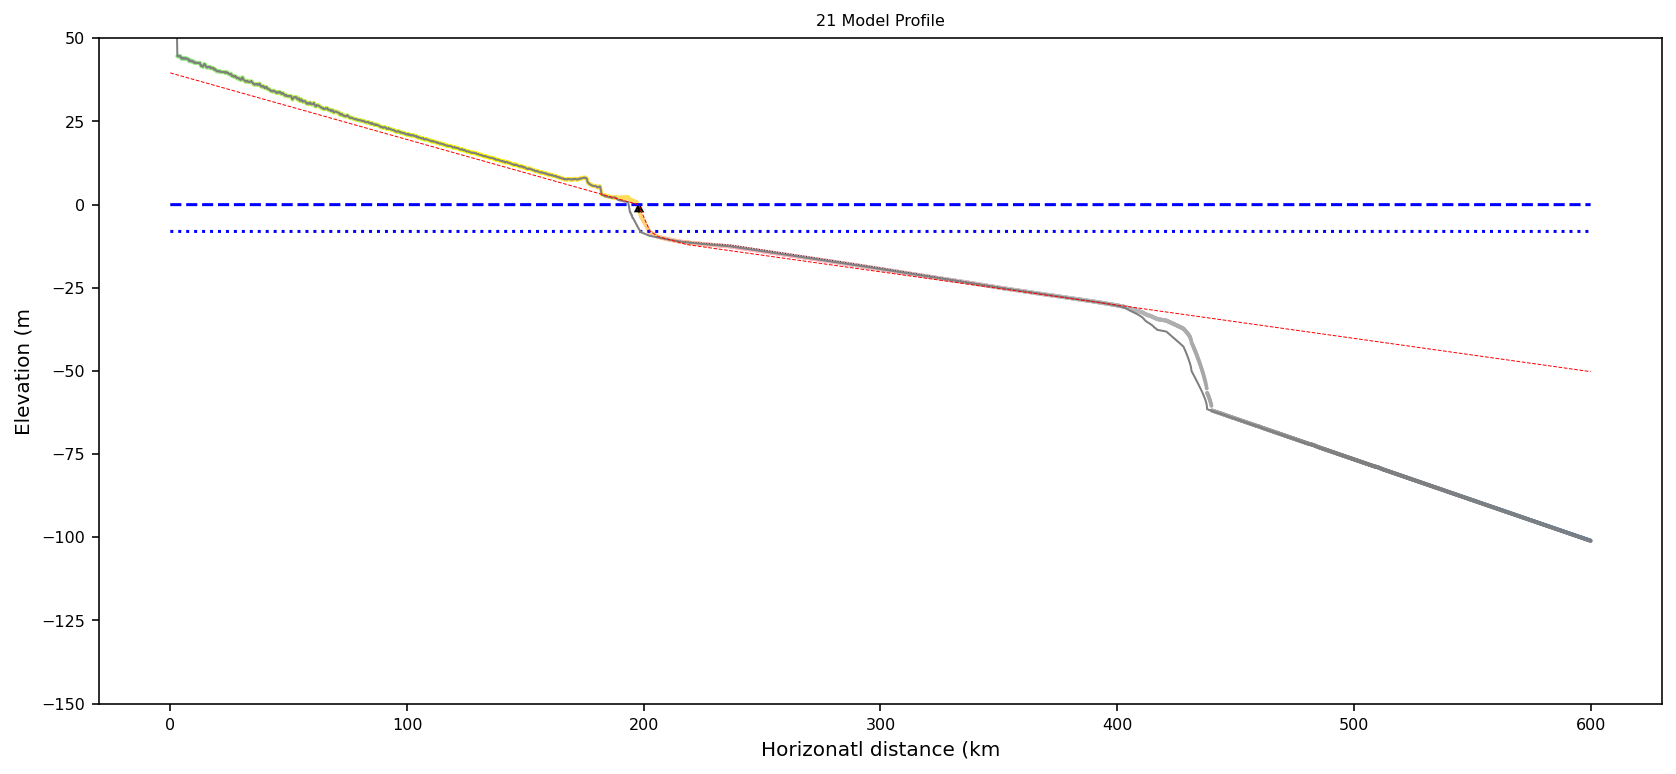

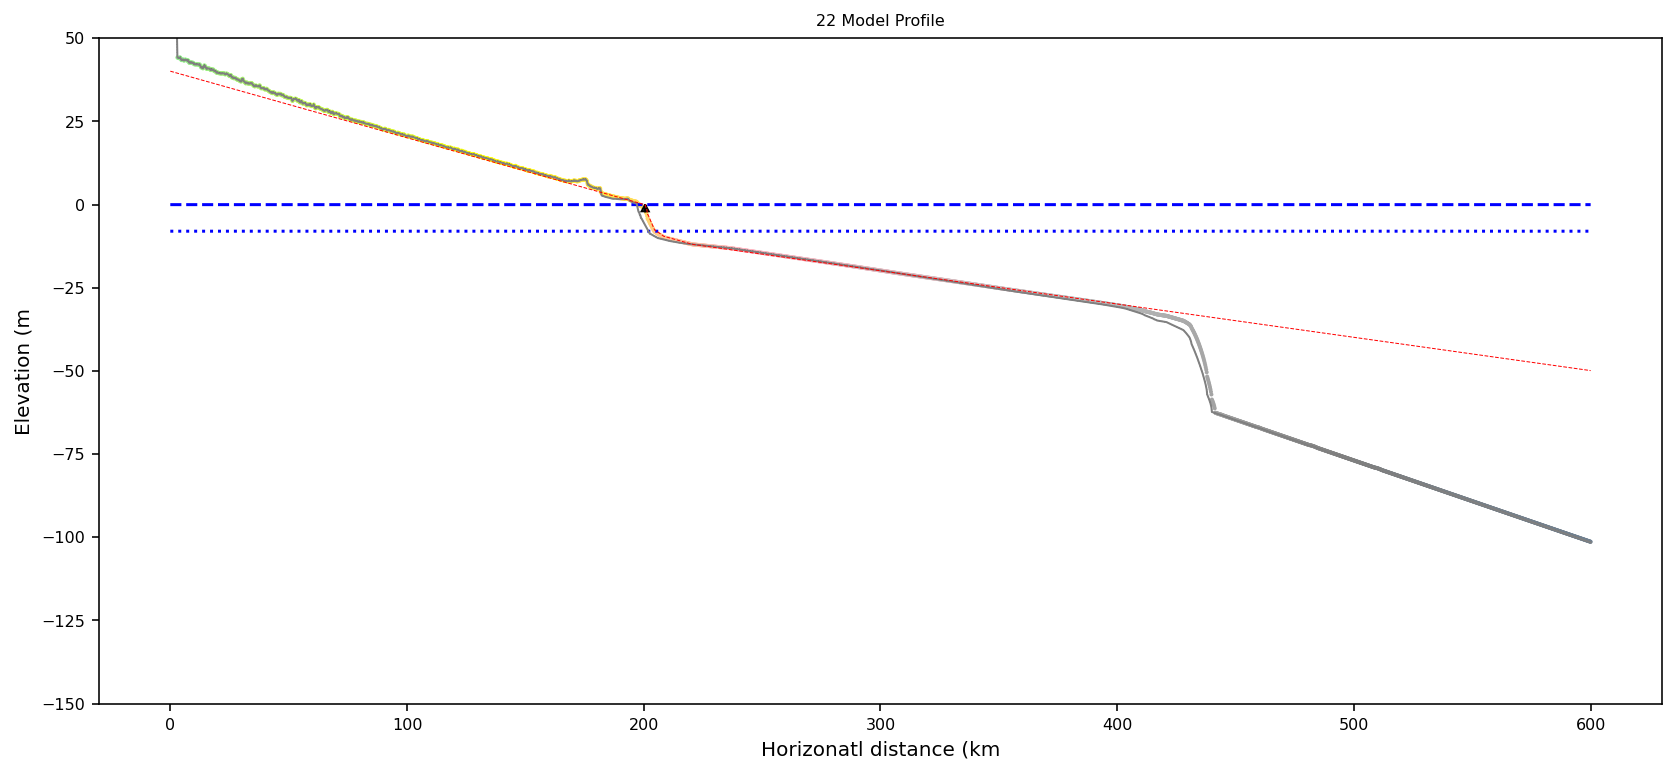

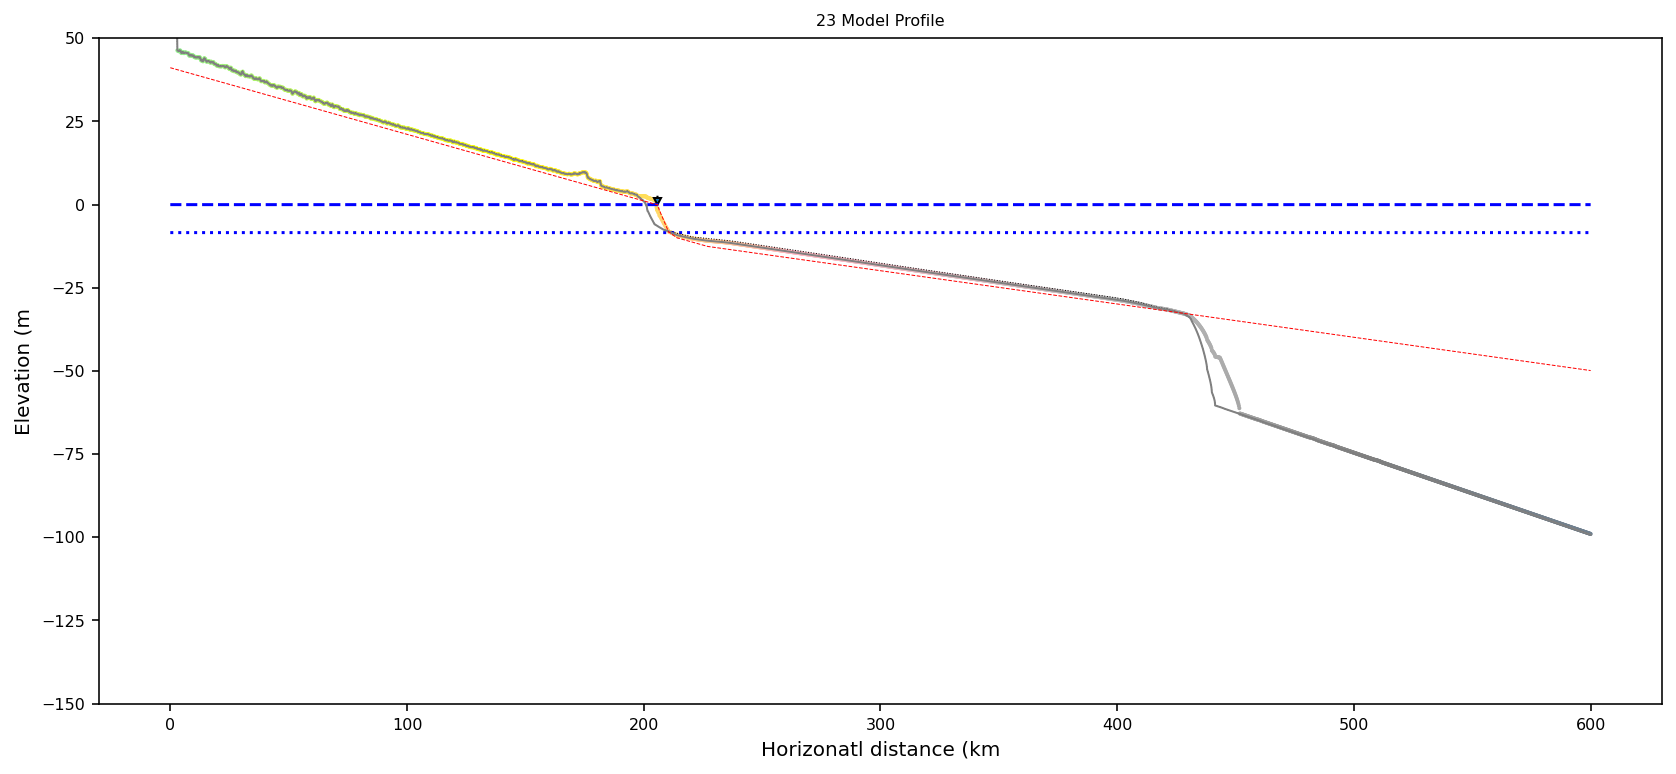

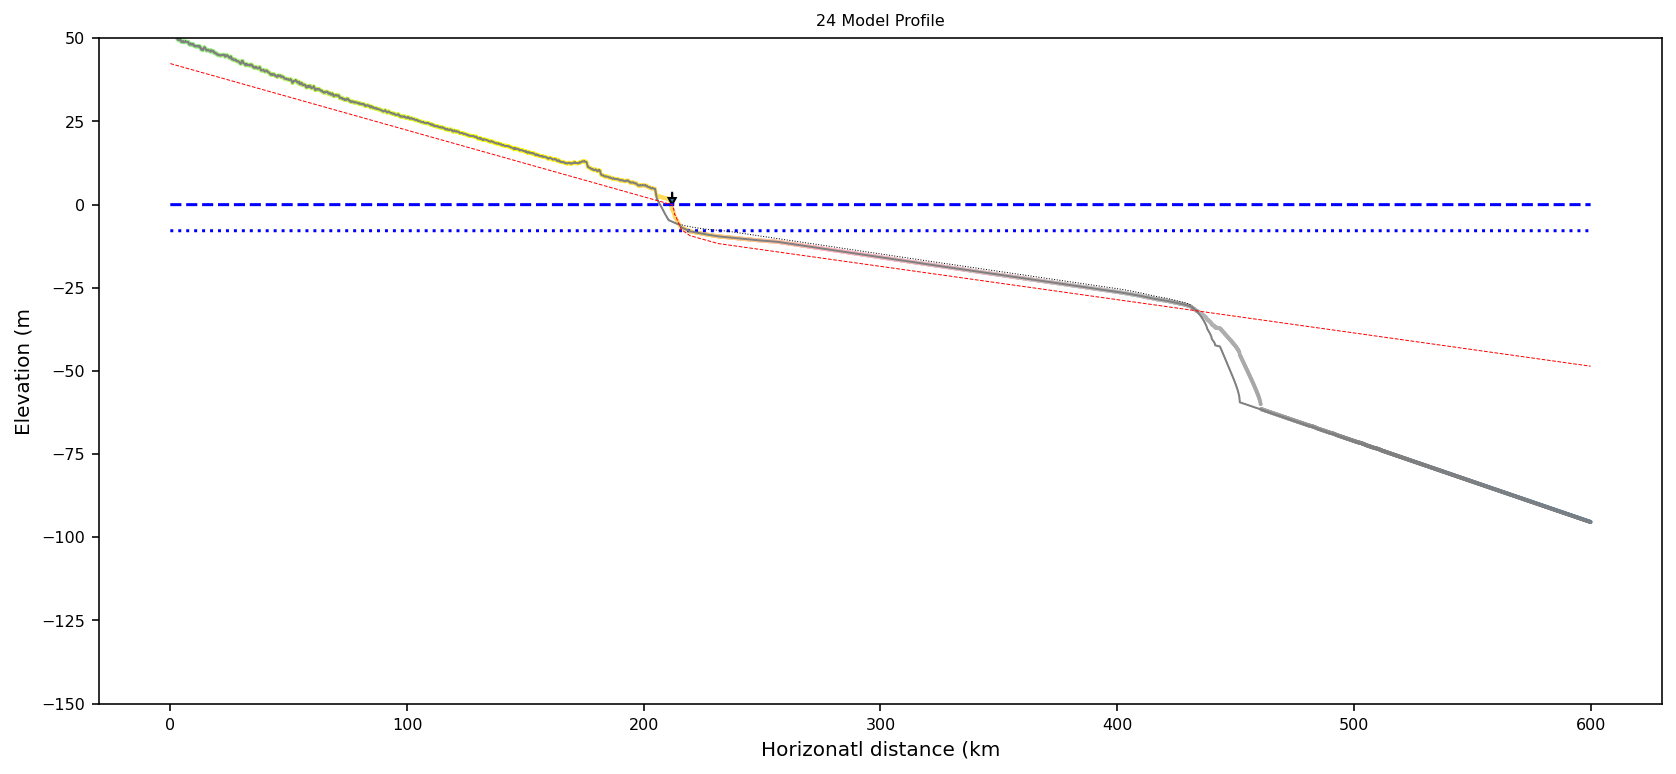

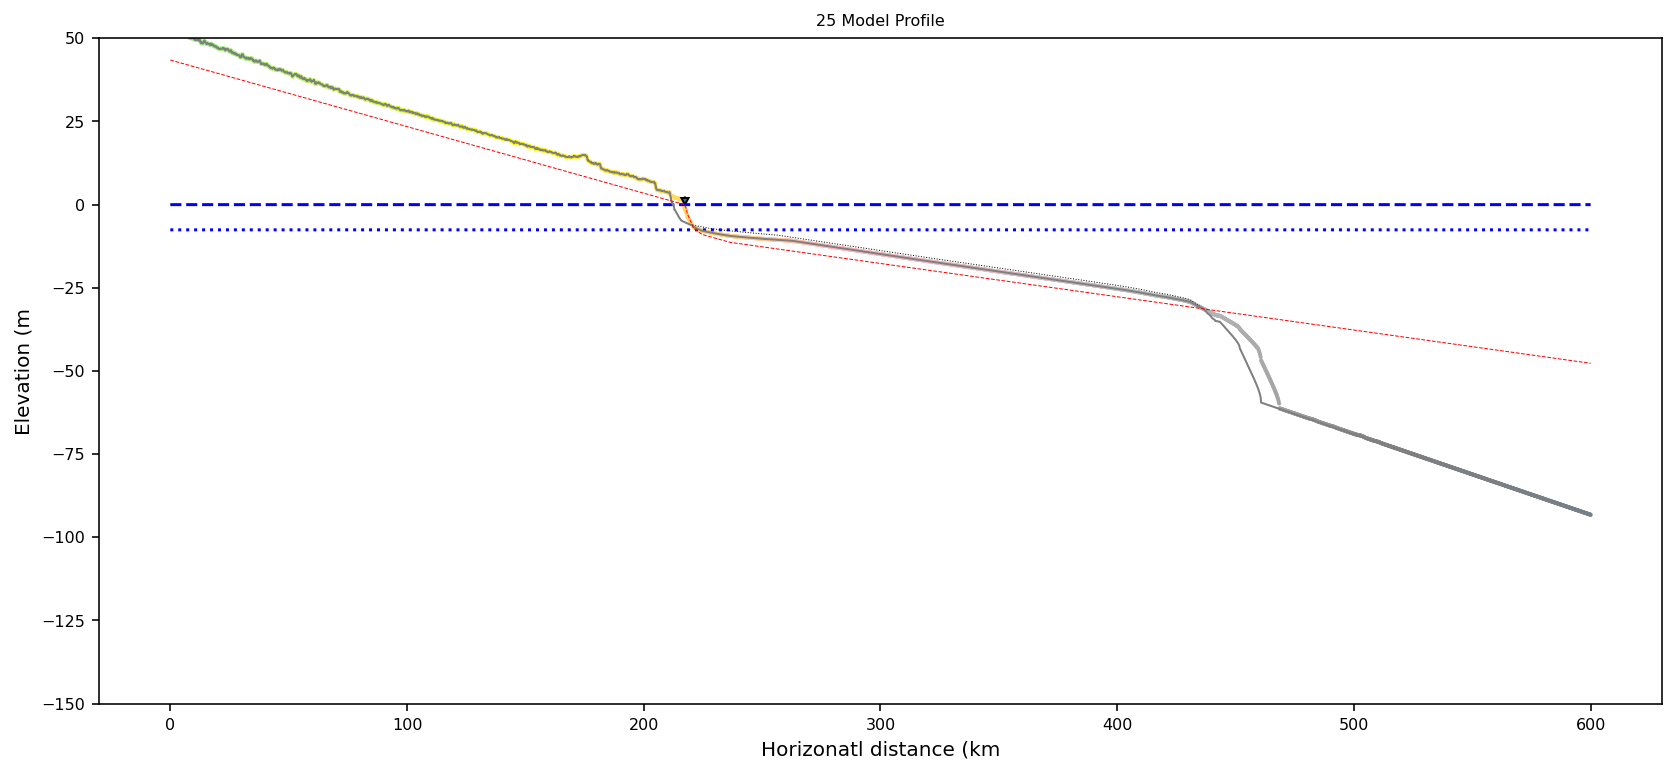

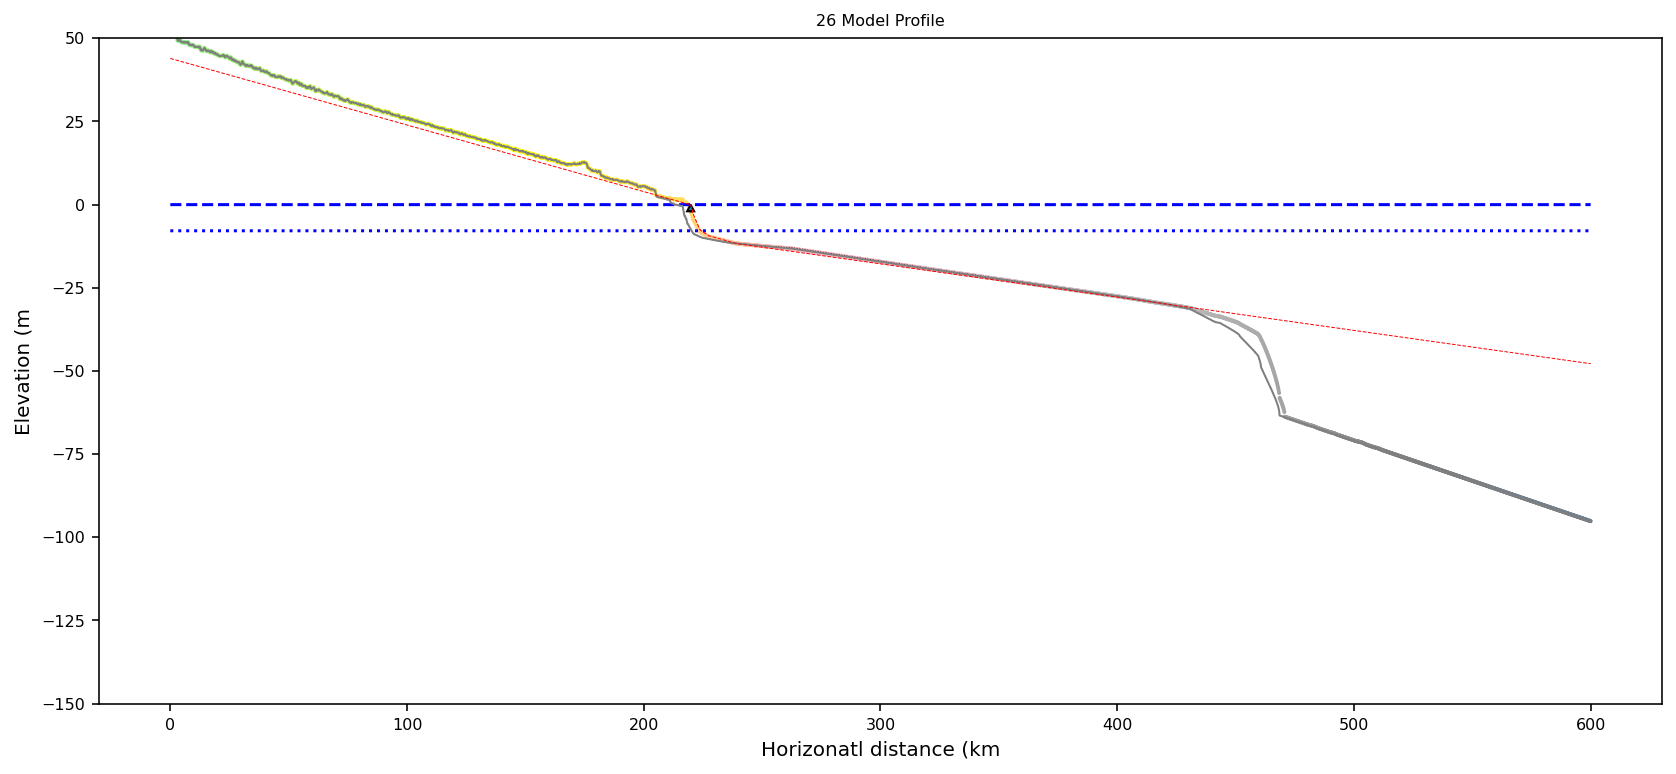

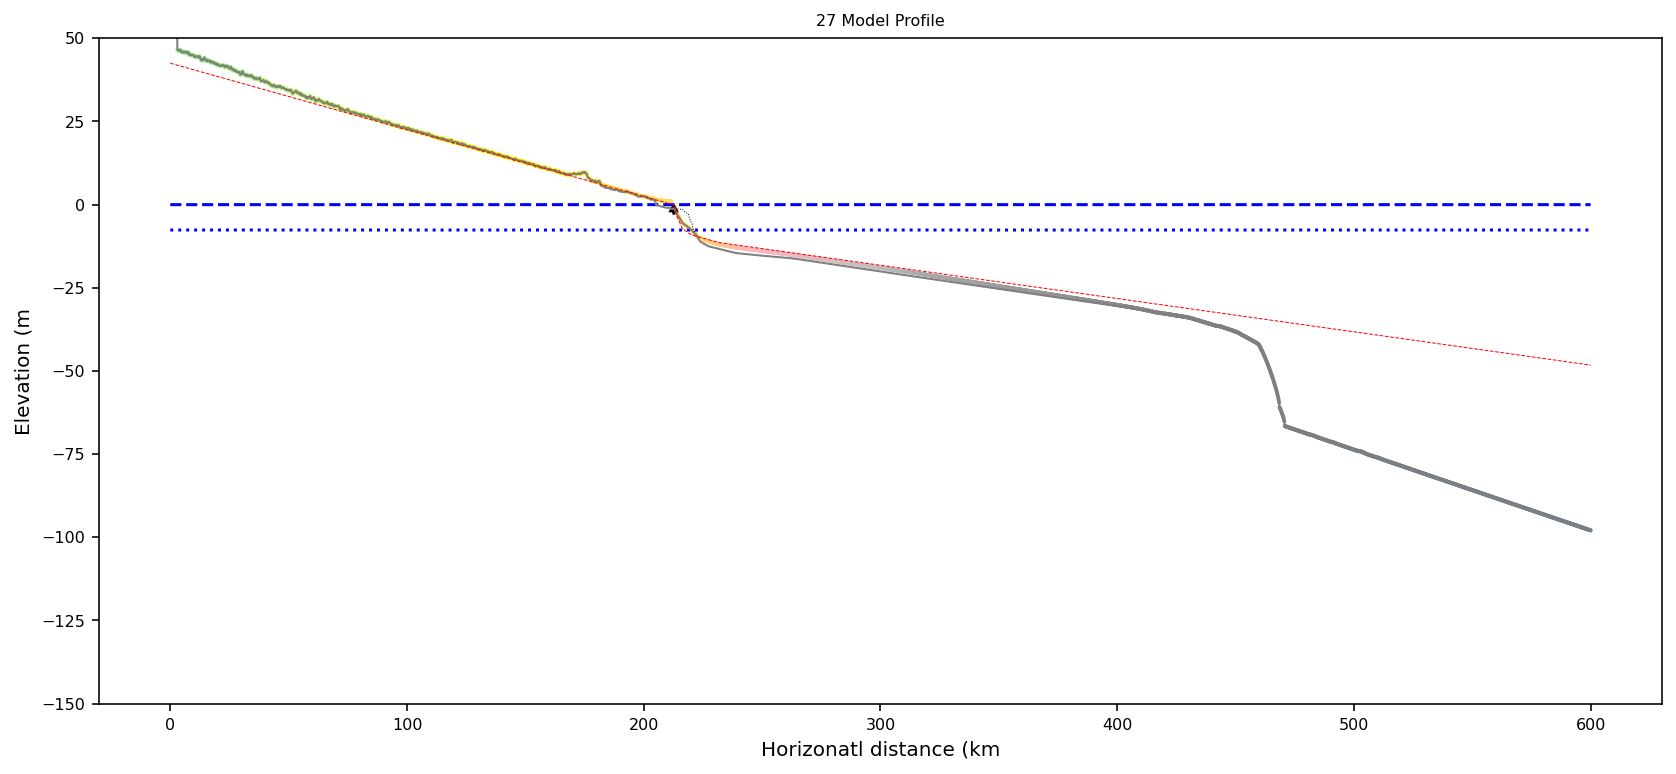

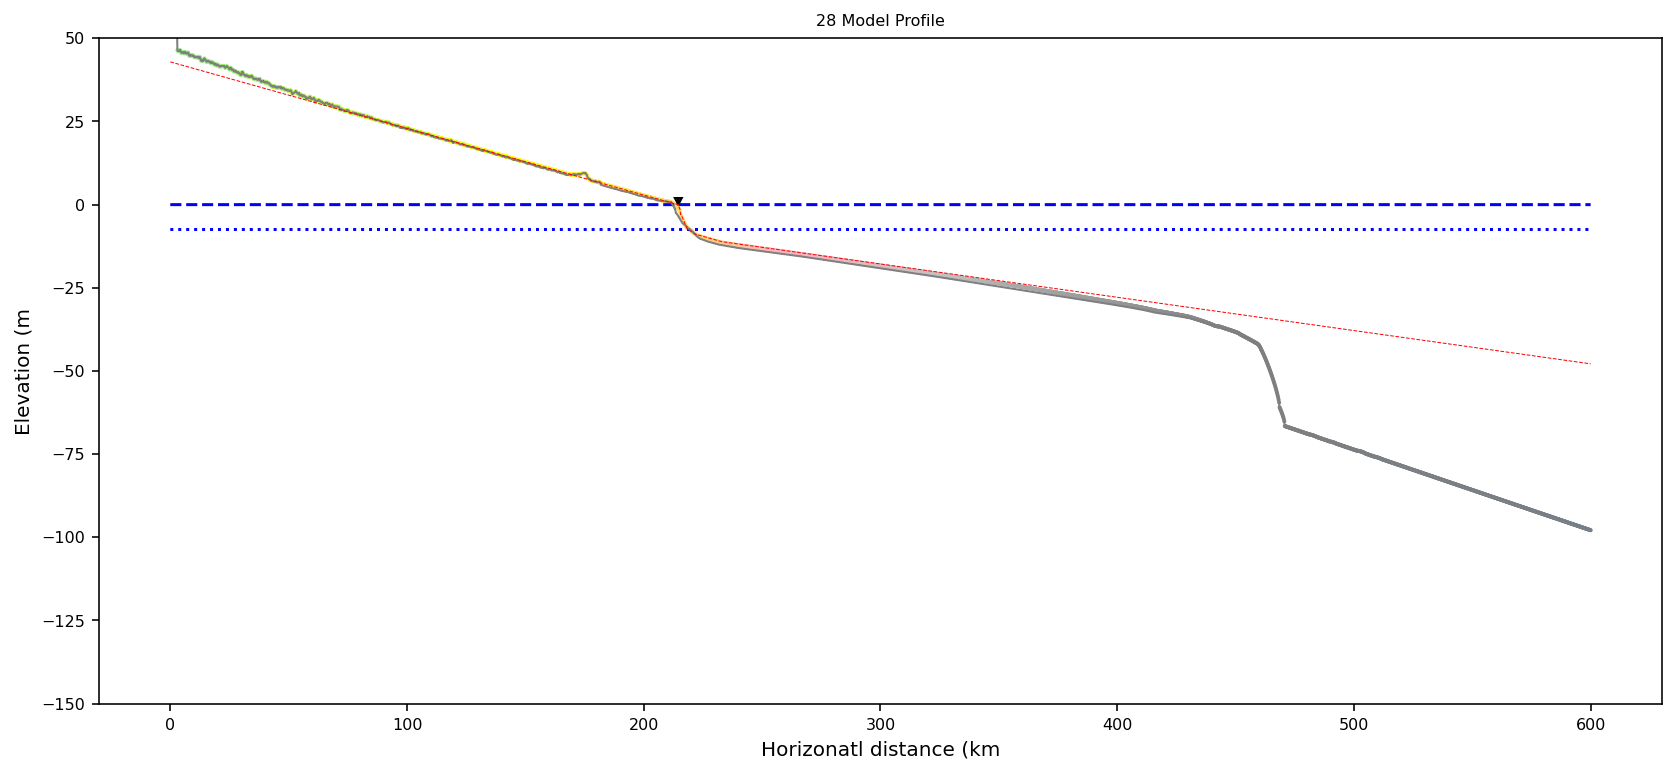

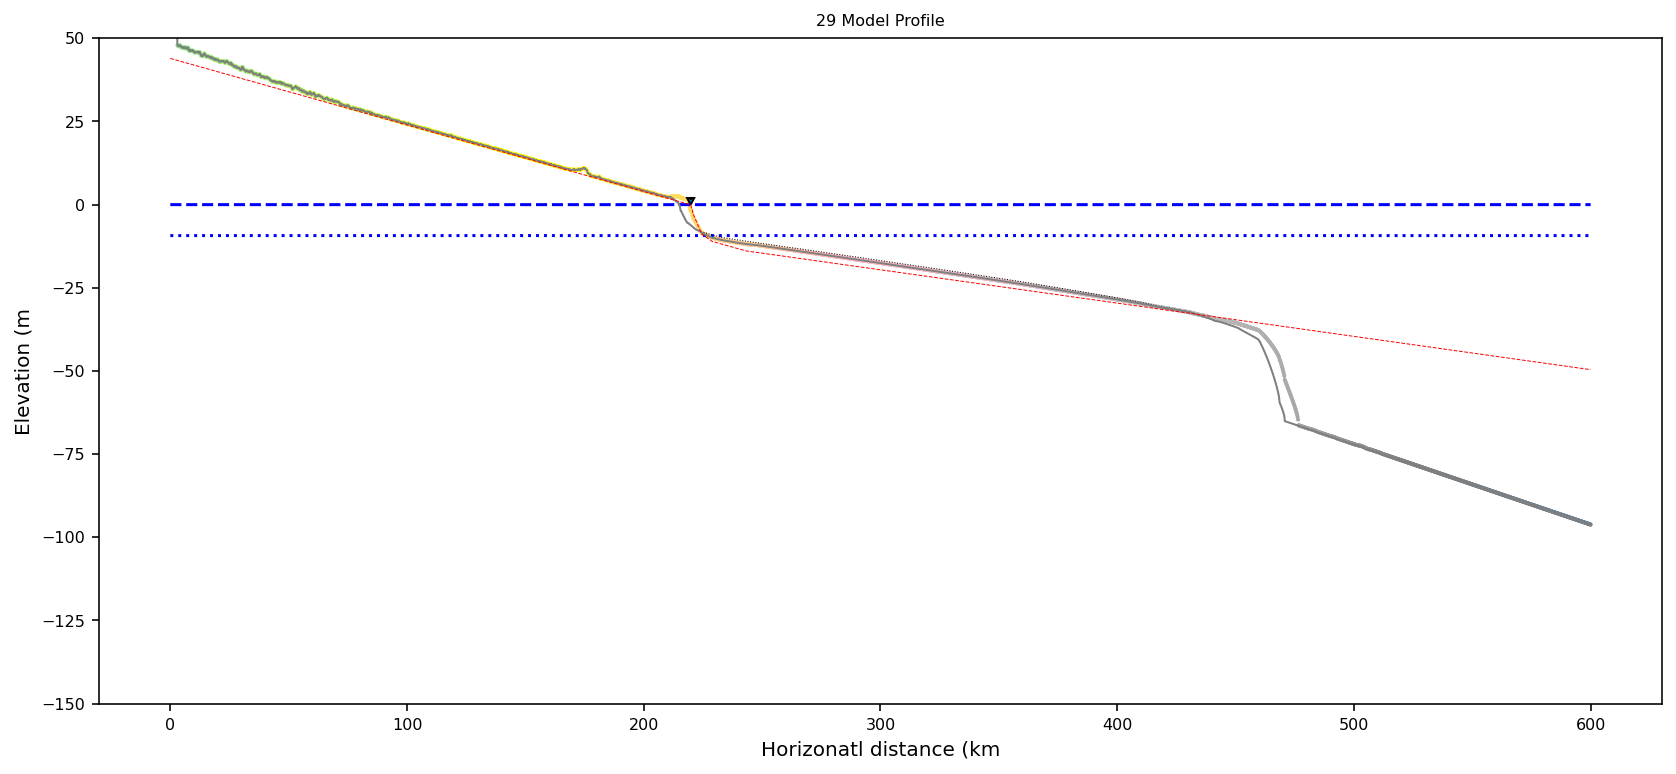

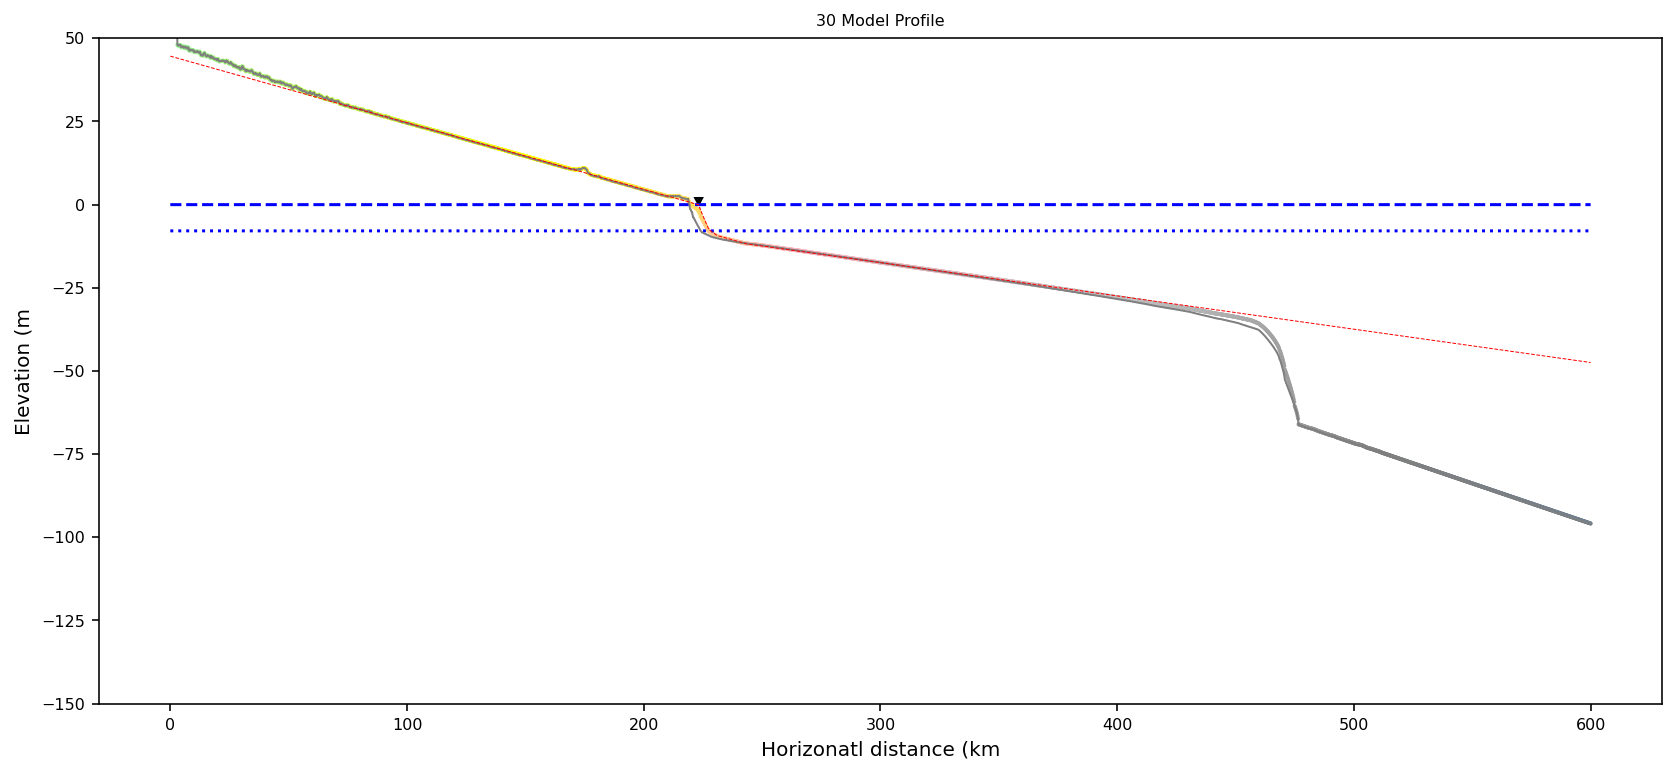

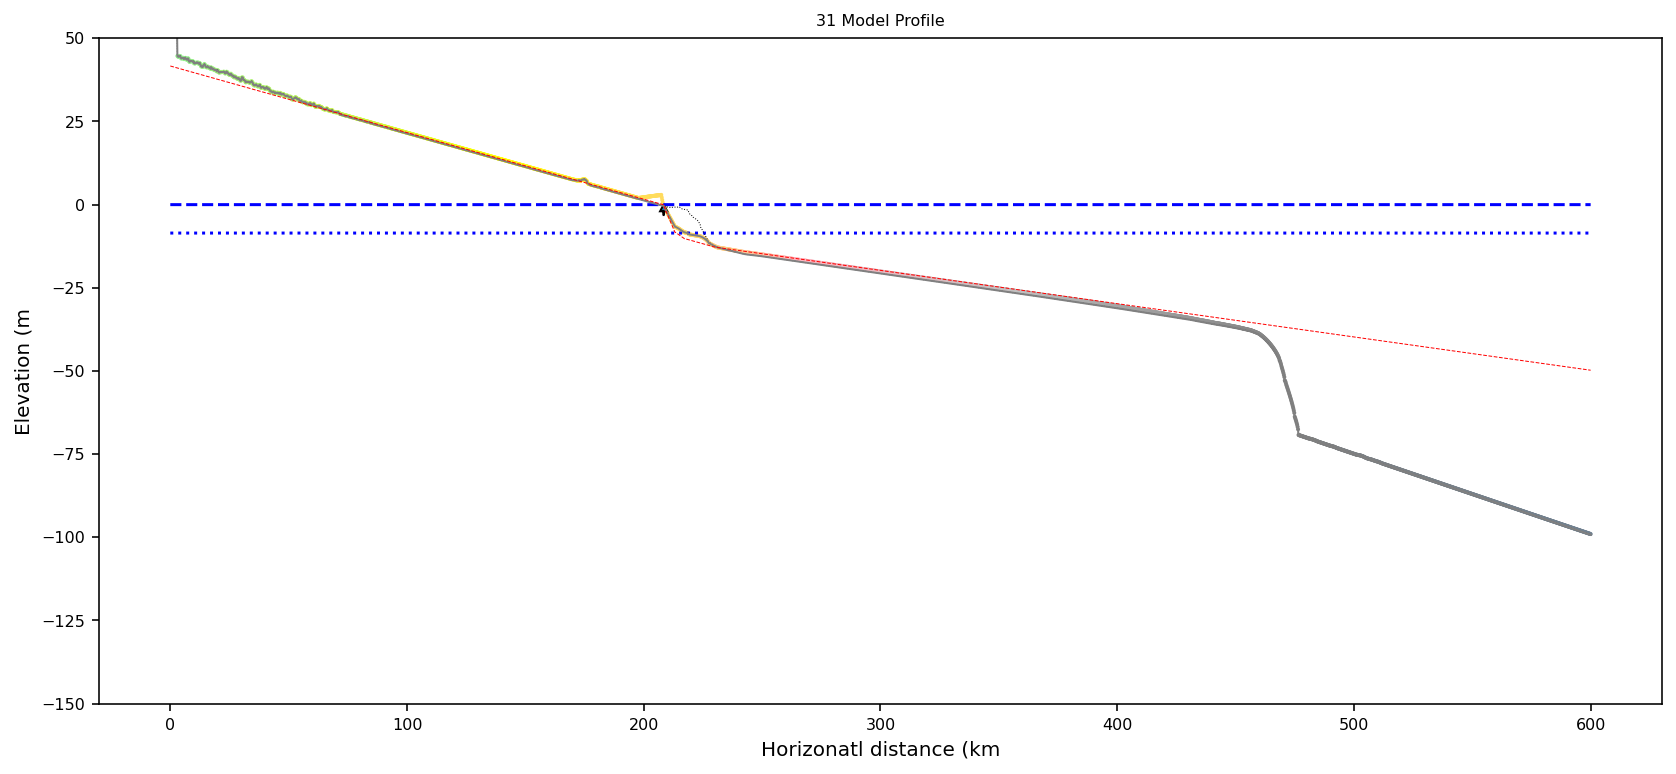

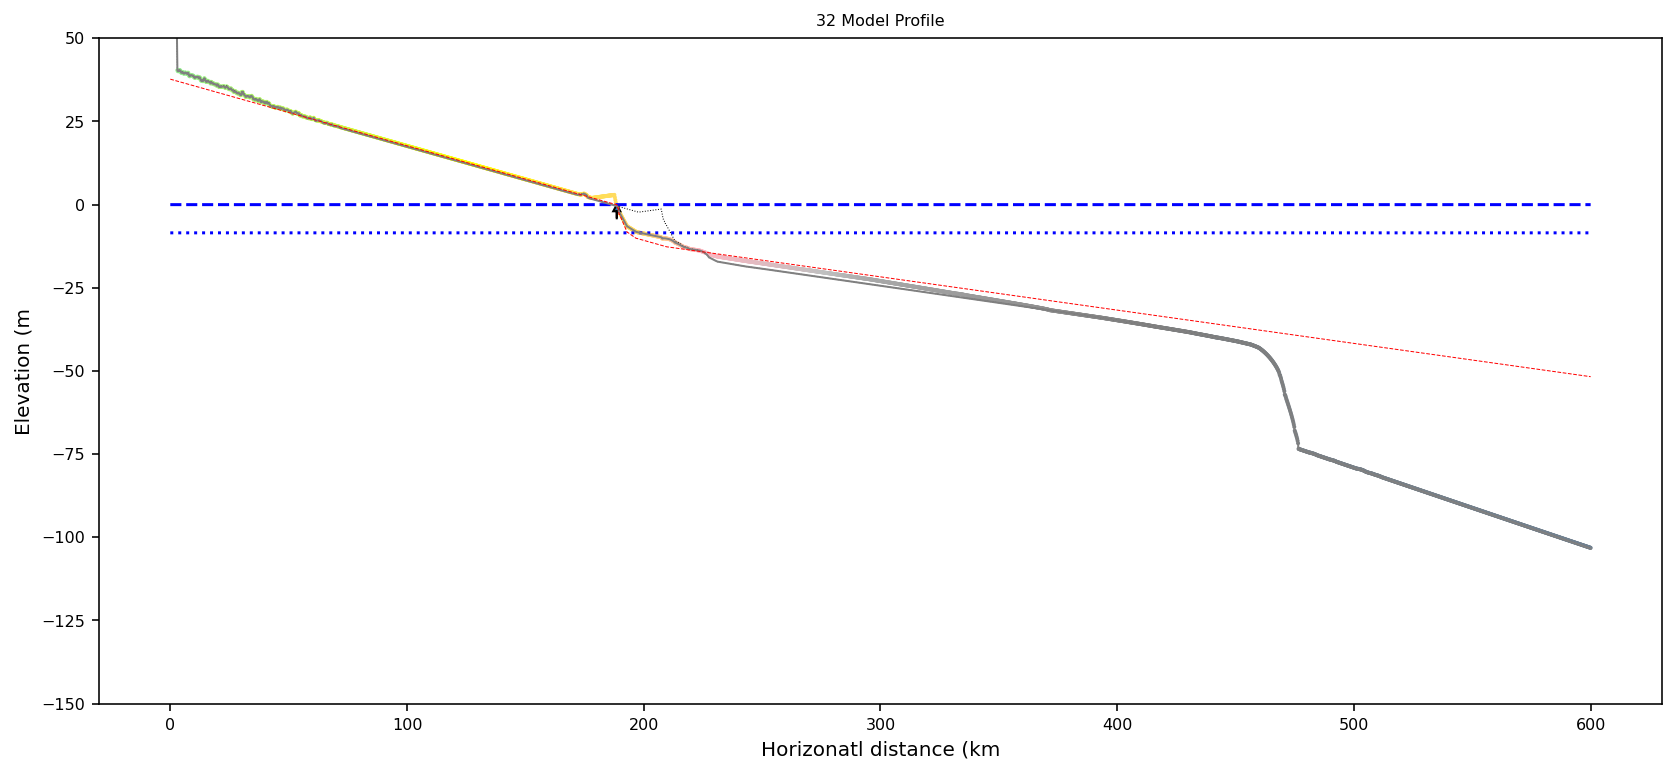

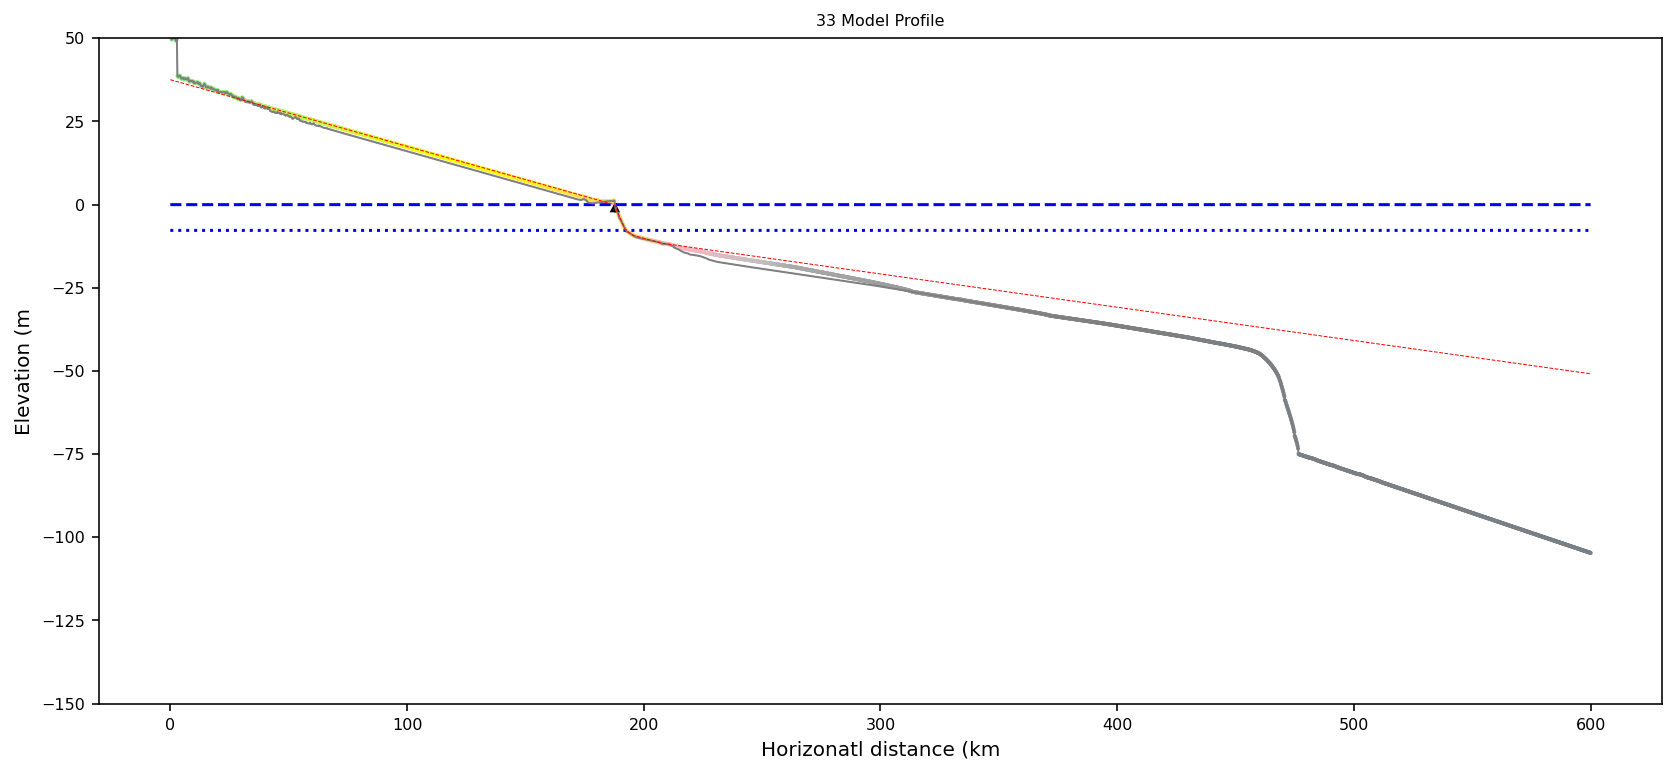

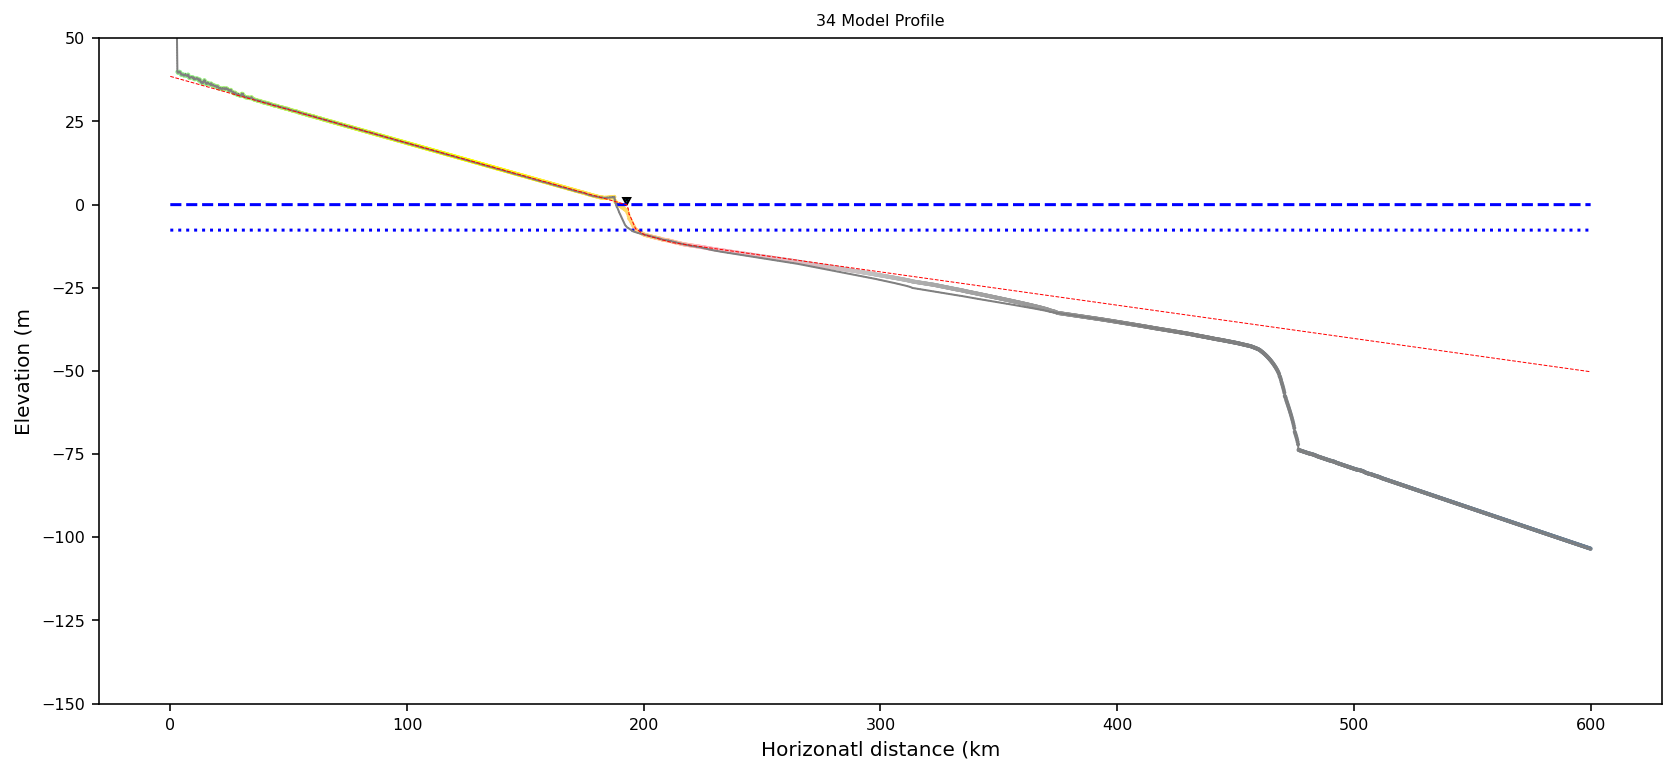

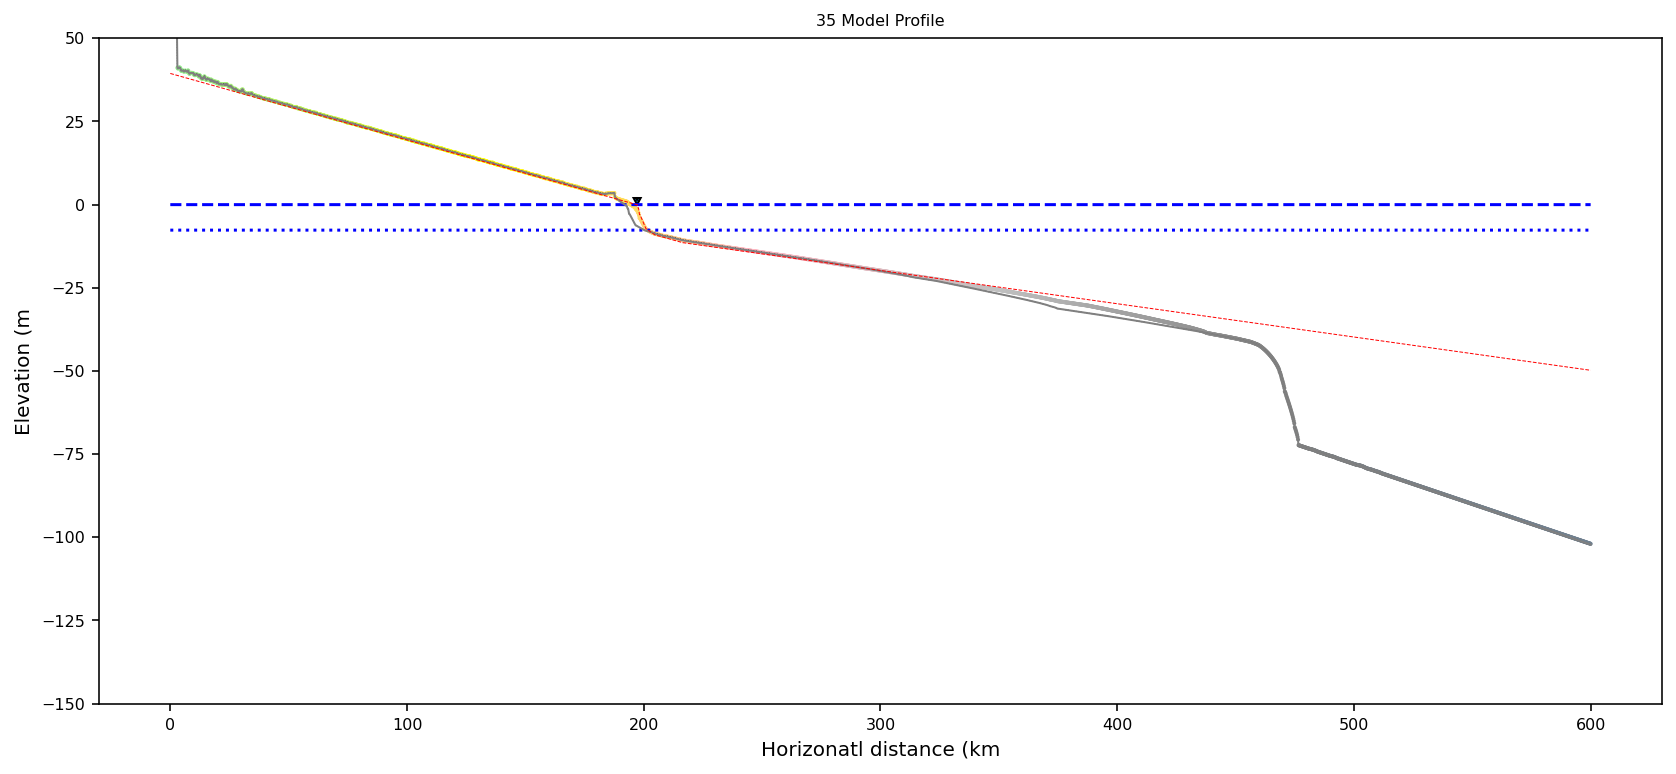

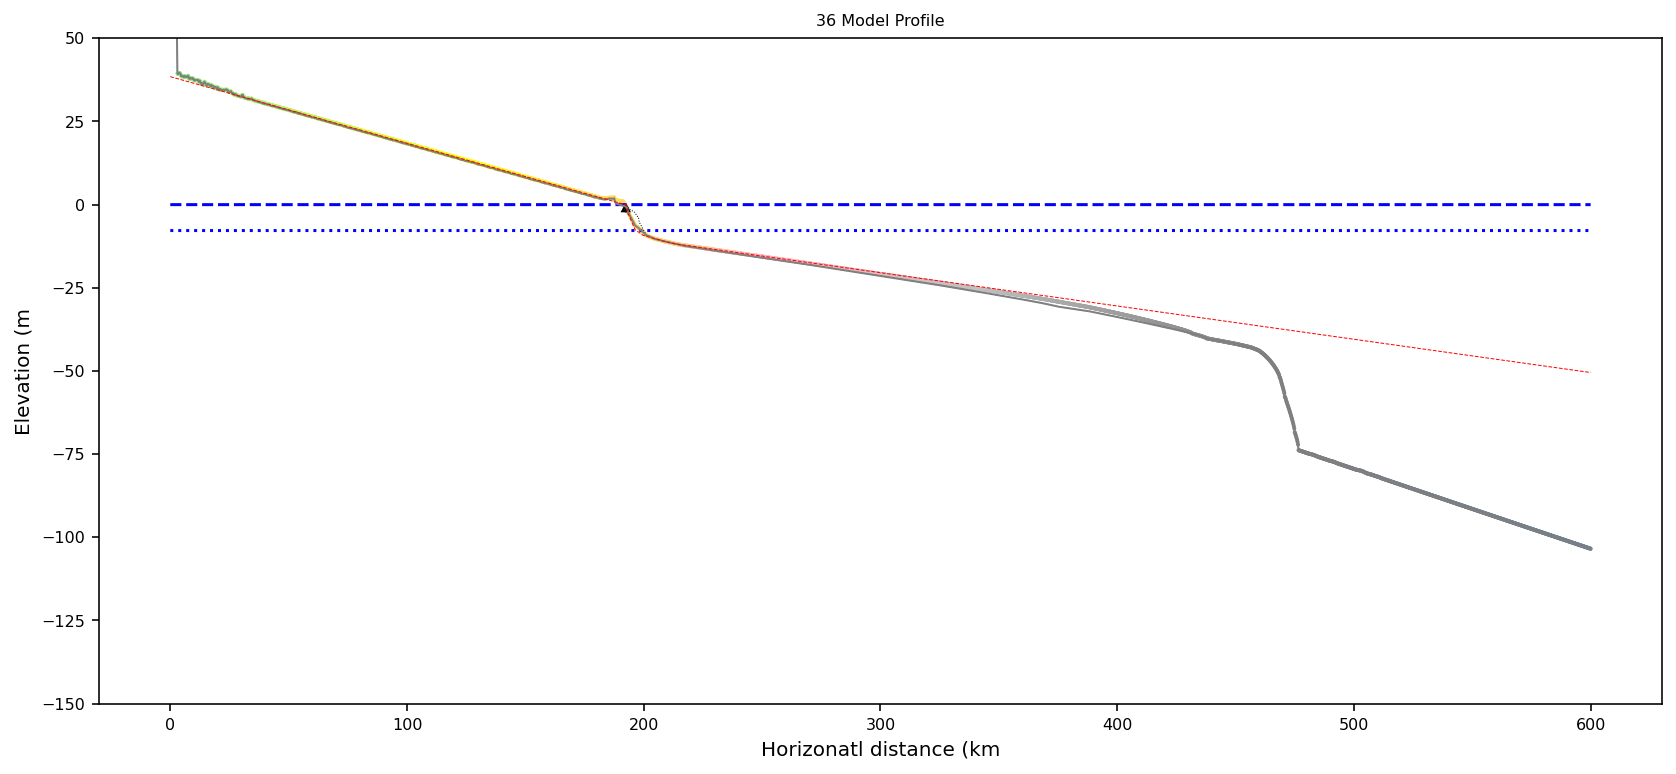

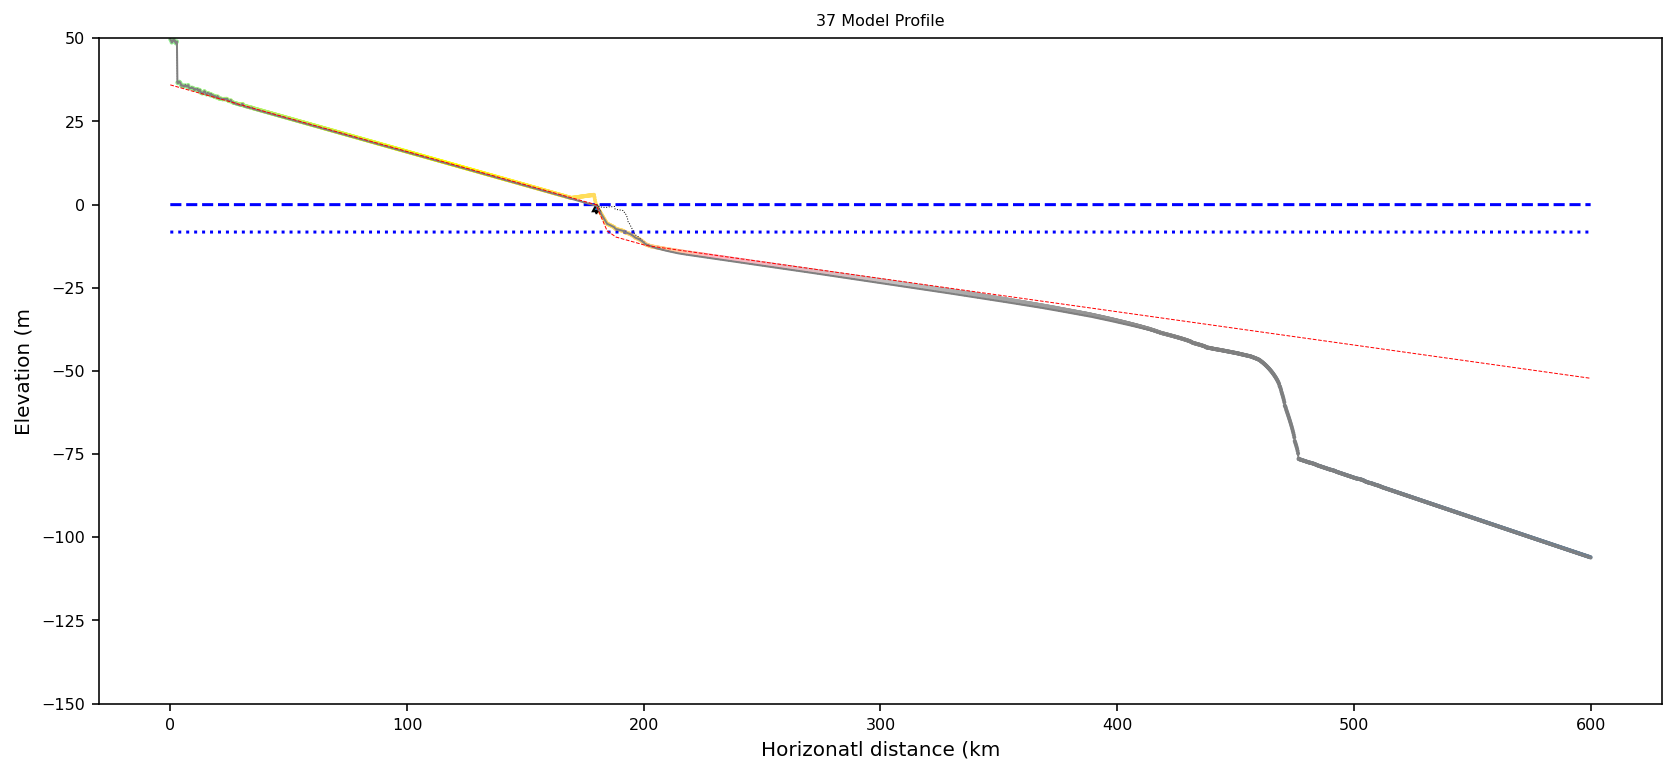

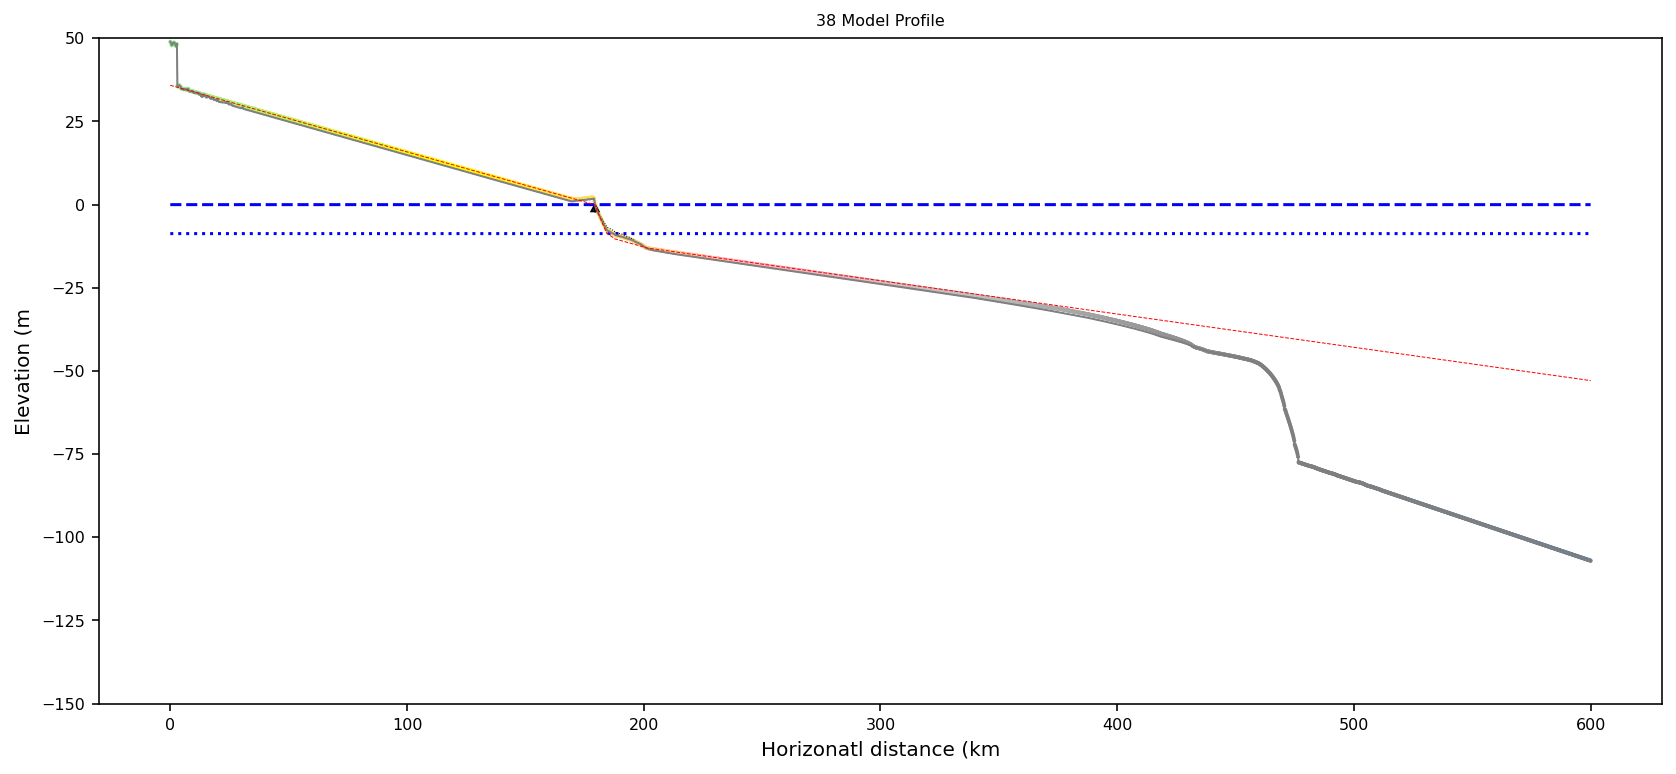

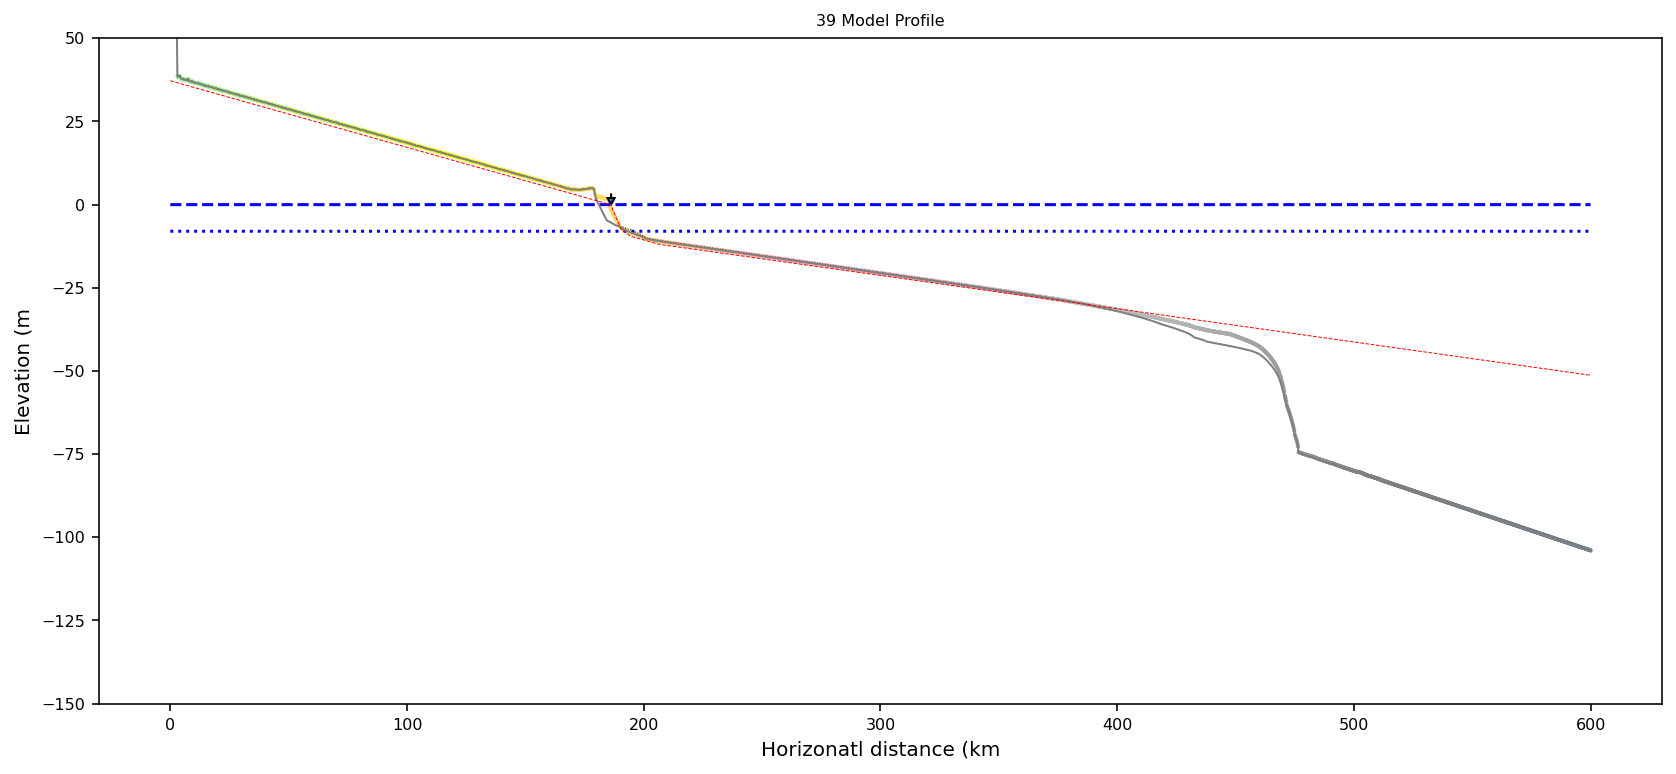

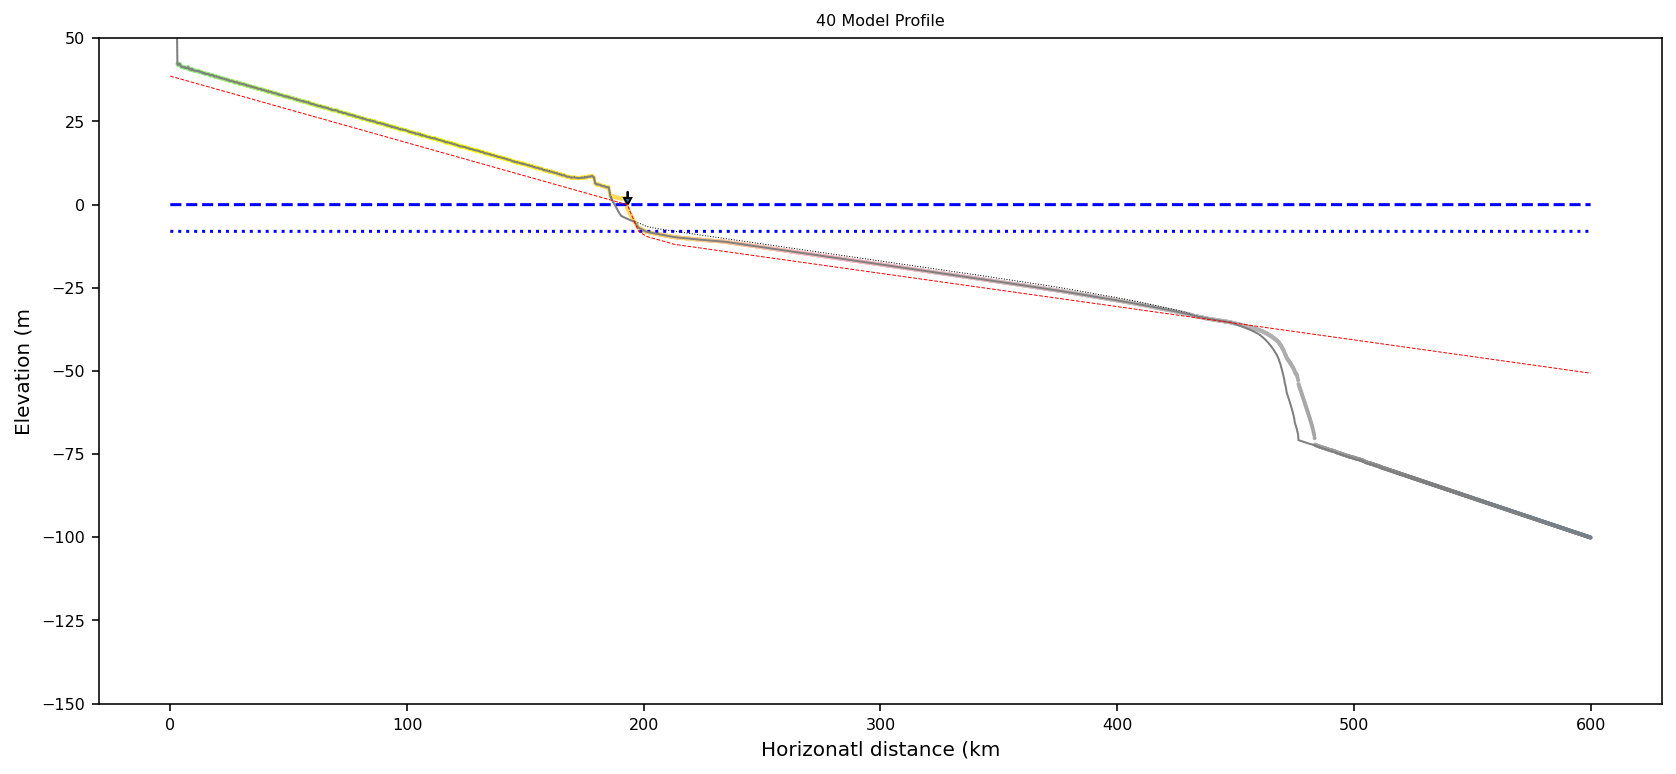

In [ ]:
istep = 1
i = 0
while i < 40:
  SFchange = [data.SFposition[istep+i],data.BaseLChange[istep+i],0,-data.BaseLChange[istep+i]]
  plotStep(istep+i,xlength,dfelev[istep+i],dfbase[istep+i],dfbref[istep+i],dflith[istep+i],dfprofile[istep+i],-data.SWB[istep+i],SFchange)
  plt.show()
  i += 1